Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 14 - Advanced Concepts for ML Projects

## 14.1 Exploring ensemble classifiers 

### Getting Ready

Prepare the Pipeline:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from chapter_14_utils import performance_evaluation_report

In [ ]:
df = pd.read_csv("../Datasets/credit_card_default.csv", na_values="")

X = df.copy()
y = X.pop("default_payment_next_month")

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

num_features = X_train.select_dtypes(include="number").columns.to_list()
cat_features = X_train.select_dtypes(include="object").columns.to_list()

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(categories=cat_list, sparse=False, 
                             handle_unknown="error", drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", num_pipeline, num_features),
        ("categorical", cat_pipeline, cat_features)
    ], 
    remainder="drop"
)

tree_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", DecisionTreeClassifier(random_state=42))]
)

tree_pipeline.fit(X_train, y_train)

LABELS = ["No Default", "Default"]
tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True, 
                                          show_pr_curve=True)

In [ ]:
print(f"Recall: {tree_perf['recall']:.4f}")

### How to do it...

1. Import the libraries:

In [ ]:
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier)
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from chapter_14_utils import performance_evaluation_report

2. Define and fit the Random Forest pipeline: 

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", rf)]
)

rf_pipeline.fit(X_train, y_train)
rf_perf = performance_evaluation_report(rf_pipeline, X_test, 
                                        y_test, labels=LABELS, 
                                        show_plot=True,
                                        show_pr_curve=True)
                                        
print(f"Recall: {rf_perf['recall']:.4f}")

sns.despine()
# plt.savefig("images/figure_14_1", dpi=200)

3. Define and fit the Gradient Boosted Trees pipeline: 

In [ ]:
gbt =  GradientBoostingClassifier(random_state=42)
gbt_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", gbt)]
)

gbt_pipeline.fit(X_train, y_train)
gbt_perf = performance_evaluation_report(gbt_pipeline, X_test, 
                                         y_test, labels=LABELS, 
                                         show_plot=True,
                                         show_pr_curve=True)

print(f"Recall: {gbt_perf['recall']:.4f}")

sns.despine()
# plt.savefig("images/figure_14_2", dpi=200)

4. Define and fit an XGBoost pipeline: 

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", xgb)]
)

xgb_pipeline.fit(X_train, y_train)
xgb_perf = performance_evaluation_report(xgb_pipeline, X_test, 
                                         y_test, labels=LABELS, 
                                         show_plot=True,
                                         show_pr_curve=True)
                                         
print(f"Recall: {xgb_perf['recall']:.4f}")

sns.despine()
# plt.savefig("images/figure_14_3", dpi=200)

5. Define and fit the LightGBM pipeline: 

In [ ]:
lgbm = LGBMClassifier(random_state=42)
lgbm_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", lgbm)]
)

lgbm_pipeline.fit(X_train, y_train)
lgbm_perf = performance_evaluation_report(lgbm_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True,
                                          show_pr_curve=True)

print(f"Recall: {lgbm_perf['recall']:.4f}")

sns.despine()
# plt.savefig("images/figure_14_4", dpi=200)

### There's more

Below we go over the most important hyperparameters of the considered models and show a possible way of tuning them using Randomized Search. With more complex models, the training time is significantly longer than with the basic Decision Tree. That is why we need to find a balance between the time we want to spend on tuning the hyperparameters and the expected results. Also, bear in mind that changing the values of some parameters (such as learning rate or the number of estimators) can itself influence the training time of the models.

To have the results in a reasonable amount of time, we used the Randomized Search with 100 different sets of hyperparameters for each model (the number of actually fitted models is higher due to cross-validation). 

For a complete list of hyperparameters and their meaning, please refer to the corresponding documentations.

As in the previous chapter, we used recall as the evaluation metric.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
import numpy as np

N_SEARCHES = 100
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

**Random Forest**

When tuning the Random Forest classifier, we look at the following hyperparameters (there are more available for tuning):
* `n_estimators` - the number of decision trees in a forest. The goal is to find a balance between improved accuracy and computational cost.
* `max_features` - the maximum number of features considered for splitting a node. The default is the square root of the number of features. When None, all features are considered.
* `max_depth` - the maximum number of levels in each decision tree
* `min_samples_split` - the minimum number of observations required to split each node. When set to high it may cause underfitting, as the trees will not split enough times.
* `min_samples_leaf` - the minimum number of data points allowed in a leaf. Too small a value might cause overfitting, while large values might prevent the tree from growing and cause underfitting.
* `bootstrap` - whether to use bootstrapping for each tree in the forest

We define the grid below:

In [ ]:
rf_param_grid = {
    "classifier__n_estimators": np.linspace(100, 500, 5, dtype=int),
    "classifier__max_features": ["log2", "sqrt", None],
    "classifier__max_depth": np.arange(3, 11, 1, dtype=int),
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": np.arange(1, 51, 2, dtype=int),
    "classifier__bootstrap": [True, False]
}

And use the randomized search to tune the classifier:

In [ ]:
rf_rs =  RandomizedSearchCV(rf_pipeline, rf_param_grid, scoring="recall", 
                            cv=k_fold, n_jobs=-1, verbose=1, 
                            n_iter=N_SEARCHES, random_state=42)

rf_rs.fit(X_train, y_train)

print(f"Best parameters: {rf_rs.best_params_}") 
print(f"Recall (Training set): {rf_rs.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, rf_rs.predict(X_test)):.4f}")

In [ ]:
rf_rs_perf = performance_evaluation_report(rf_rs, X_test, 
                                           y_test, labels=LABELS, 
                                           show_plot=True,
                                           show_pr_curve=True)

**Gradient Boosted Trees**

As Gradient Boosted Trees are also an ensemble method built on top of decision trees, a lot of the parameters are the same as in the case of the Random Forest. The new one is the learning rate, which is used in the gradient descent algorithm to control the rate of descent towards the minimum of the loss function. When tuning the tree manually, we should consider this hyperparameter together with the number of estimators, as reducing the learning rate (the learning is slower), while increasing the number of estimators can increase the computation time significantly.

We define the grid as follows:

In [ ]:
gbt_param_grid = {
    "classifier__n_estimators": np.linspace(100, 500, 5, dtype=int),
    "classifier__learning_rate": np.arange(0.05, 0.31, 0.05),
    "classifier__max_depth": np.arange(3, 11, 1, dtype=int),
    "classifier__min_samples_split": np.linspace(0.1, 0.5, 12),
    "classifier__min_samples_leaf": np.arange(1, 51, 2, dtype=int),
    "classifier__max_features":["log2", "sqrt", None]
}

And run the randomized search:

In [ ]:
gbt_rs =  RandomizedSearchCV(gbt_pipeline, gbt_param_grid, scoring="recall", 
                             cv=k_fold, n_jobs=-1, verbose=1, 
                             n_iter=N_SEARCHES, random_state=42)

gbt_rs.fit(X_train, y_train)

print(f"Best parameters: {gbt_rs.best_params_}") 
print(f"Recall (Training set): {gbt_rs.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, gbt_rs.predict(X_test)):.4f}")

In [ ]:
gbt_rs_perf = performance_evaluation_report(gbt_rs, X_test, 
                                            y_test, labels=LABELS, 
                                            show_plot=True,
                                            show_pr_curve=True)

**XGBoost**

The scikit-learn API of XGBoost makes sure that the hyperparameters are named similarly to their equivalents other scikit-learn's classifiers. So the XGBoost native eta hyperparameter is called learning_rate in scikit-learn's API. 

The new hyperparameters we consider for this example are:
* `min_child_weight` - indicates the minimum sum of weights of all observations required in a child. This hyperparameter is used for controlling overfitting. Cross-validation should be used for tuning.
* `colsample_bytree` - indicates the fraction of columns to be randomly sampled for each tree.

We define the grid as:

In [ ]:
xgb_param_grid = {
    "classifier__n_estimators": np.linspace(100, 500, 5, dtype=int),
    "classifier__learning_rate": np.arange(0.05, 0.31, 0.05),
    "classifier__max_depth": np.arange(3, 11, 1, dtype=int),
    "classifier__min_child_weight": np.arange(1, 8, 1, dtype=int),
    "classifier__colsample_bytree": np.linspace(0.3, 1, 7)
}

For defining ranges of parameters that are restricted (such as colsample_bytree which cannot be higher than 1.0) it is better to use `np.linspace` rather than `np.arange`, because the latter allows for some inconsistencies when the step is defined as floating-point. For example, the last value might be 1.0000000002, which then causes an error while training the classifier.

In [ ]:
xgb_rs =  RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring="recall", 
                             cv=k_fold, n_jobs=-1, verbose=1, 
                             n_iter=N_SEARCHES, random_state=42)

xgb_rs.fit(X_train, y_train)

print(f"Best parameters: {xgb_rs.best_params_}") 
print(f"Recall (Training set): {xgb_rs.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, xgb_rs.predict(X_test)):.4f}")

In [ ]:
xgb_rs_perf = performance_evaluation_report(xgb_rs, X_test, 
                                            y_test, labels=LABELS, 
                                            show_plot=True,
                                            show_pr_curve=True)

**LightGBM**

We tune the same parameters as in XGBoost, though more is definitely possible and encouraged. The grid is defined as follows:

In [ ]:
lgbm_param_grid = {
    "classifier__n_estimators": np.linspace(100, 500, 5, dtype=int),
    "classifier__learning_rate": np.arange(0.05, 0.31, 0.05),
    "classifier__max_depth": np.arange(3, 11, 1, dtype=int),
    "classifier__colsample_bytree": np.linspace(0.3, 1, 7)
}

In [ ]:
lgbm_rs =  RandomizedSearchCV(lgbm_pipeline, lgbm_param_grid, scoring="recall", 
                              cv=k_fold, n_jobs=-1, verbose=1, 
                              n_iter=N_SEARCHES, random_state=42)

lgbm_rs.fit(X_train, y_train)

print(f"Best parameters: {lgbm_rs.best_params_}") 
print(f"Recall (Training set): {lgbm_rs.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, lgbm_rs.predict(X_test)):.4f}")

In [ ]:
lgbm_rs_perf = performance_evaluation_report(lgbm_rs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True,
                                             show_pr_curve=True)

Below we present a summary of all the classifiers we have considered in this exercise.

In [ ]:
results_dict = {
    "decision_tree_baseline": tree_perf,
    "random_forest": rf_perf,
    "random_forest_rs": rf_rs_perf,
    "gradient_boosted_trees": gbt_perf,
    "gradient_boosted_trees_rs": gbt_rs_perf,
    "xgboost": xgb_perf,
    "xgboost_rs": xgb_rs_perf,
    "light_gbm": lgbm_perf,
    "light_gbm_rs": lgbm_rs_perf
}

results_comparison = pd.DataFrame(results_dict).T
results_comparison

In [ ]:
results_comparison.to_csv("results_comparison.csv")

## 14.2 Exploring alternative approaches to encoding categorical features

### Getting Ready

Prepare the Pipeline:

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from chapter_14_utils import performance_evaluation_report
from sklearn.ensemble import RandomForestClassifier

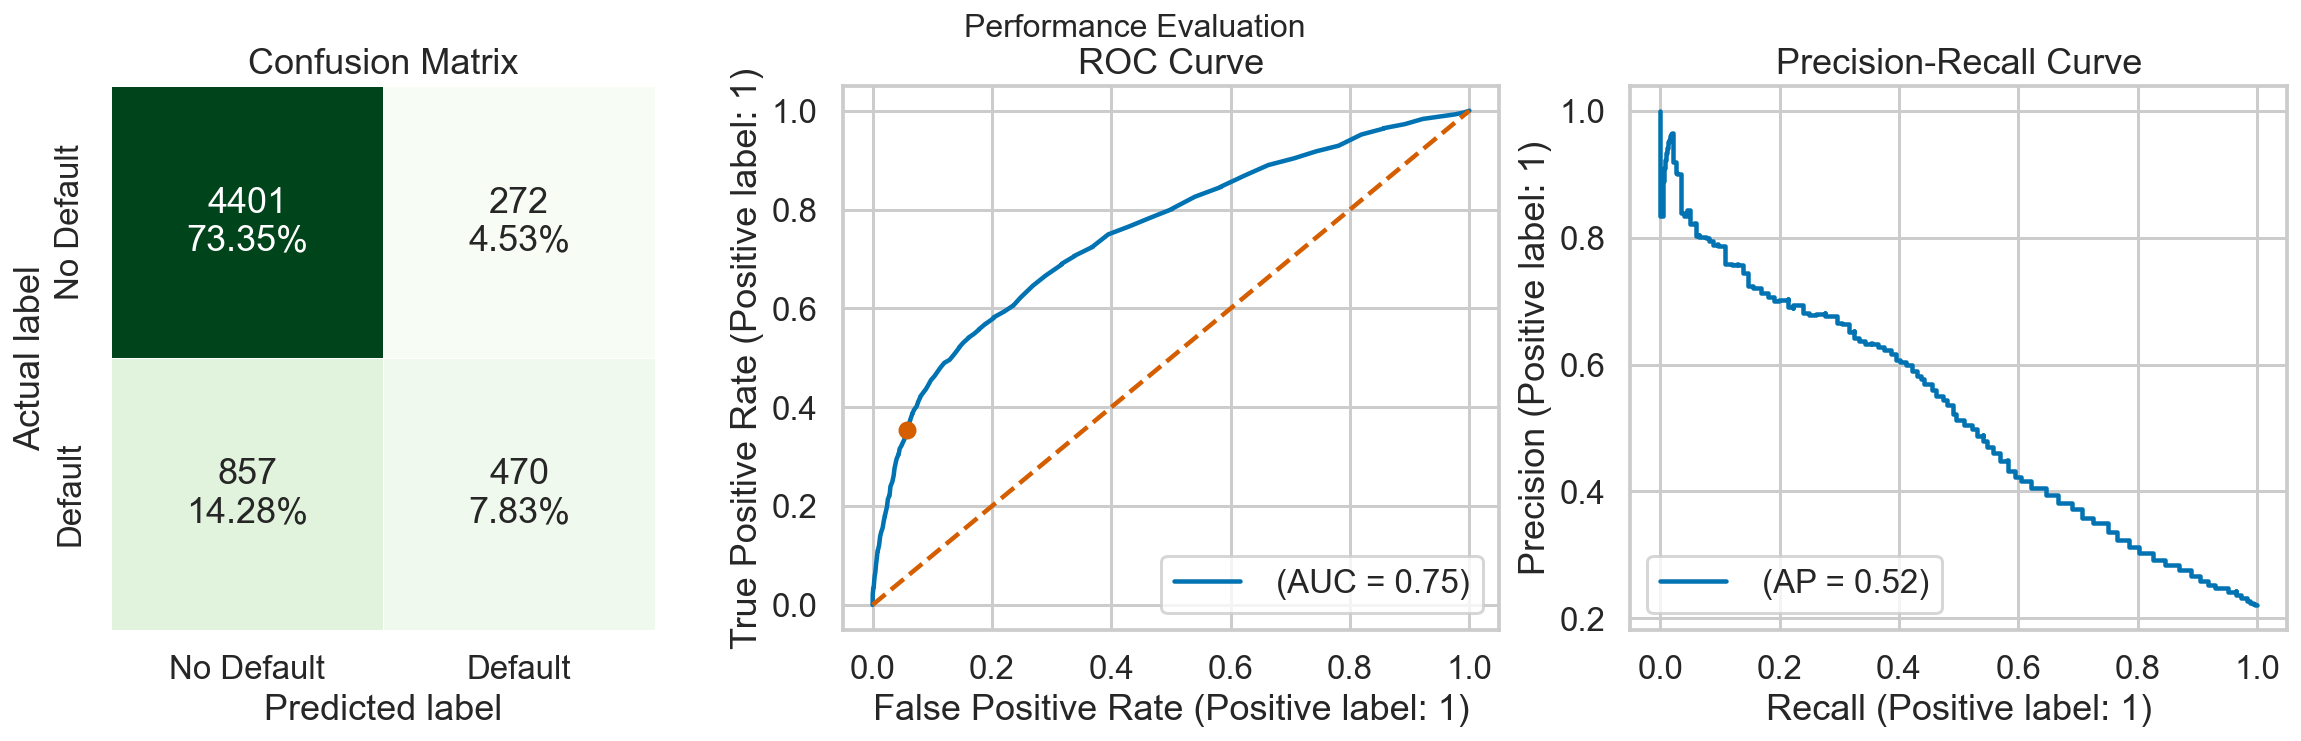

In [4]:
df = pd.read_csv("../Datasets/credit_card_default.csv", na_values="")

X = df.copy()
y = X.pop("default_payment_next_month")

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

num_features = X_train.select_dtypes(include="number").columns.to_list()
cat_features = X_train.select_dtypes(include="object").columns.to_list()

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoding", OneHotEncoder(categories=cat_list, sparse=False, 
                             handle_unknown="error", drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", num_pipeline, num_features),
        ("categorical", cat_pipeline, cat_features)
    ], 
    remainder="drop"
)

rf_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", RandomForestClassifier(random_state=42))]
)

rf_pipeline.fit(X_train, y_train)

LABELS = ["No Default", "Default"]
rf_perf = performance_evaluation_report(rf_pipeline, X_test, 
                                        y_test, labels=LABELS, 
                                        show_plot=True, 
                                        show_pr_curve=True)

In [5]:
rf_perf

{'accuracy': 0.8118333333333333,
 'precision': 0.633423180592992,
 'recall': 0.3541823662396383,
 'specificity': 0.941793280547828,
 'f1_score': 0.4543257612373127,
 'cohens_kappa': 0.35144338792034113,
 'matthews_corr_coeff': 0.3731445361101501,
 'roc_auc': 0.7517763463762952,
 'pr_auc': 0.5247244574365608,
 'average_precision': 0.5207332793563594}

In [6]:
print(f"Recall: {rf_perf['recall']:.4f}")

Recall: 0.3542


### How to do it...

1. Import the libraries:

In [7]:
import category_encoders as ce
from sklearn.base import clone

2. Fit the pipeline using target encoding:

Recall: 0.3677


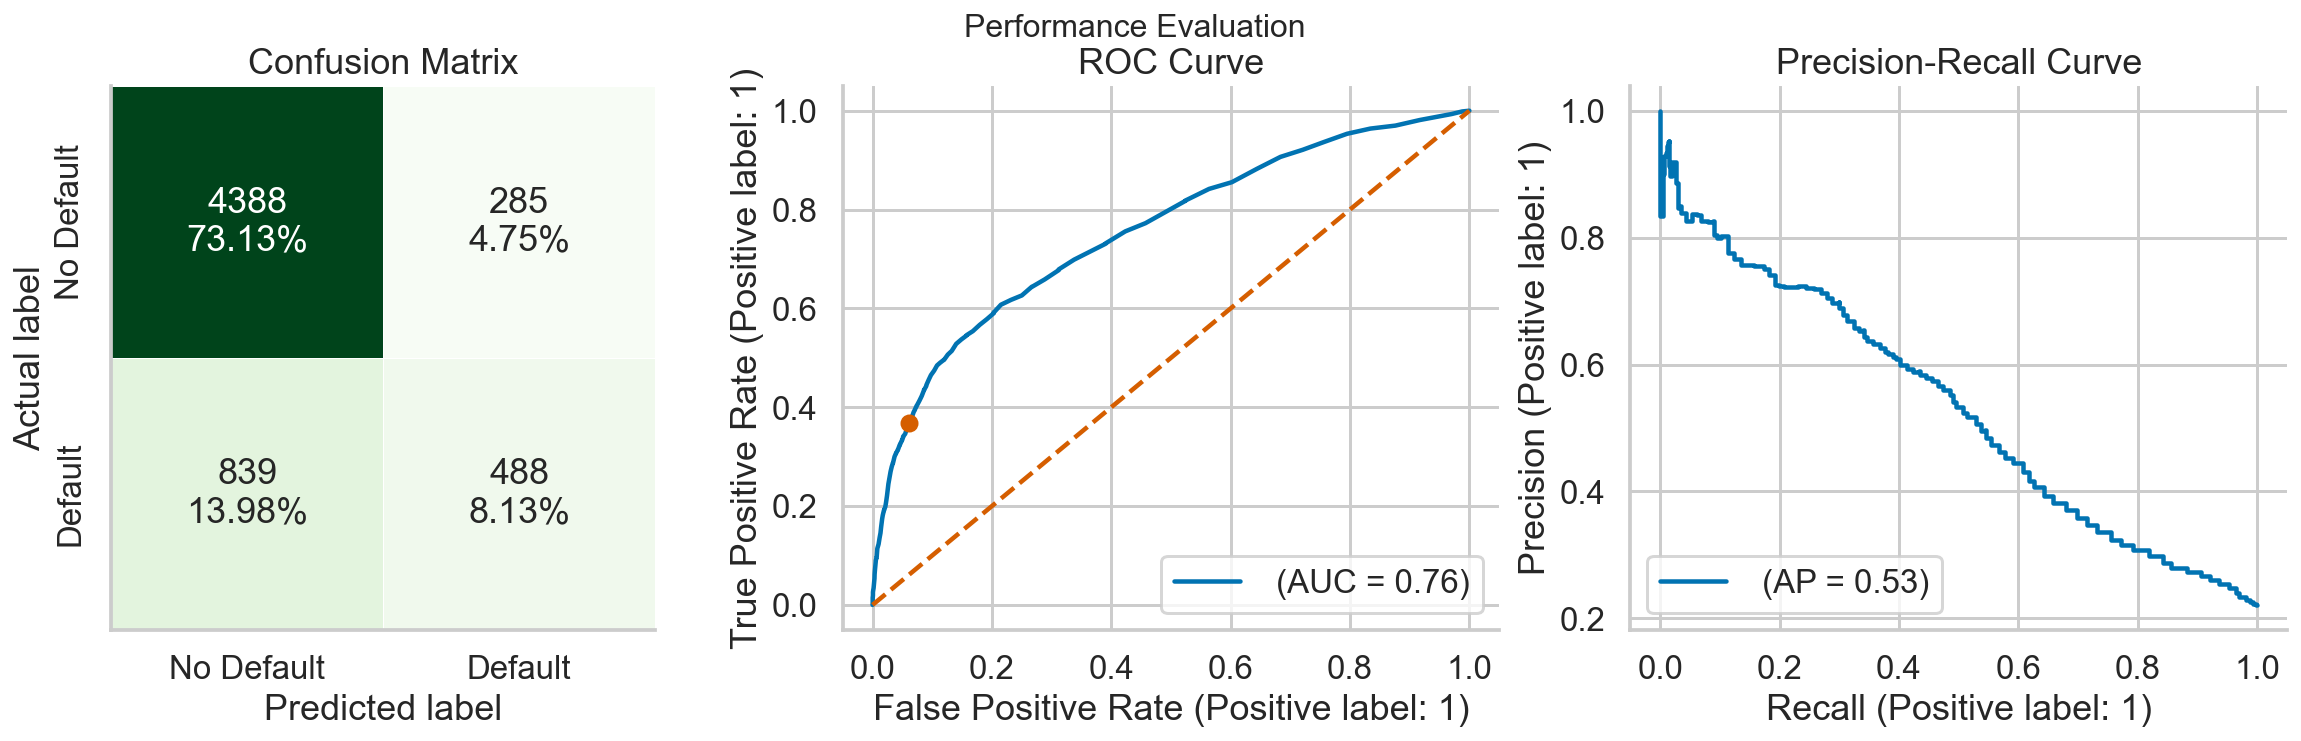

In [8]:
pipeline_target_enc = clone(rf_pipeline)
pipeline_target_enc.set_params(
    preprocessor__categorical__cat_encoding=ce.TargetEncoder()
)

pipeline_target_enc.fit(X_train, y_train)
target_enc_perf = performance_evaluation_report(
    pipeline_target_enc, X_test, 
    y_test, labels=LABELS, 
    show_plot=True, 
    show_pr_curve=True
)
print(f"Recall: {target_enc_perf['recall']:.4f}")

sns.despine()
# plt.savefig("images/figure_14_10", dpi=200)

3. Fit the pipeline using Leave One Out encoding:

Recall: 0.1462


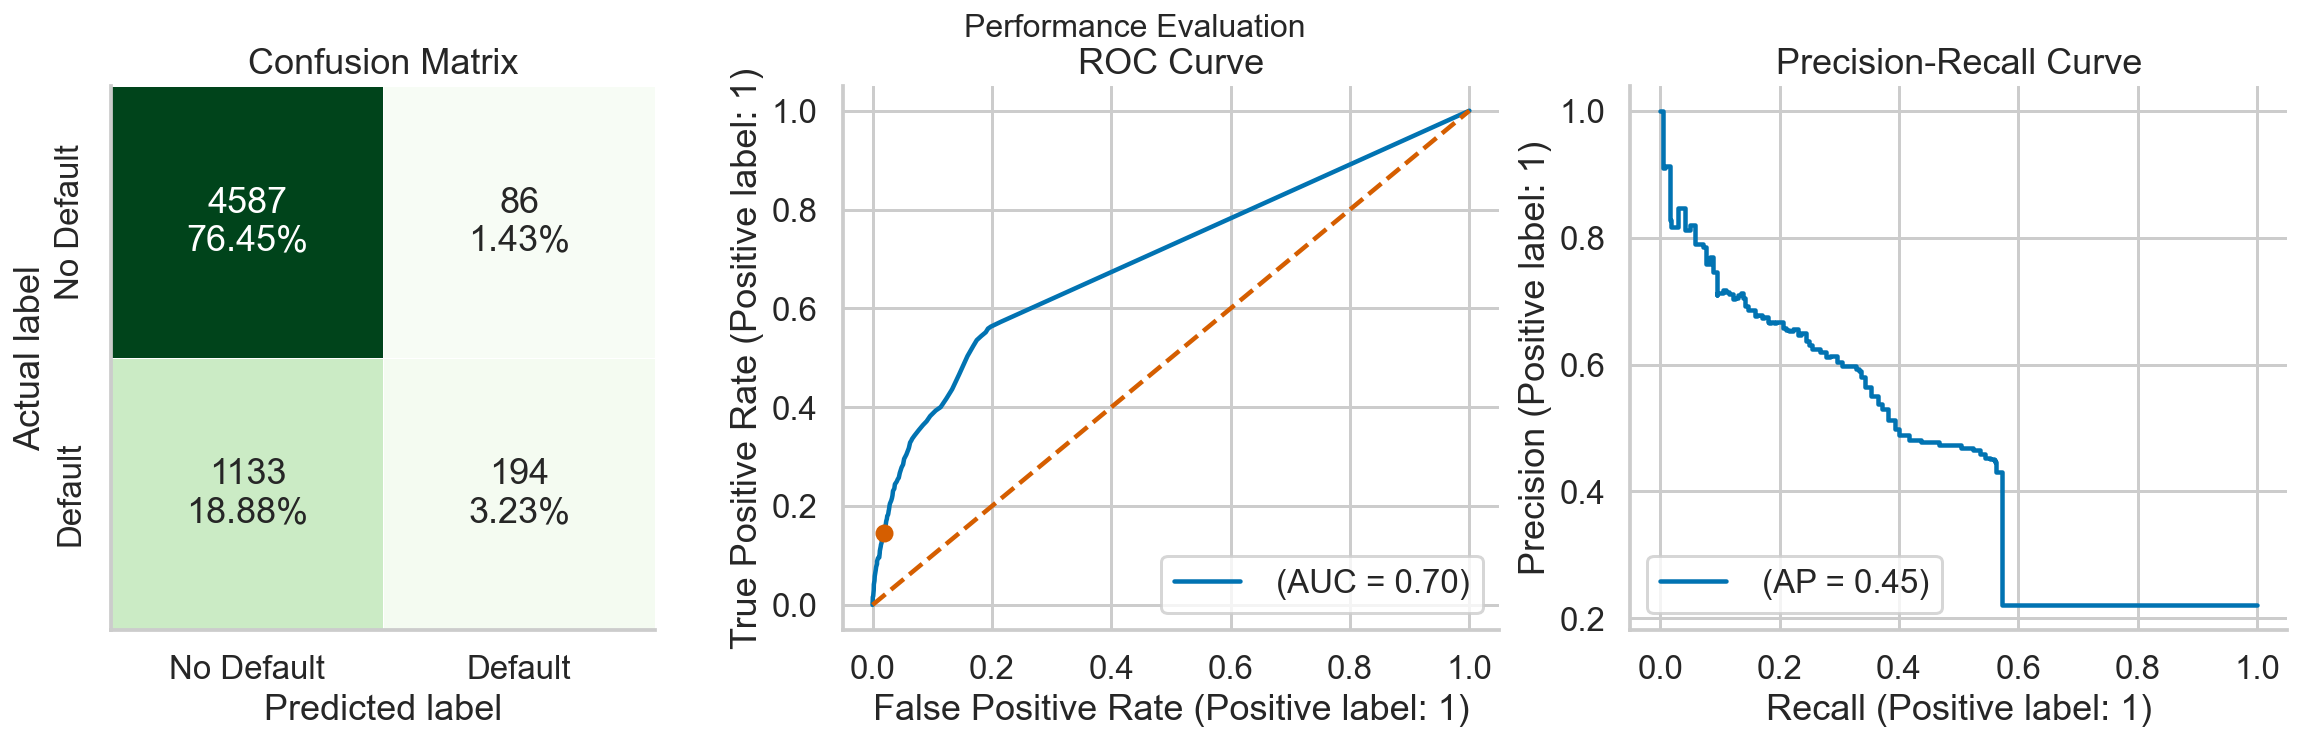

In [9]:
pipeline_loo_enc = clone(rf_pipeline)
pipeline_loo_enc.set_params(
    preprocessor__categorical__cat_encoding=ce.LeaveOneOutEncoder()
)

pipeline_loo_enc.fit(X_train, y_train)
loo_enc_perf = performance_evaluation_report(
    pipeline_loo_enc, X_test, 
    y_test, labels=LABELS, 
    show_plot=True, 
    show_pr_curve=True
)
print(f"Recall: {loo_enc_perf['recall']:.4f}")

sns.despine()
# plt.savefig("images/figure_14_11", dpi=200)

In [ ]:
# testing if we can improve the performance by adding random noise

pipeline_loo_enc = clone(rf_pipeline)
pipeline_loo_enc.set_params(
    preprocessor__categorical__cat_encoding=ce.LeaveOneOutEncoder(sigma=0.05, random_state=42)
)

pipeline_loo_enc.fit(X_train, y_train)
loo_enc_perf = performance_evaluation_report(
    pipeline_loo_enc, X_test, 
    y_test, labels=LABELS, 
    show_plot=True, 
    show_pr_curve=True
)
print(f"Recall: {loo_enc_perf['recall']:.4f}")

sns.despine()

4. Fit the pipeline using Weight of Evidence encoding:

Recall: 0.3708


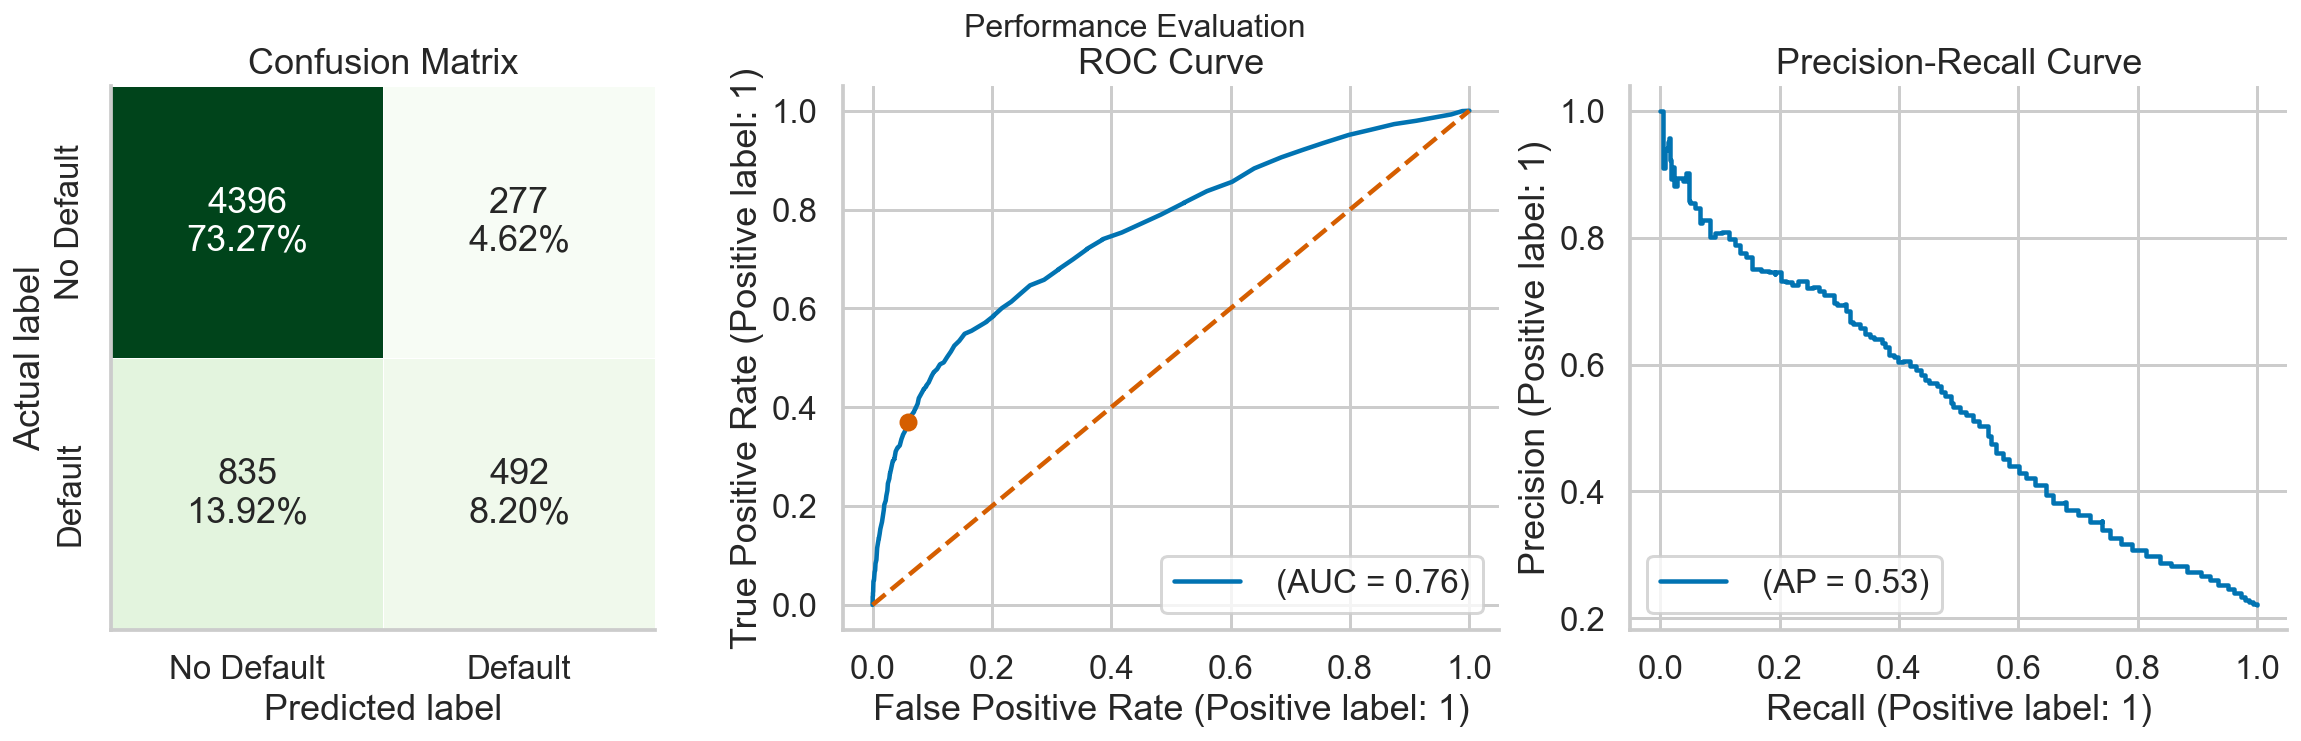

In [10]:
pipeline_woe_enc = clone(rf_pipeline)
pipeline_woe_enc.set_params(
    preprocessor__categorical__cat_encoding=ce.WOEEncoder()
)

pipeline_woe_enc.fit(X_train, y_train)
woe_enc_perf = performance_evaluation_report(
    pipeline_woe_enc, X_test, 
    y_test, labels=LABELS, 
    show_plot=True, 
    show_pr_curve=True
)
print(f"Recall: {woe_enc_perf['recall']:.4f}")

sns.despine()
# plt.savefig("images/figure_14_12", dpi=200)

### There's more

Experimenting with different values of `min_samples_leaf` and `smoothing` for target encoding:

In [ ]:
for smoothing in [0, 1, 2, 5, 10]:
    for min_smpl_leaf in [1, 5]:

        pipeline_target_enc = clone(rf_pipeline)
        pipeline_target_enc.set_params(
            preprocessor__categorical__cat_encoding=ce.TargetEncoder(min_samples_leaf=min_smpl_leaf,
                                                                     smoothing=smoothing)
        )

        pipeline_target_enc.fit(X_train, y_train)
        target_enc_perf = performance_evaluation_report(pipeline_target_enc, X_test, 
                                                        y_test, labels=LABELS, 
                                                        show_plot=False, 
                                                        show_pr_curve=False)
        print(f"Smoothing <{smoothing}> Min Samples Leaf <{min_smpl_leaf}> --- Recall: {target_enc_perf['recall']:.4f}")

### Bonus: small examples

Below you can find some self-contained examples which show how the encoding algorithms work.
For your convenience, they are the same as the ones shown as examples in the book.

In [ ]:
import category_encoders as ce
import pandas as pd

**Target encoding**

In [ ]:
# binary target
df = pd.DataFrame({
   "category":["a", "a", "b", "b", "b"], 
   "target":[1,0,1,1,0]})

X = df.drop("target", axis = 1)
y = df.drop("category", axis = 1)

encoder = ce.TargetEncoder(smoothing=0)
encoder.fit_transform(X, y["target"])

In [ ]:
# continuous target
df = pd.DataFrame({
   "category":["a", "a", "b", "b", "b"], 
   "target":[5,3,1,3,6]})

X = df.drop("target", axis = 1)
y = df.drop("category", axis = 1)

encoder = ce.TargetEncoder(smoothing=0)
encoder.fit_transform(X, y["target"])

**Leave One Out encoding**

In [ ]:
df = pd.DataFrame({
   "category":["a", "a", "b", "b", "b"], 
   "target":[1,0,1,1,0]})

X = df.drop("target", axis = 1)
y = df.drop("category", axis = 1)

encoder = ce.LeaveOneOutEncoder()
encoder.fit_transform(X, y["target"])

**Weight of Evidence encoding**

In [ ]:
df = pd.DataFrame({
   "category":["a", "a", "b", "b", "b"], 
   "target":[1,0,1,1,0]})

X = df.drop("target", axis = 1)
y = df.drop("category", axis = 1)

encoder = ce.WOEEncoder(regularization=0)
encoder.fit_transform(X, y["target"])

**Binary encoding**

In [ ]:
import numpy as np

df = pd.DataFrame({
   "category":[str(x) for x in np.random.normal(size=100)]
})

encoder = ce.BinaryEncoder()
encoder.fit_transform(df).shape

## 14.3 Investigating different approaches to handling imbalanced data

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

from chapter_14_utils import performance_evaluation_report

2. Load and prepare data:

In [4]:
RANDOM_STATE = 42

df = pd.read_csv("../Datasets/credit_card_fraud.csv")

X = df.copy().drop(columns=["Time"])
y = X.pop("Class")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

In [5]:
y.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

3. Scale the features using `RobustScaler`

In [6]:
robust_scaler = RobustScaler()

X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)

4. Train the baseline model:

In [7]:
rf = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

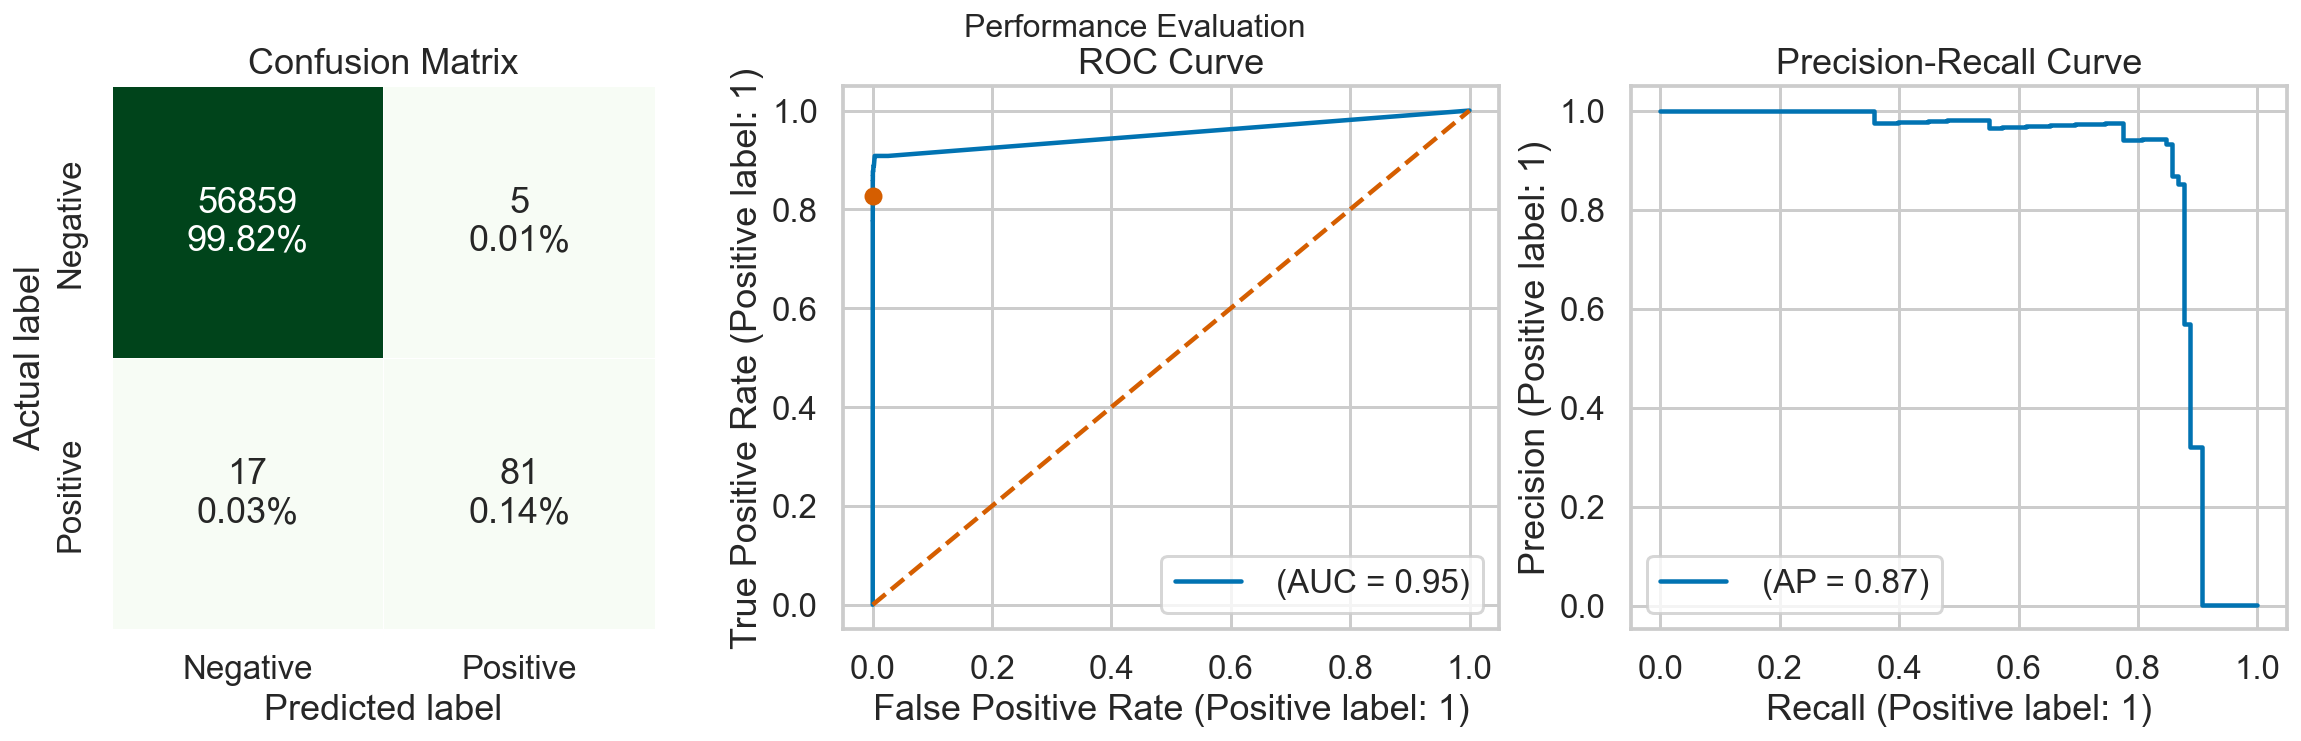

In [8]:
rf_perf = performance_evaluation_report(rf, X_test, y_test, 
                                        show_plot=True, 
                                        show_pr_curve=True)

In [9]:
rf_perf

{'accuracy': 0.9996137776061234,
 'precision': 0.9418604651162791,
 'recall': 0.826530612244898,
 'specificity': 0.9999120709060214,
 'f1_score': 0.8804347826086957,
 'cohens_kappa': 0.8802421830263933,
 'matthews_corr_coeff': 0.8821262209352536,
 'roc_auc': 0.9528106983508091,
 'pr_auc': 0.8761066379655765,
 'average_precision': 0.8715308673031336}

5. Undersample the training data and train a Random Forest Classifier:

The new class proportions are: {0: 394, 1: 394}


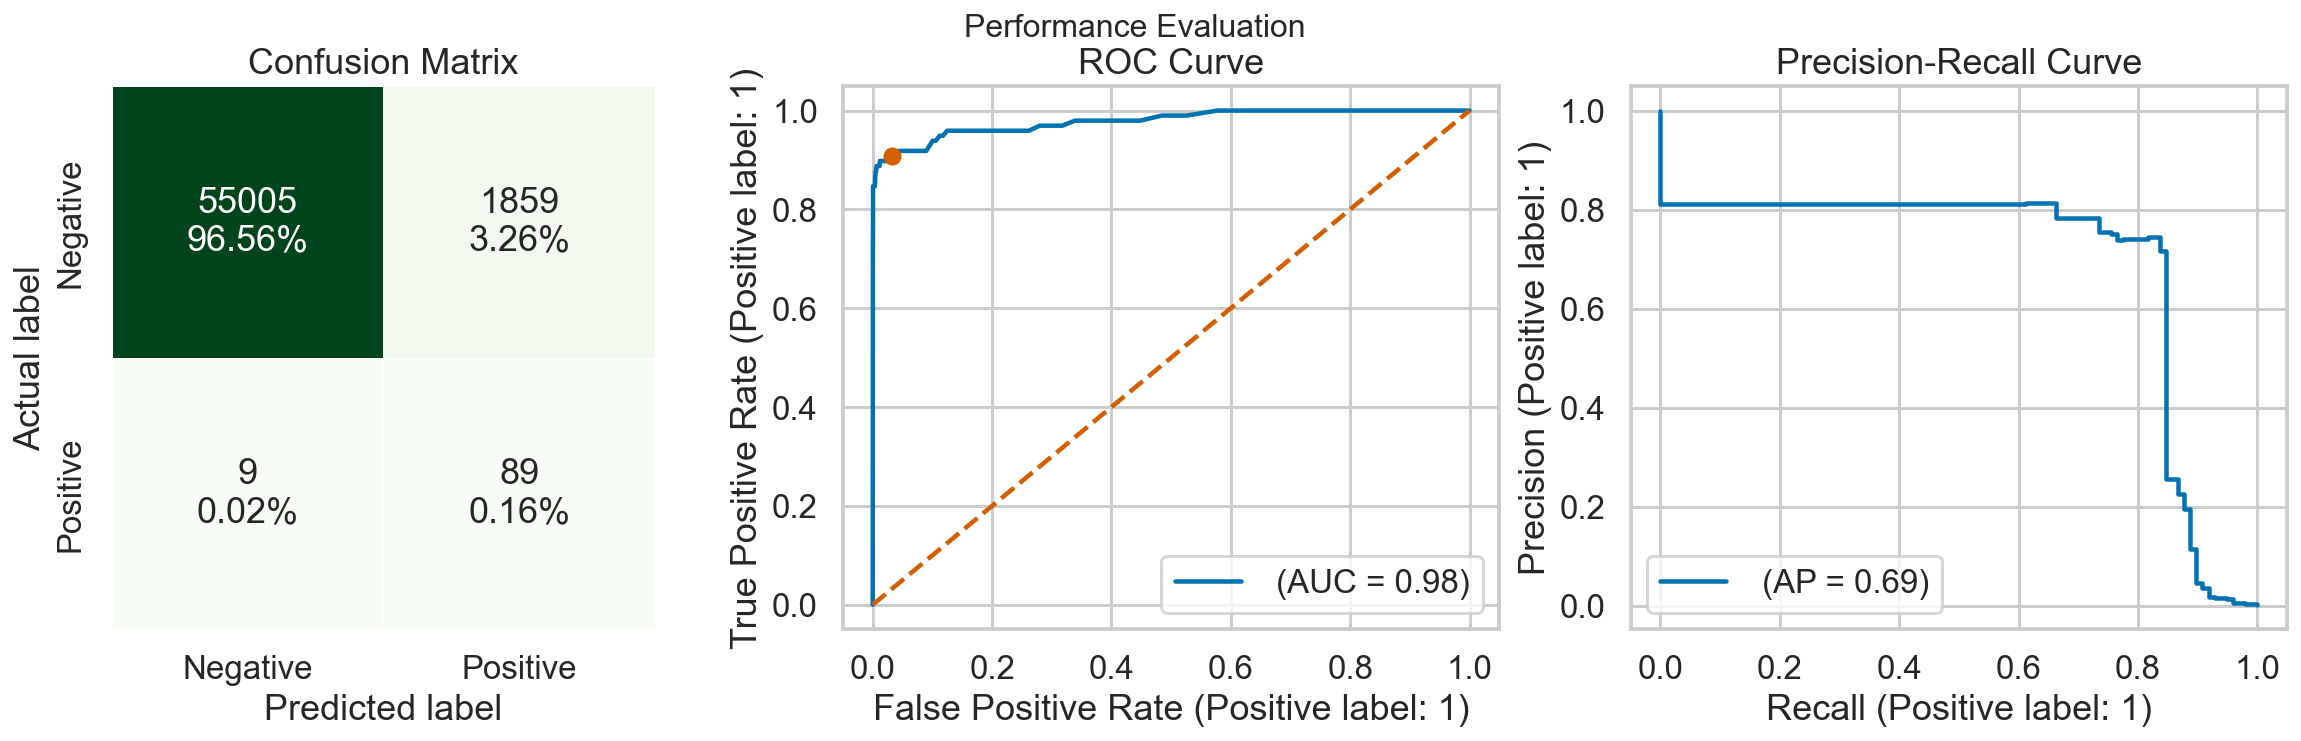

In [10]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f"The new class proportions are: {dict(Counter(y_rus))}")

rf.fit(X_rus, y_rus)
rf_rus_perf = performance_evaluation_report(rf, X_test, y_test, 
                                            show_plot=True, 
                                            show_pr_curve=True)

In [11]:
rf_rus_perf

{'accuracy': 0.9672062076472034,
 'precision': 0.04568788501026694,
 'recall': 0.9081632653061225,
 'specificity': 0.9673079628587508,
 'f1_score': 0.08699902248289346,
 'cohens_kappa': 0.08399812937820073,
 'matthews_corr_coeff': 0.1996376876508488,
 'roc_auc': 0.9779785173073169,
 'pr_auc': 0.7493412931297654,
 'average_precision': 0.6893877685200549}

6. Oversample the training data and train a Random Forest Classifier:

The new class proportions are: {0: 227451, 1: 227451}


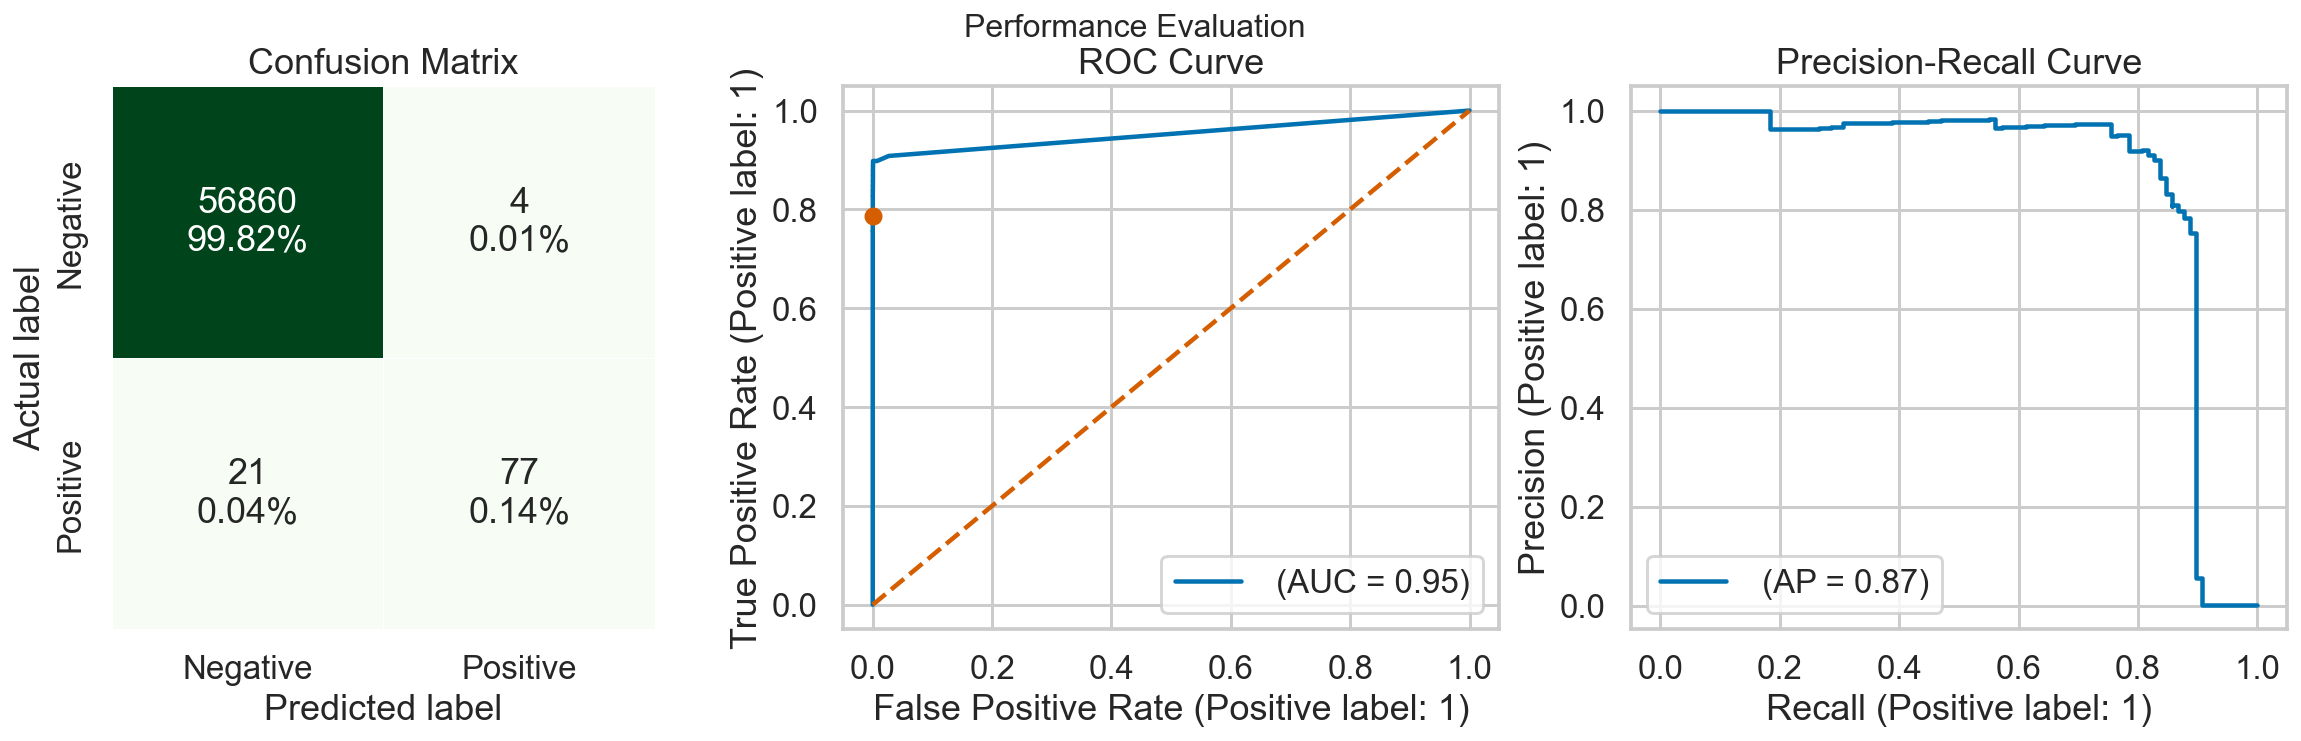

In [12]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(f"The new class proportions are: {dict(Counter(y_ros))}")

rf.fit(X_ros, y_ros)
rf_ros_perf = performance_evaluation_report(rf, X_test, y_test, 
                                            show_plot=True, 
                                            show_pr_curve=True)


In [13]:
rf_ros_perf

{'accuracy': 0.9995611109160493,
 'precision': 0.9506172839506173,
 'recall': 0.7857142857142857,
 'specificity': 0.9999296567248172,
 'f1_score': 0.8603351955307262,
 'cohens_kappa': 0.8601173911787858,
 'matthews_corr_coeff': 0.8640351019464072,
 'roc_auc': 0.9526220096930161,
 'pr_auc': 0.8694354919814588,
 'average_precision': 0.8650269303457705}

7. Oversample the training data using SMOTE:

The new class proportions are: {0: 227451, 1: 227451}


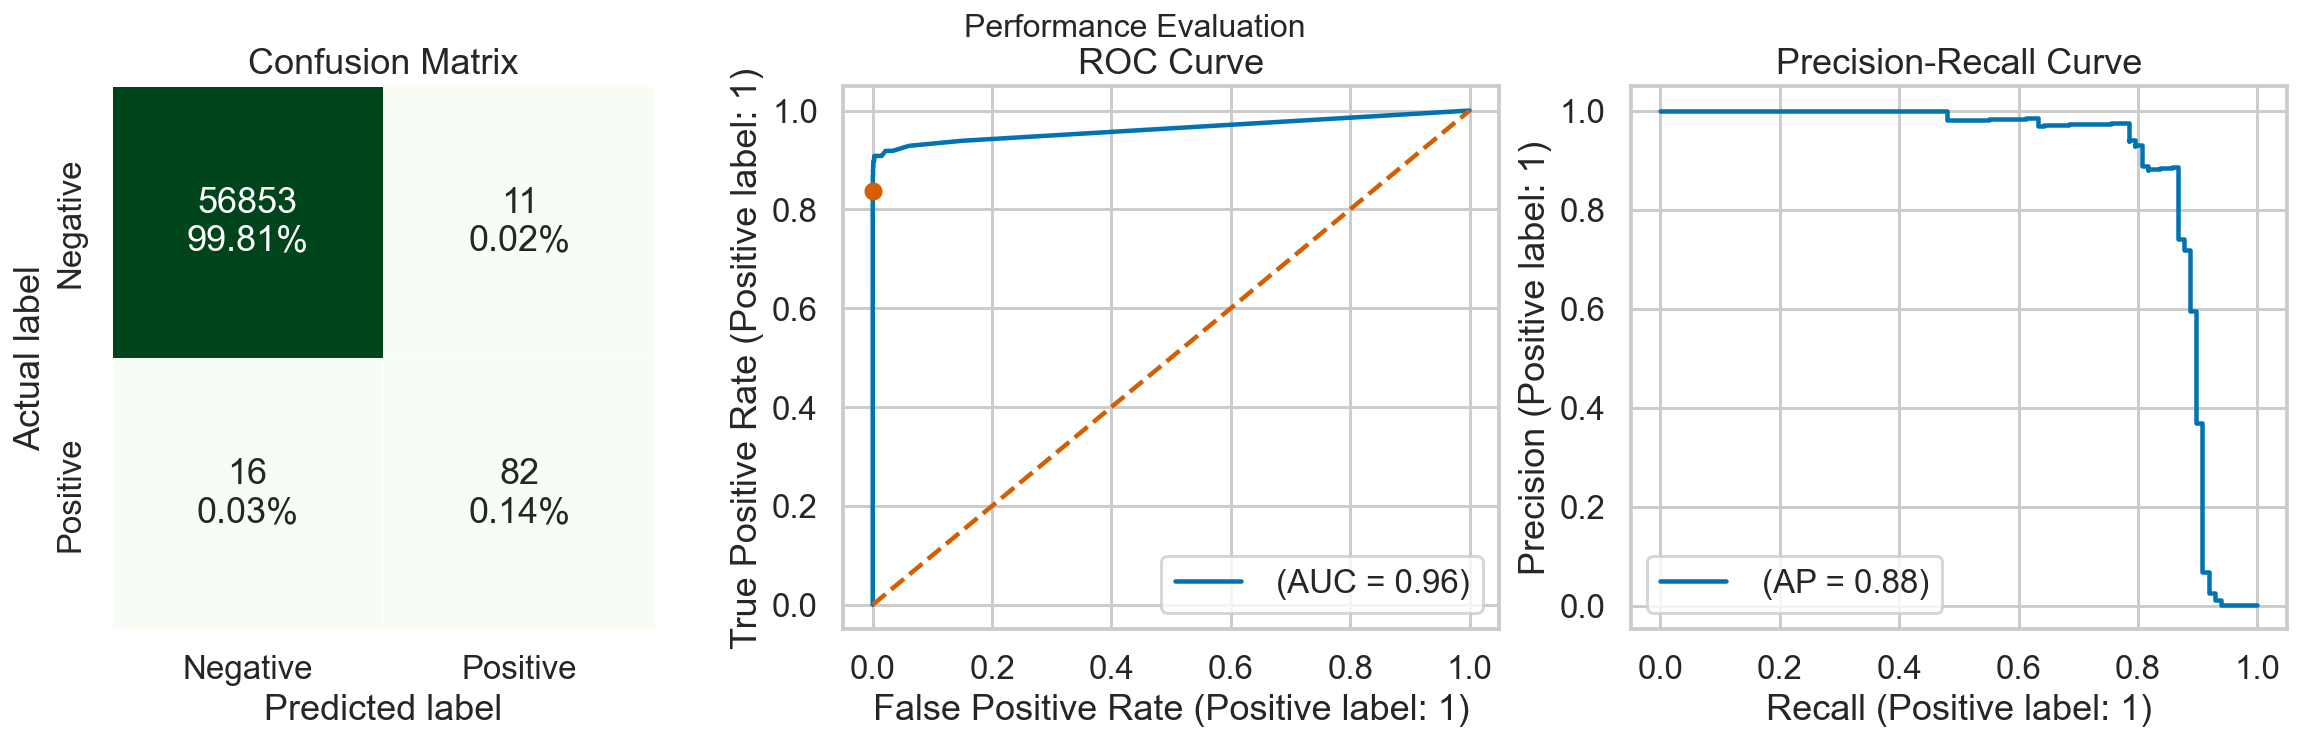

In [14]:
smote = SMOTE(random_state=RANDOM_STATE)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print(f"The new class proportions are: {dict(Counter(y_smote))}")

rf.fit(X_smote, y_smote)
rf_smote_perf = performance_evaluation_report(
    rf, X_test, y_test, 
    show_plot=True, 
    show_pr_curve=True
)


In [15]:
rf_smote_perf

{'accuracy': 0.9995259997893332,
 'precision': 0.8817204301075269,
 'recall': 0.8367346938775511,
 'specificity': 0.9998065559932471,
 'f1_score': 0.8586387434554974,
 'cohens_kappa': 0.8584015082980144,
 'matthews_corr_coeff': 0.8586967748445028,
 'roc_auc': 0.9630224962100766,
 'pr_auc': 0.8791097391338298,
 'average_precision': 0.877909842029142}

8. Oversample the training data using ADASYN:

The new class proportions are: {0: 227451, 1: 227449}


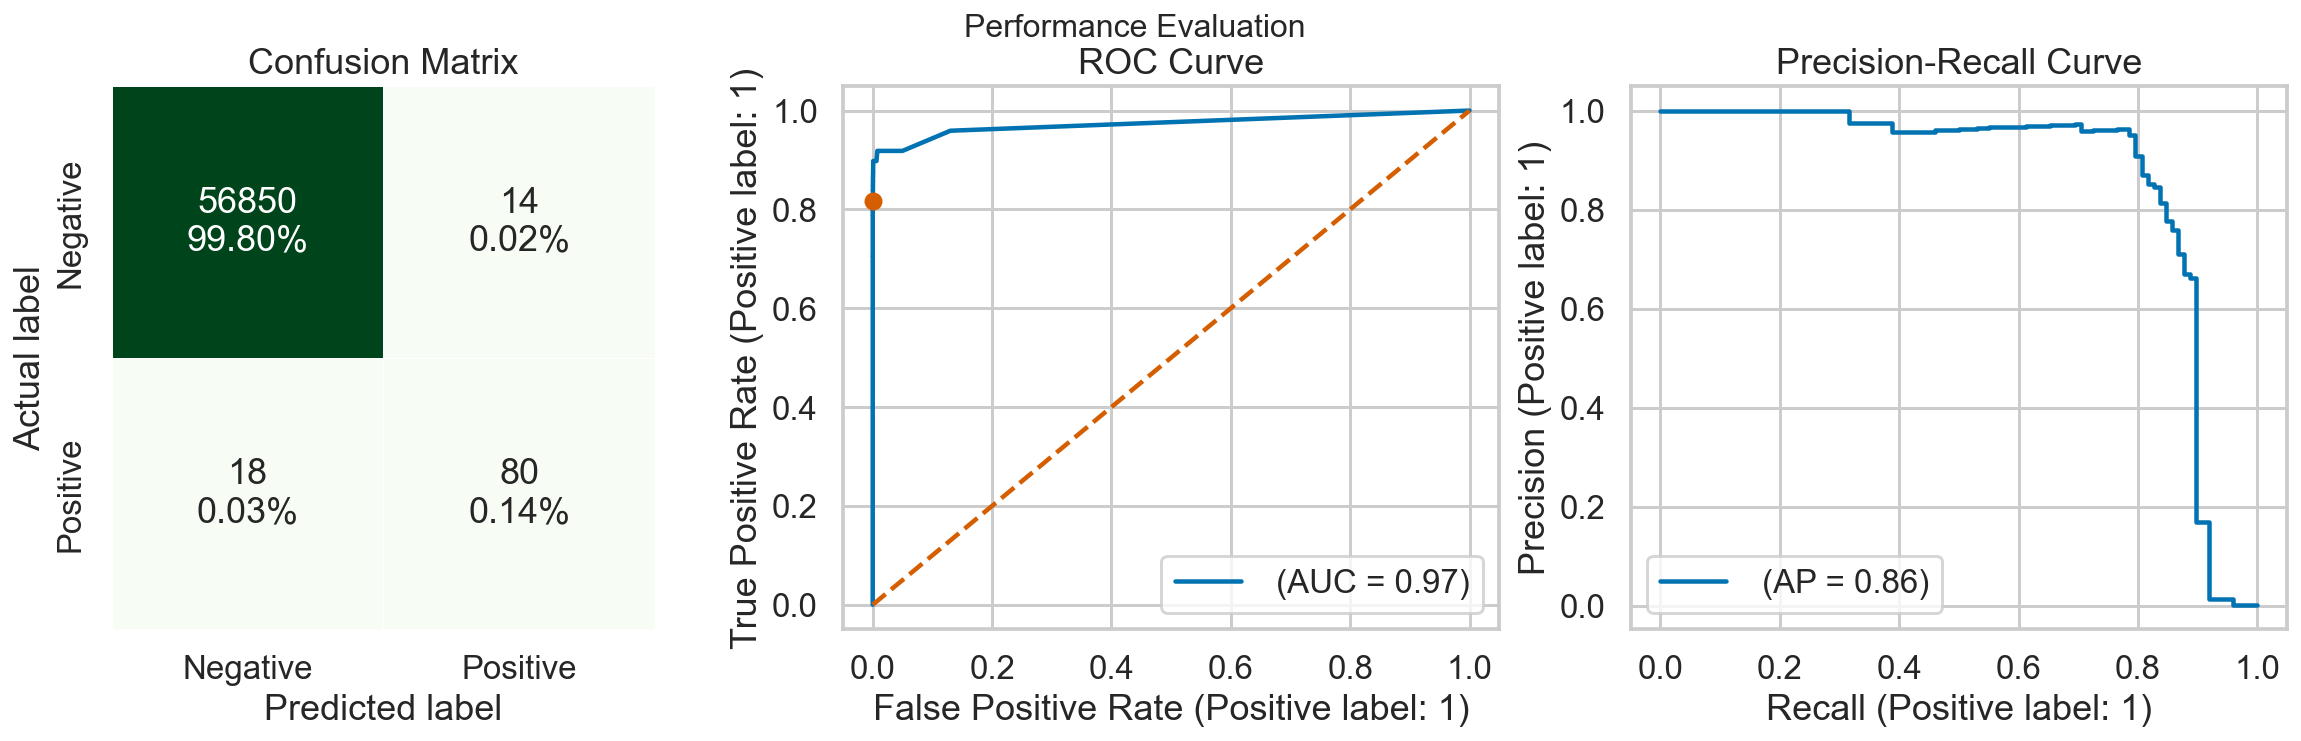

In [16]:
adasyn = ADASYN(random_state=RANDOM_STATE)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
print(f"The new class proportions are: {dict(Counter(y_adasyn))}")

rf.fit(X_adasyn, y_adasyn)
rf_adasyn_perf = performance_evaluation_report(
    rf, X_test, y_test, 
    show_plot=True, 
    show_pr_curve=True
)

In [17]:
rf_adasyn_perf

{'accuracy': 0.9994382219725431,
 'precision': 0.851063829787234,
 'recall': 0.8163265306122449,
 'specificity': 0.9997537985368599,
 'f1_score': 0.8333333333333334,
 'cohens_kappa': 0.8330520924541228,
 'matthews_corr_coeff': 0.83323354623757,
 'roc_auc': 0.9730570900279076,
 'pr_auc': 0.8661090014090018,
 'average_precision': 0.8634501529350331}

9. Use sample weights in the Random Forest Classifier:

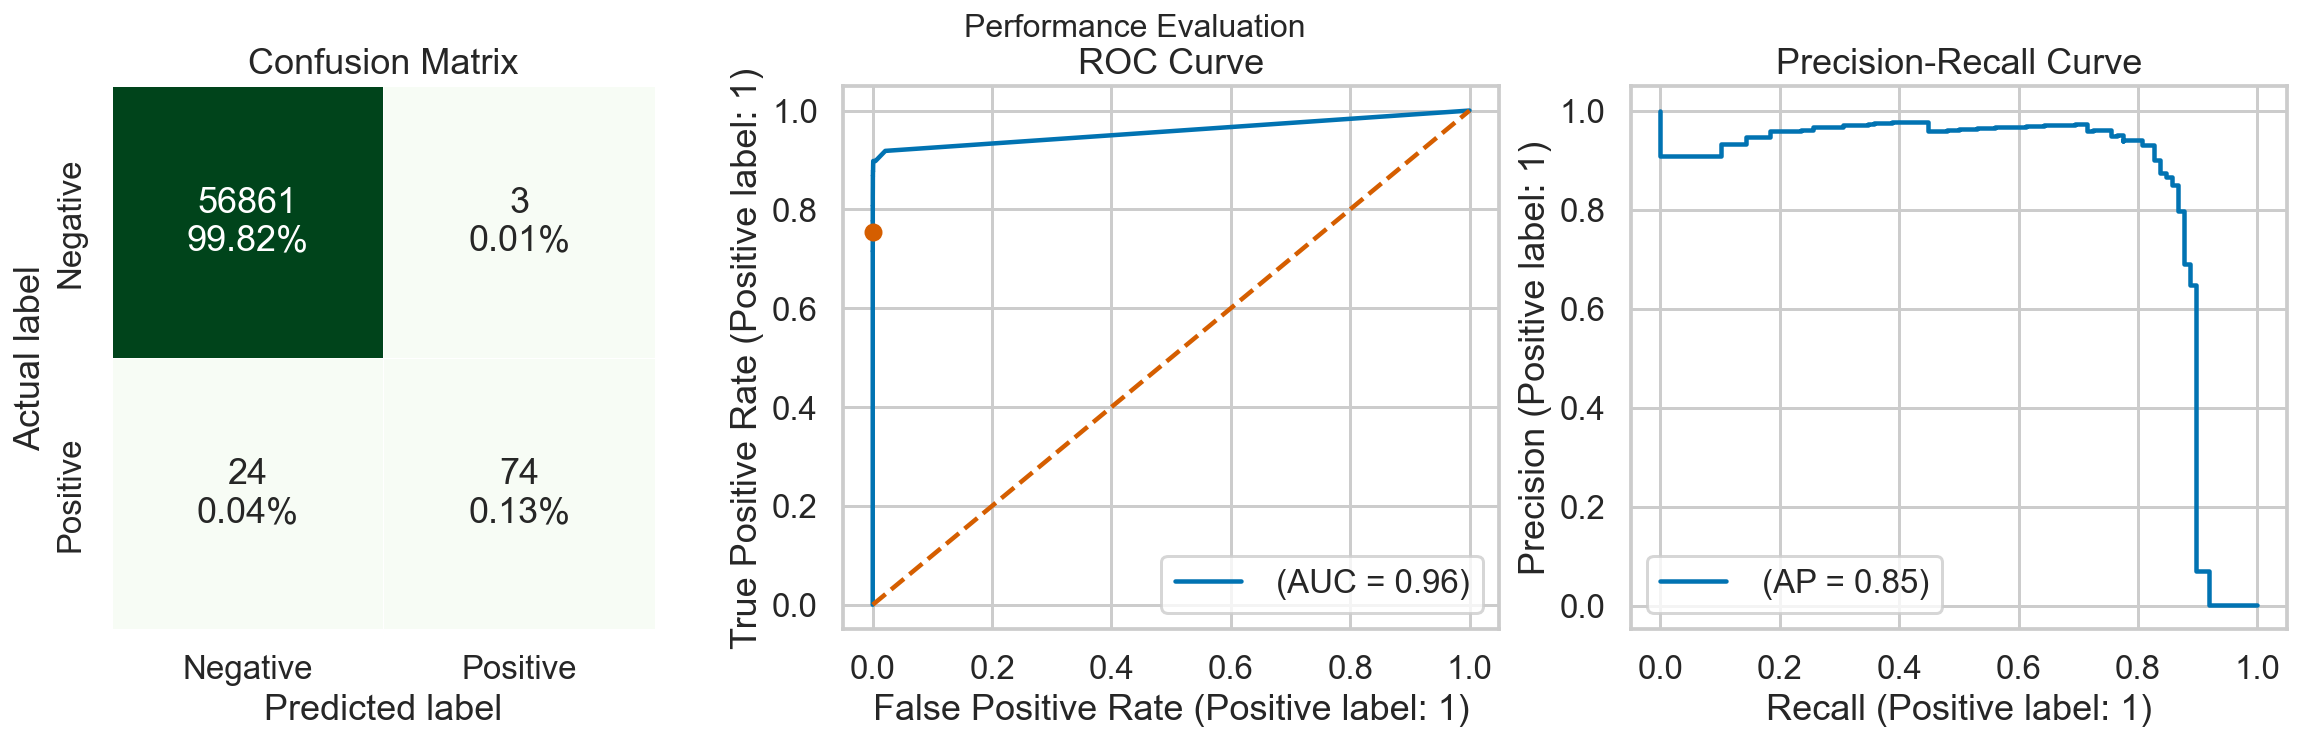

In [18]:
rf_cw = RandomForestClassifier(random_state=RANDOM_STATE, 
                               class_weight="balanced",
                               n_jobs=-1)
rf_cw.fit(X_train, y_train)

rf_cw_perf = performance_evaluation_report(
    rf_cw, X_test, y_test, 
    show_plot=True, 
    show_pr_curve=True
)

In [19]:
rf_cw_perf

{'accuracy': 0.9995259997893332,
 'precision': 0.961038961038961,
 'recall': 0.7551020408163265,
 'specificity': 0.9999472425436128,
 'f1_score': 0.8457142857142858,
 'cohens_kappa': 0.8454803442249764,
 'matthews_corr_coeff': 0.8516532279164988,
 'roc_auc': 0.9580099995119038,
 'pr_auc': 0.8571566165109122,
 'average_precision': 0.8482798270370951}

10. Train the `BalancedRandomForestClassifier`:

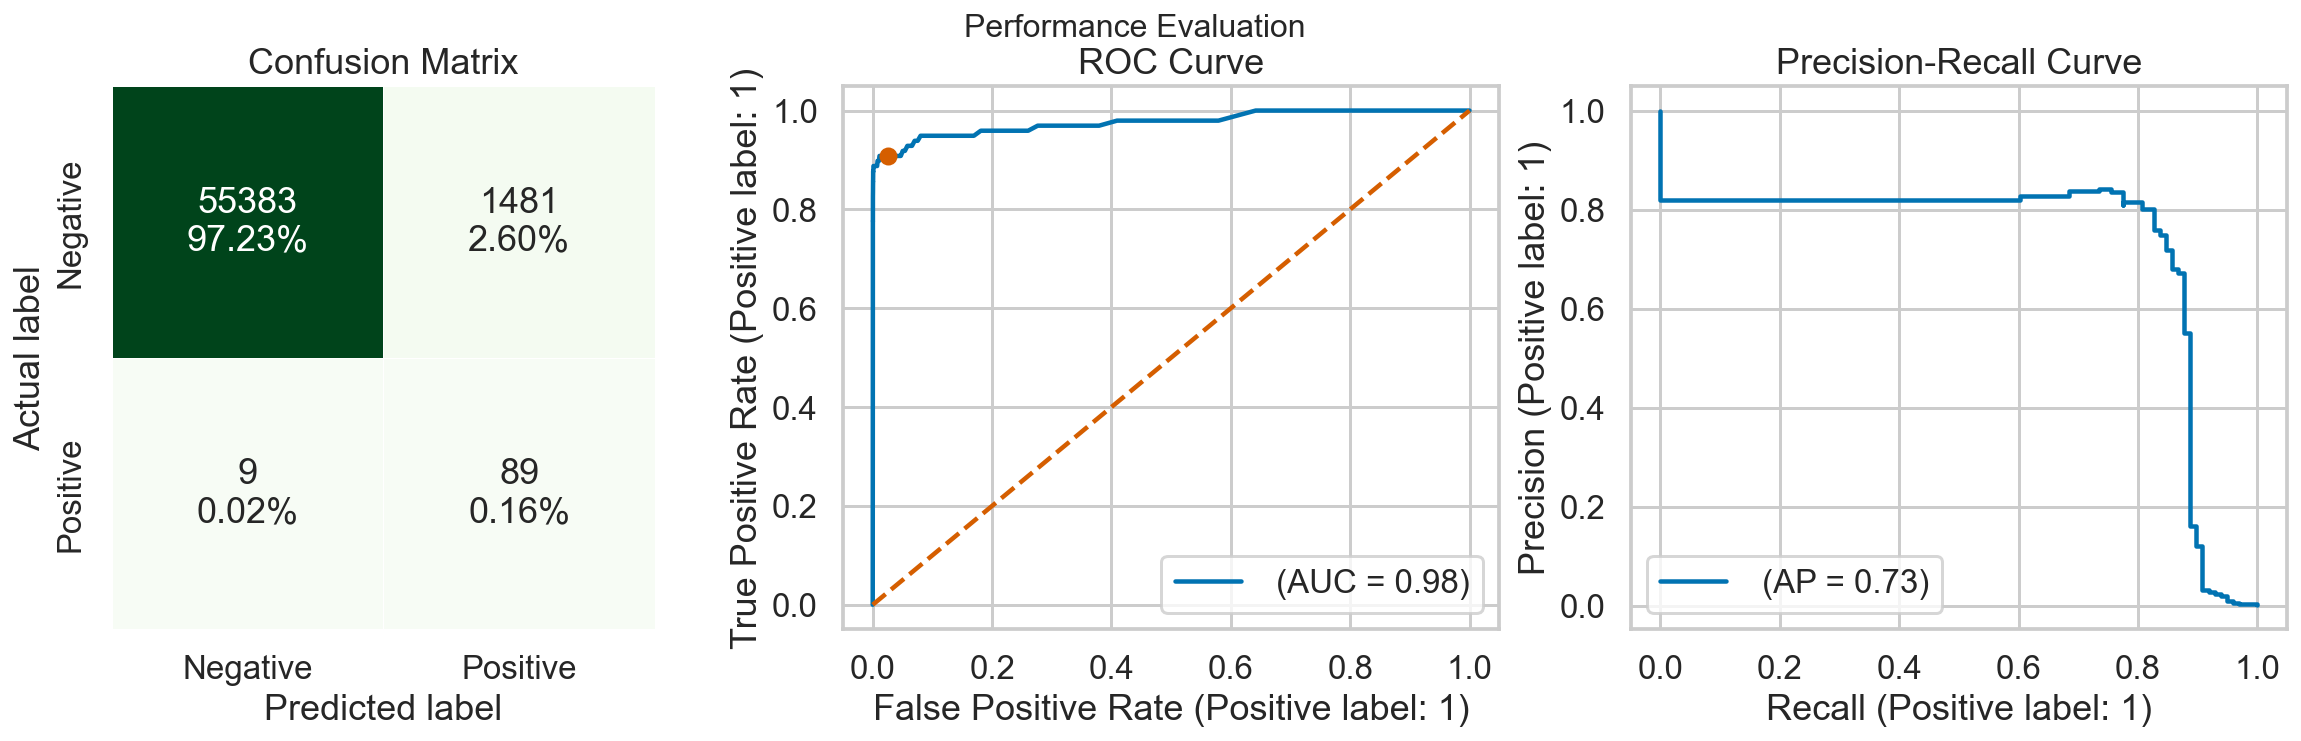

In [20]:
balanced_rf = BalancedRandomForestClassifier(
    random_state=RANDOM_STATE
)

balanced_rf.fit(X_train, y_train)
balanced_rf_perf = performance_evaluation_report(
    balanced_rf, X_test, y_test, 
    show_plot=True, 
    show_pr_curve=True
)

11. Train the `BalancedRandomForestClassifier` with balanced classes:

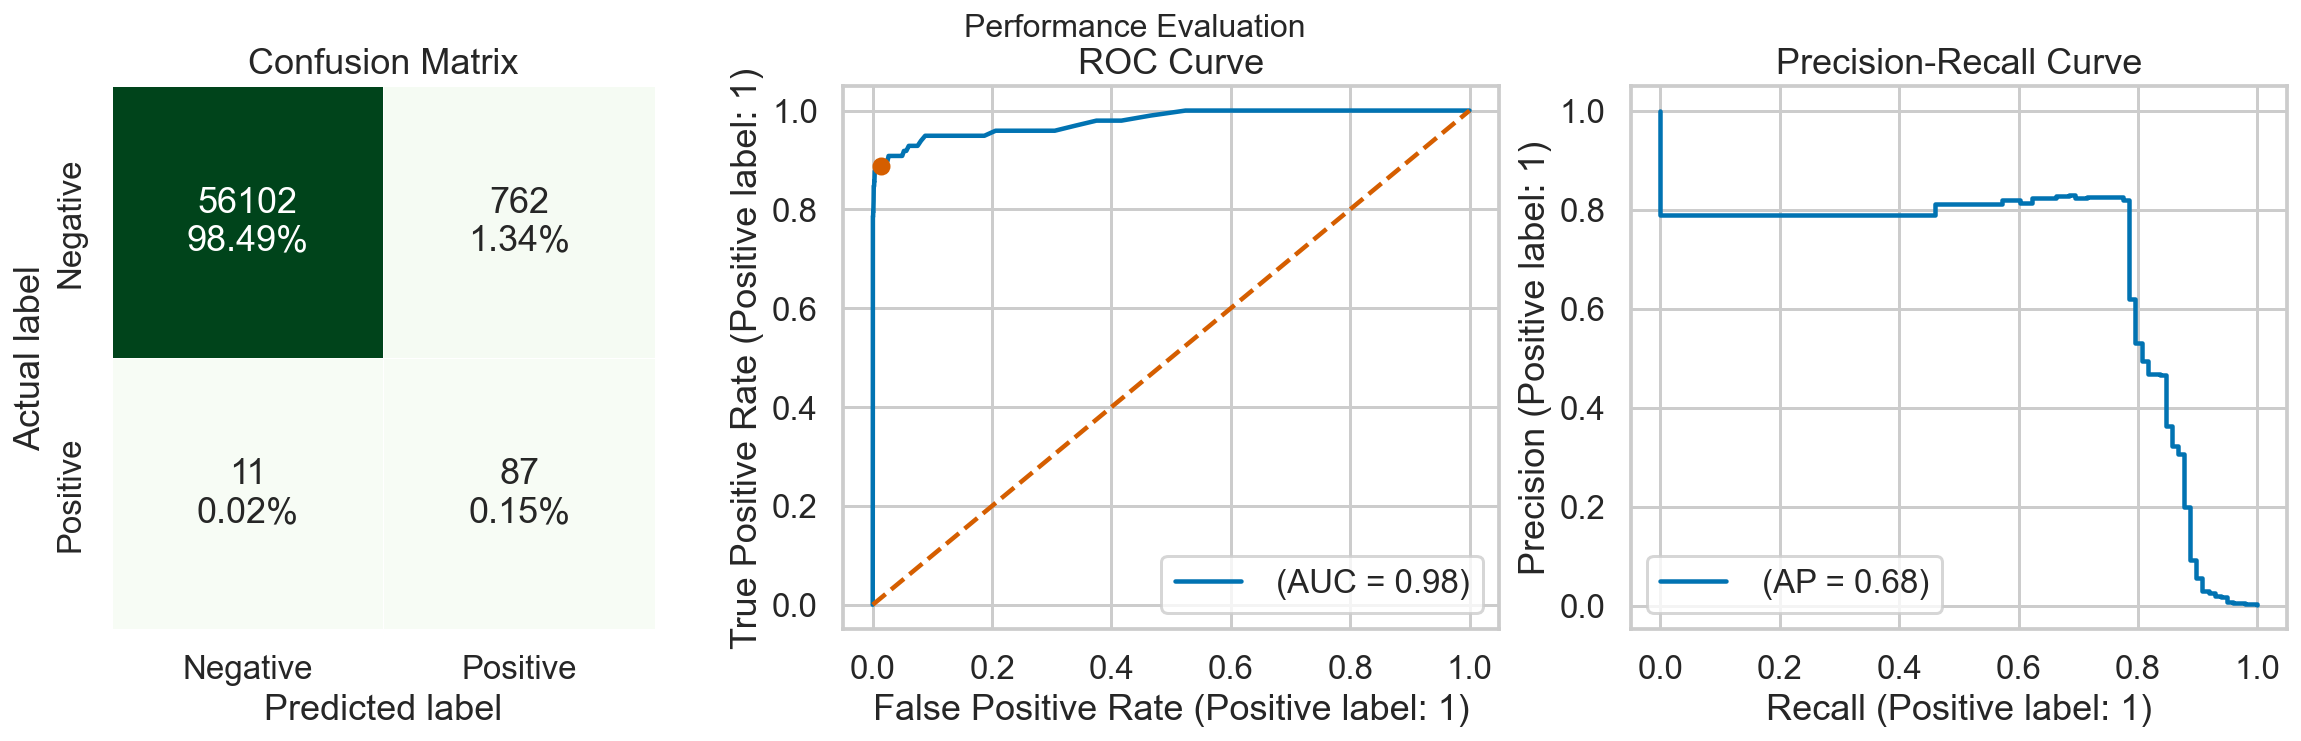

In [21]:
balanced_rf_cw = BalancedRandomForestClassifier(
    random_state=RANDOM_STATE, 
    class_weight="balanced",
    n_jobs=-1
)

balanced_rf_cw.fit(X_train, y_train)
balanced_rf_cw_perf = performance_evaluation_report(
    balanced_rf_cw, X_test, y_test, 
    show_plot=True, 
    show_pr_curve=True
)

12. Combine the results in a DataFrame:

In [22]:
performance_results = {
    "random_forest": rf_perf,
    "undersampled rf": rf_rus_perf,
    "oversampled_rf": rf_ros_perf,
    "smote": rf_smote_perf,
    "adasyn": rf_adasyn_perf,
    "random_forest_cw": rf_cw_perf,
    "balanced_random_forest": balanced_rf_perf,
    "balanced_random_forest_cw": balanced_rf_cw_perf,
}                       
pd.DataFrame(performance_results).round(4).T

accuracy  precision  recall  specificity  f1_score  \
random_forest                0.9996     0.9419  0.8265       0.9999    0.8804   
undersampled rf              0.9672     0.0457  0.9082       0.9673    0.0870   
oversampled_rf               0.9996     0.9506  0.7857       0.9999    0.8603   
smote                        0.9995     0.8817  0.8367       0.9998    0.8586   
adasyn                       0.9994     0.8511  0.8163       0.9998    0.8333   
random_forest_cw             0.9995     0.9610  0.7551       0.9999    0.8457   
balanced_random_forest       0.9738     0.0567  0.9082       0.9740    0.1067   
balanced_random_forest_cw    0.9864     0.1025  0.8878       0.9866    0.1837   

                           cohens_kappa  matthews_corr_coeff  roc_auc  pr_auc  \
random_forest                    0.8802               0.8821   0.9528  0.8761   
undersampled rf                  0.0840               0.1996   0.9780  0.7493   
oversampled_rf                   0.8601               0.8640   0.9526  0.8694   
smote                            0.8584               0.8587   0.9630  0.8791   
adasyn                           0.8331               0.8332   0.9731  0.8661   
random_forest_cw                 0.8455               0.8517   0.9580  0.8572   
balanced_random_forest           0.1038               0.2233   0.9761  0.7800   
balanced_random_forest_cw        0.1812               0.2990   0.9780  0.7240   

                           average_precision  
random_forest                         0.8715  
undersampled rf                       0.6894  
oversampled_rf                        0.8650  
smote                                 0.8779  
adasyn                                0.8635  
random_forest_cw                      0.8483  
balanced_random_forest                0.7253  
balanced_random_forest_cw             0.6759

## 14.4 Leveraging the wisdom of the crowds with stacked ensembles

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold)
from sklearn.metrics import recall_score
from sklearn.preprocessing import RobustScaler

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

2. Load and preprocess data:

In [4]:
RANDOM_STATE = 42

df = pd.read_csv("../Datasets/credit_card_fraud.csv")

X = df.copy().drop(columns=["Time"])
y = X.pop("Class")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

robust_scaler = RobustScaler()
X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)

3. Define a list of base models:

In [5]:
base_models = [
    ("dec_tree", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ("log_reg", LogisticRegression(random_state=RANDOM_STATE)),
    ("svc", SVC(random_state=RANDOM_STATE)),   
    # ("knn", KNeighborsClassifier()),
    ("naive_bayes", GaussianNB())
]

4. Train the selected models and calculate recall using the test set:

In [6]:
for model_tuple in base_models:
    clf = model_tuple[1]
    if "n_jobs" in clf.get_params().keys():
        clf.set_params(n_jobs=-1)
    clf.fit(X_train, y_train)
    recall = recall_score(y_test, clf.predict(X_test))
    print(f"{model_tuple[0]}'s recall score: {recall:.4f}")

dec_tree's recall score: 0.7551
log_reg's recall score: 0.6531
svc's recall score: 0.7041
naive_bayes's recall score: 0.8469


5. Define, fit and evaluate the stacked ensemble:

In [7]:
cv_scheme = StratifiedKFold(n_splits=5, 
                            shuffle=True, 
                            random_state=RANDOM_STATE)
meta_model = LogisticRegression(random_state=RANDOM_STATE)

stack_clf = StackingClassifier(
    base_models, 
    final_estimator=meta_model,
    cv=cv_scheme,
    n_jobs=-1
)
stack_clf.fit(X_train, y_train)

recall = recall_score(y_test, stack_clf.predict(X_test))
print(f"The stacked ensemble's recall score: {recall:.4f}")

The stacked ensemble's recall score: 0.7449


6. Improve the stacking ensemble with additional features and a more complex meta model:

In [8]:
meta_model = RandomForestClassifier(random_state=RANDOM_STATE)
stack_clf = StackingClassifier(
    base_models, 
    final_estimator=meta_model,
    cv=cv_scheme,
    passthrough=True,
    n_jobs=-1
)
stack_clf.fit(X_train, y_train)

recall = recall_score(y_test, stack_clf.predict(X_test))
print(f"The stacked ensemble's recall score: {recall:.4f}")

The stacked ensemble's recall score: 0.8571


### There's more

In [10]:
level_0_names = [f"{model[0]}_pred" for model in base_models]

level_0_df = pd.DataFrame(
    stack_clf.transform(X_train), 
    columns=level_0_names + list(X.columns)
)

level_0_df.head()

dec_tree_pred  log_reg_pred  svc_pred  naive_bayes_pred        V1  \
0            0.0      0.000067 -1.042724      3.814708e-18  0.862468   
1            0.0      0.000197 -1.011043      4.686999e-17  0.902013   
2            0.0      0.000105 -1.064856      1.901214e-08 -0.452072   
3            0.0      0.000018 -1.064256      2.215227e-17  1.014098   
4            0.0      0.000041 -1.061369      3.443033e-17 -0.209097   

         V2        V3        V4        V5        V6  ...       V20       V21  \
0 -0.582668 -0.800214 -0.402839  1.195050  3.686711  ... -0.208591  0.254397   
1 -0.081009 -1.688308  0.169440  2.300397  3.063923  ... -0.478210  0.163787   
2  0.383882  0.277401 -0.610965 -0.591610  1.912709  ...  3.901408 -6.678665   
3 -1.115745 -0.483481 -1.036093 -1.027641 -0.065331  ... -1.243014 -0.266247   
4 -0.767259 -0.033341 -2.160256  0.591186  0.108623  ... -0.617654 -0.516058   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.271818  1.030294  0.819092 -0.549496 -0.594515  0.470469 -0.331702   
1  0.207035  0.150314  0.839386  0.745071 -0.739565  0.006529 -0.612163   
2  0.096163 -1.374858 -1.226469  1.215686  1.701658  0.225951  1.328659   
3  0.065787  0.708492 -0.729414 -0.441090 -0.194677  0.102412 -0.566405   
4 -0.168076  0.013861 -1.767632 -0.462389 -0.163925 -0.210247 -0.575473   

     Amount  
0 -0.204315  
1 -0.264579  
2  2.130828  
3 -0.221294  
4  0.892136  

[5 rows x 33 columns]

In [ ]:
level_0_df[level_0_names].describe().T

## 14.5 Bayesian hyperparameter optimization

### How to do it...

1. Load the libraries:

In [3]:
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import (cross_val_score, 
                                     StratifiedKFold)
from lightgbm import LGBMClassifier

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample

from chapter_14_utils import performance_evaluation_report

2. Define parameters for later use:

In [4]:
N_FOLDS = 5
MAX_EVALS = 200
RANDOM_STATE = 42
EVAL_METRIC = "recall"
DEBUG = False

3. Load and prepare the data:

In [5]:
df = pd.read_csv("../Datasets/credit_card_fraud.csv")

X = df.copy().drop(columns=["Time"])
y = X.pop("Class")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

4. Train the benchmark LightGBM model with the default hyperparameters:

In [ ]:
clf = LGBMClassifier(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

benchmark_perf = performance_evaluation_report(
    clf, X_test, y_test, 
    show_plot=True, 
    show_pr_curve=True
)
print(f'Recall: {benchmark_perf["recall"]:.4f}')

sns.despine()
# plt.savefig("images/figure_14_18", dpi=200)

5. Define the objective function:

In [ ]:
def objective(params, n_folds=N_FOLDS, 
              random_state=RANDOM_STATE, 
              metric=EVAL_METRIC):
    
    # useful for debugging
    if DEBUG:
        print(params)
    
    model = LGBMClassifier(**params, random_state=random_state)
    k_fold = StratifiedKFold(n_folds, shuffle=True, 
                             random_state=random_state)

    scores = cross_val_score(model, X_train, y_train, 
                             cv=k_fold, scoring=metric)
    loss = -1 * scores.mean()
    
    return {"loss": loss, "params": params, "status": STATUS_OK}

6. Define the search space:

In [ ]:
search_space = {
    "n_estimators": hp.choice("n_estimators", [50, 100, 250, 500]),
    "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"]),
    "is_unbalance": hp.choice("is_unbalance", [True, False]),
    "max_depth": scope.int(hp.uniform("max_depth", 3, 20)),
    "num_leaves": scope.int(hp.quniform("num_leaves", 5, 100, 1)),
    "min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 5)),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.3, 1.0),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
}

In [ ]:
sample(search_space)

7. Find the best hyperparameters using Bayesian HPO:

In [ ]:
trials = Trials()
best_set = fmin(fn= objective,
                space= search_space,
                algo= tpe.suggest,
                max_evals = MAX_EVALS,
                trials= trials,
                rstate=np.random.default_rng(RANDOM_STATE))

In [ ]:
# store the results in a pickle
pickle.dump(trials, open("light_gbm_200_runs.p", "wb"))

8. Inspect the best set of hyperparameters:

In [ ]:
space_eval(search_space , best_set)

In [ ]:
best_set

9. Fit a new model using the best hyperparameters:

In [ ]:
tuned_lgbm = LGBMClassifier(
    **space_eval(search_space , best_set),
    random_state=RANDOM_STATE
)
tuned_lgbm.fit(X_train, y_train)

10. Evaluate the fitted model on the test set:

In [ ]:
tuned_perf = performance_evaluation_report(
    tuned_lgbm, X_test, y_test, 
    show_plot=True, 
    show_pr_curve=True
)

print(f'Recall: {tuned_perf["recall"]:.4f}')

sns.despine()
# plt.savefig("images/figure_14_19", dpi=200)

### There's more

#### Conditional hyperparameter space

1. Define a conditional hyperparameter space:

In [ ]:
conditional_search_space = {
    "boosting_type": hp.choice("boosting_type", [
        {"boosting_type": "gbdt", 
         "subsample": hp.uniform("gdbt_subsample", 0.5, 1),
         "subsample_freq": scope.int(hp.uniform("gdbt_subsample_freq", 1, 20))}, 
        {"boosting_type": "dart",
         "subsample": hp.uniform("dart_subsample", 0.5, 1),
         "subsample_freq": scope.int(hp.uniform("dart_subsample_freq", 1, 20))},
        # {"boosting_type": "rf",
        #  "subsample": hp.uniform("rf_subsample", 0.5, 1),
        #  "subsample_freq": scope.int(hp.uniform("rf_subsample_freq", 1, 20))},
        {"boosting_type": "goss",
         "subsample": 1.0,
         "subsample_freq": 0},
    ]),
    "n_estimators": hp.choice("n_estimators", [50, 100, 250, 500]),
    "is_unbalance": hp.choice("is_unbalance", [True, False]),
    "max_depth": scope.int(hp.uniform("max_depth", 3, 20)),
    "num_leaves": scope.int(hp.quniform("num_leaves", 5, 100, 1)),
    "min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 5)),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.3, 1.0),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
}

In [ ]:
# draw from the search space
params = sample(conditional_search_space)
params

In [ ]:
# retrieve the conditional parameters, set to default if missing
subsample = params["boosting_type"].get("subsample", 1.0)
subsample_freq = params["boosting_type"].get("subsample_freq", 0)

# fill in the params dict with the conditional values
params["boosting_type"] = params["boosting_type"]["boosting_type"]
params["subsample"] = subsample
params["subsample_freq"] = subsample_freq

params

2. Modify the objective function to account for the conditional hyperparameter space:

In [ ]:
def modified_objective(params, n_folds=N_FOLDS, random_state=RANDOM_STATE, metric=EVAL_METRIC):
           
    # retrieve the conditional parameters, set to default if missing
    subsample = params["boosting_type"].get("subsample", 1.0)
    subsample_freq = params["boosting_type"].get("subsample_freq", 0)
    
    # fill in the params dict with the conditional values
    params["boosting_type"] = params["boosting_type"]["boosting_type"]
    params["subsample"] = subsample
    params["subsample_freq"] = subsample_freq

    # useful for debugging
    if DEBUG:
        print(params)
    
    model = LGBMClassifier(**params, random_state=random_state)
    k_fold = StratifiedKFold(n_folds, shuffle=True, 
                             random_state=random_state)

    scores = cross_val_score(model, X_train, y_train, 
                             cv=k_fold, scoring=metric)
    loss = -1 * scores.mean()
    
    return {"loss": loss, "params": params, "status": STATUS_OK}

3. Run the Bayesian HPO with the conditional hyperparam space:

In [ ]:
trials = Trials()
best_set_2 = fmin(fn= modified_objective,
                  space= conditional_search_space,
                  algo= tpe.suggest,
                  max_evals = MAX_EVALS,
                  trials= trials,
                  rstate=np.random.default_rng(RANDOM_STATE))

In [ ]:
# store the results in a pickle
pickle.dump(trials, open("light_gbm_200_runs_conditional_space.p", "wb"))

4. Inspect the best hyperparameters:

In [ ]:
space_eval(conditional_search_space , best_set_2)

5. Clean up the dictionary before training a model:

In [ ]:
best_params_2 = space_eval(conditional_search_space , best_set_2)

# retrieve the conditional parameters, set to default if missing
subsample = best_params_2["boosting_type"].get("subsample", 1.0)
subsample_freq = best_params_2["boosting_type"].get("subsample_freq", 0)

# fill in the best_params_2 dict with the conditional values
best_params_2["boosting_type"] = best_params_2["boosting_type"]["boosting_type"]
best_params_2["subsample"] = subsample
best_params_2["subsample_freq"] = subsample_freq

best_params_2

6. Train the tuned LightGBM classifier:

In [ ]:
tuned_lgbm_2 = LGBMClassifier(
    **best_params_2,
    random_state=RANDOM_STATE
)
tuned_lgbm_2.fit(X_train, y_train)

tuned_perf_2 = performance_evaluation_report(tuned_lgbm_2, X_test, y_test, 
                                           show_plot=True, 
                                           show_pr_curve=True)

print(f'Recall: {tuned_perf_2["recall"]:.4f}')

sns.despine()
# plt.savefig("images/figure_14_20", dpi=200)

#### A deep-dive into the explored hyperparameters

0. Load the trials file (if needed):

In [6]:

trials = pickle.load(open("light_gbm_200_runs.p", "rb"))

1. Import the additional libraries:

In [7]:
from pandas.io.json import json_normalize

2. Define a helper function for drawing samples from a hyperparameter search space:

In [8]:
def draw_samples(search_space, n_samples=10000):
    samples_list = []

    for _ in range(n_samples):
        samples_list.append(sample(search_space))

    return samples_list

3. Plot the distribution of the learning rate:

In [ ]:
lr_samples = draw_samples(search_space["learning_rate"])
    
sns.kdeplot(lr_samples, linewidth = 2, shade = True)
plt.title("Distribution of learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Density") 

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_21", dpi=200)

4. Create the KDE plot of `min_child_samples`: 

In [ ]:
mcs_samples = draw_samples(search_space["min_child_samples"])
    
sns.kdeplot(mcs_samples, linewidth = 2, shade = True)
plt.title("Distribution of min_child_samples")
plt.xlabel("min_child_samples")
plt.ylabel("Density") 

plt.tight_layout()
sns.despine()

5. Plot the distribution of `min_child_samples`: 

We could also use the `sns.countplot`, however, we only wanted to plot a restricted range of values to keep the plot readable.

In [ ]:
(
    pd.Series(mcs_samples)
    .value_counts()
    .sort_index()
    .head(20)
    .plot(kind="bar", 
          title="Distribution of min_child_samples")
);

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_22", dpi=200)

6. Store all the information from `trials.results` into a DataFrame:

In [11]:
results_df = pd.DataFrame(trials.results)
params_df = json_normalize(results_df["params"])
results_df = pd.concat([results_df.drop("params", axis=1), params_df], 
                       axis=1)
results_df["iteration"] = np.arange(len(results_df)) + 1
results_df.sort_values("loss")

loss status boosting_type  colsample_bytree  is_unbalance  \
150 -0.901071     ok          dart          0.876430          True   
168 -0.900941     ok          dart          0.946974          True   
167 -0.898475     ok          dart          0.951135          True   
34  -0.896040     ok          goss          0.307030          True   
155 -0.896008     ok          dart          0.901467          True   
..        ...    ...           ...               ...           ...   
6   -0.639695     ok          gbdt          0.393251         False   
52  -0.416326     ok          dart          0.841847         False   
164 -0.258845     ok          dart          0.921732         False   
199 -0.088608     ok          dart          0.993957         False   
181 -0.000000     ok          dart          0.837517         False   

     learning_rate  max_depth  min_child_samples  n_estimators  num_leaves  \
150       0.019246         19                160            50          16   
168       0.020825         18                235            50           8   
167       0.024895         18                135            50           8   
34        0.086375          3                415            50          82   
155       0.022619         17                135            50           5   
..             ...        ...                ...           ...         ...   
6         0.018363         19                265            50          13   
52        0.012526          6                320           100          73   
164       0.014171         18                110            50          25   
199       0.016164         15                210            50          54   
181       0.012799         15                160            50          23   

     reg_alpha  reg_lambda  iteration  
150   0.390232    0.483493        151  
168   0.366738    0.320576        169  
167   0.362945    0.418759        168  
34    0.236233    0.408269         35  
155   0.320720    0.482145        156  
..         ...         ...        ...  
6     0.996987    0.699079          7  
52    0.072400    0.769000         53  
164   0.049658    0.293709        165  
199   0.242146    0.560007        200  
181   0.428376    0.251945        182  

[200 rows x 13 columns]

7. Plot the prior distribution of `colsample_bytree` and the one used during the HPO:

In [ ]:
cbt_samples = draw_samples(search_space["colsample_bytree"])

fig, ax = plt.subplots(1, 2, figsize = (16, 8))

sns.kdeplot(cbt_samples, 
            label="Sampling Distribution", 
            ax=ax[0])
sns.kdeplot(results_df["colsample_bytree"], 
            label="Bayesian Optimization", 
            ax=ax[0])
ax[0].set(title="Distribution of colsample_bytree", 
          xlabel="Value",
          ylabel="Density")
ax[0].legend()

sns.regplot("iteration", "colsample_bytree", 
            data=results_df, ax=ax[1])
ax[1].set(title="colsample_bytree over Iterations", 
          xlabel="Iteration", 
          ylabel="Value")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_24", dpi=200)

8. Plot the distribution of `n_estimators`:

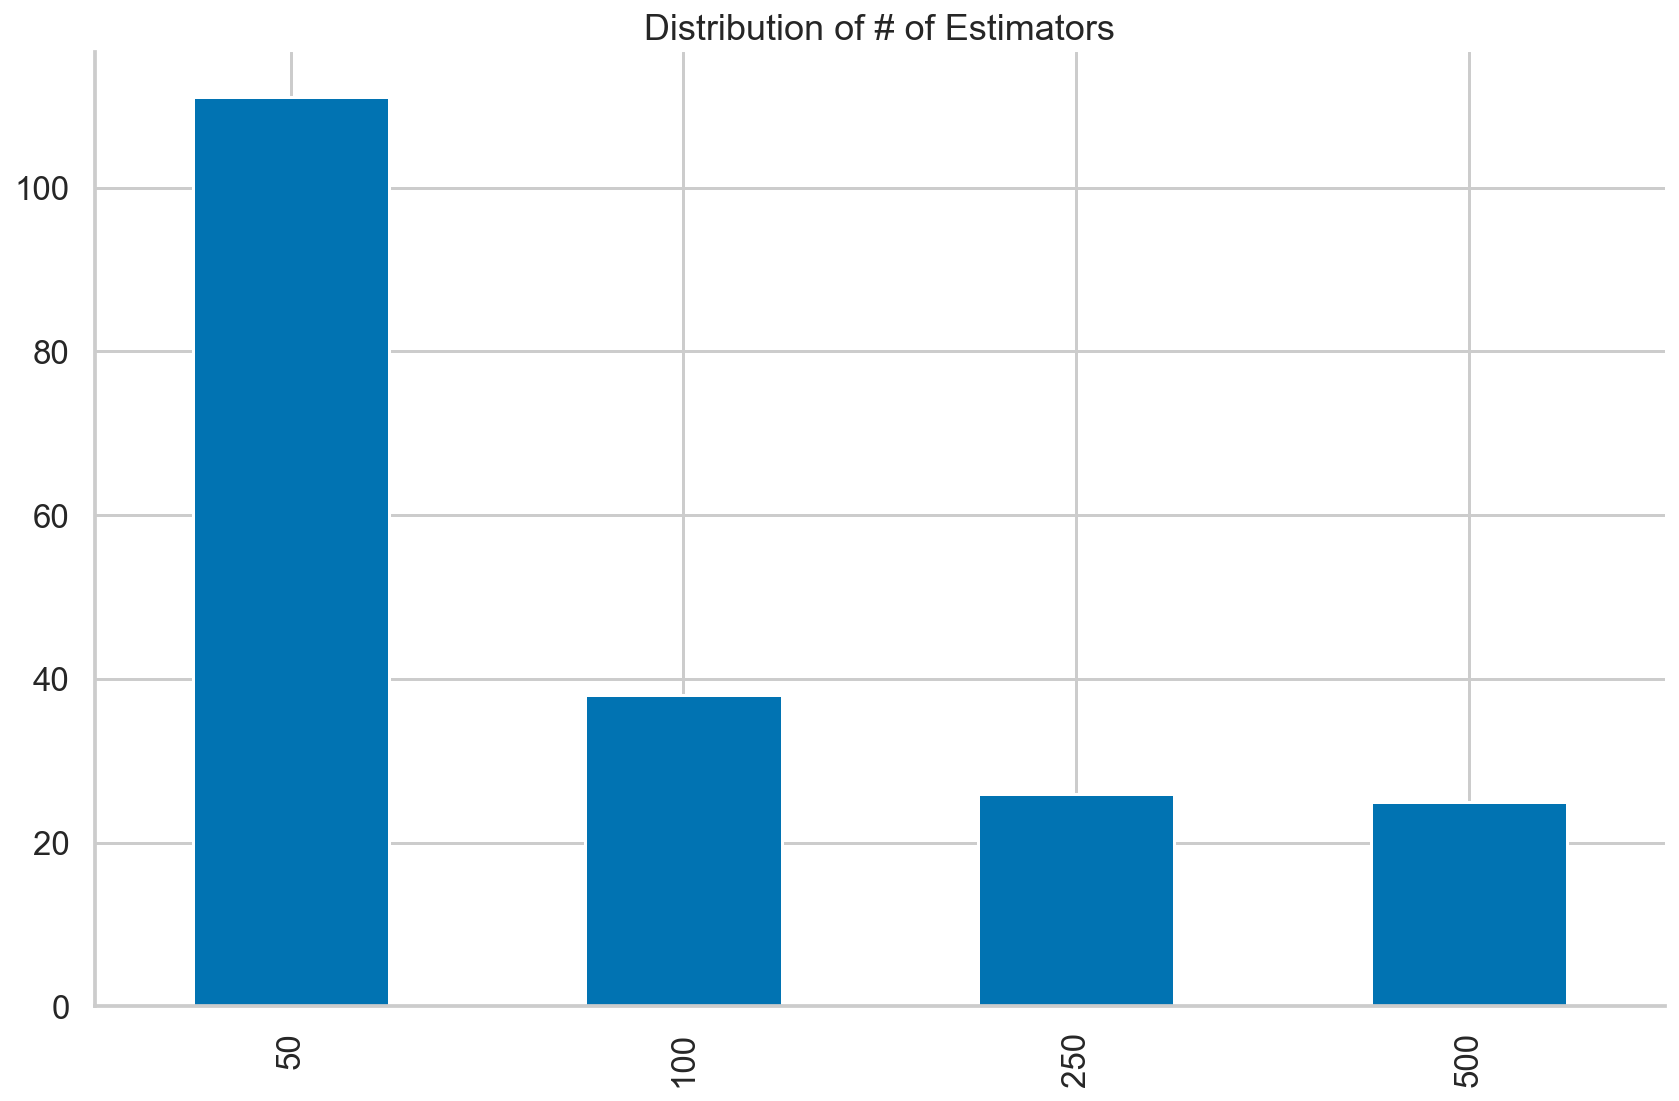

In [12]:
(
    results_df["n_estimators"]
    .value_counts()
    .plot(kind="bar",
          title="Distribution of # of Estimators")
)

plt.tight_layout()
sns.despine()

9. Plot the evolution of the observed losses over iterations:

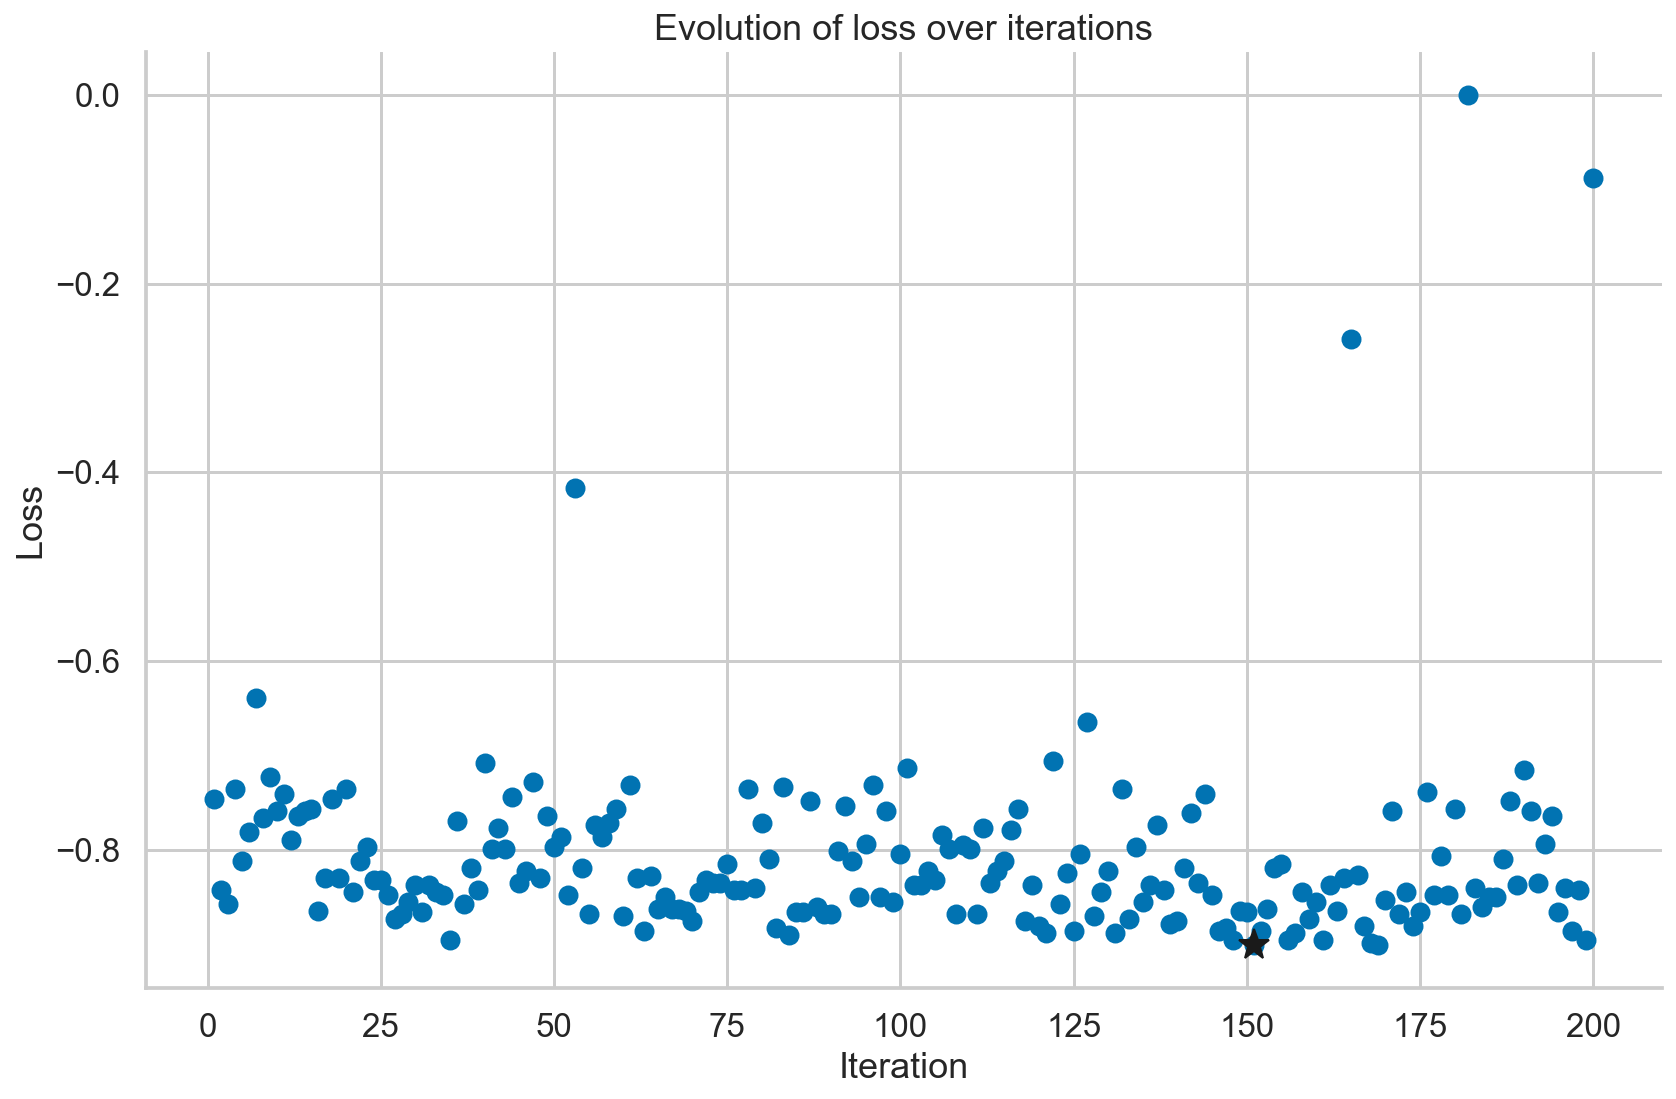

In [19]:
best_ind = results_df["loss"].argmin()

fig, ax = plt.subplots()
ax.plot(results_df["iteration"], results_df["loss"], "o")
ax.plot(results_df["iteration"].iloc[best_ind], 
        results_df["loss"].iloc[best_ind], 
        "k*", markersize=16)
ax.set(title="Evolution of loss over iterations", 
       xlabel="Iteration",
       ylabel="Loss")
plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_25", dpi=200)

## 14.6 Investigating feature importance

### Getting Ready

1. Import the libraries:

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from chapter_14_utils import performance_evaluation_report

2. Load data, preprocess it, define the model (and its hyperparameters) and fit it:

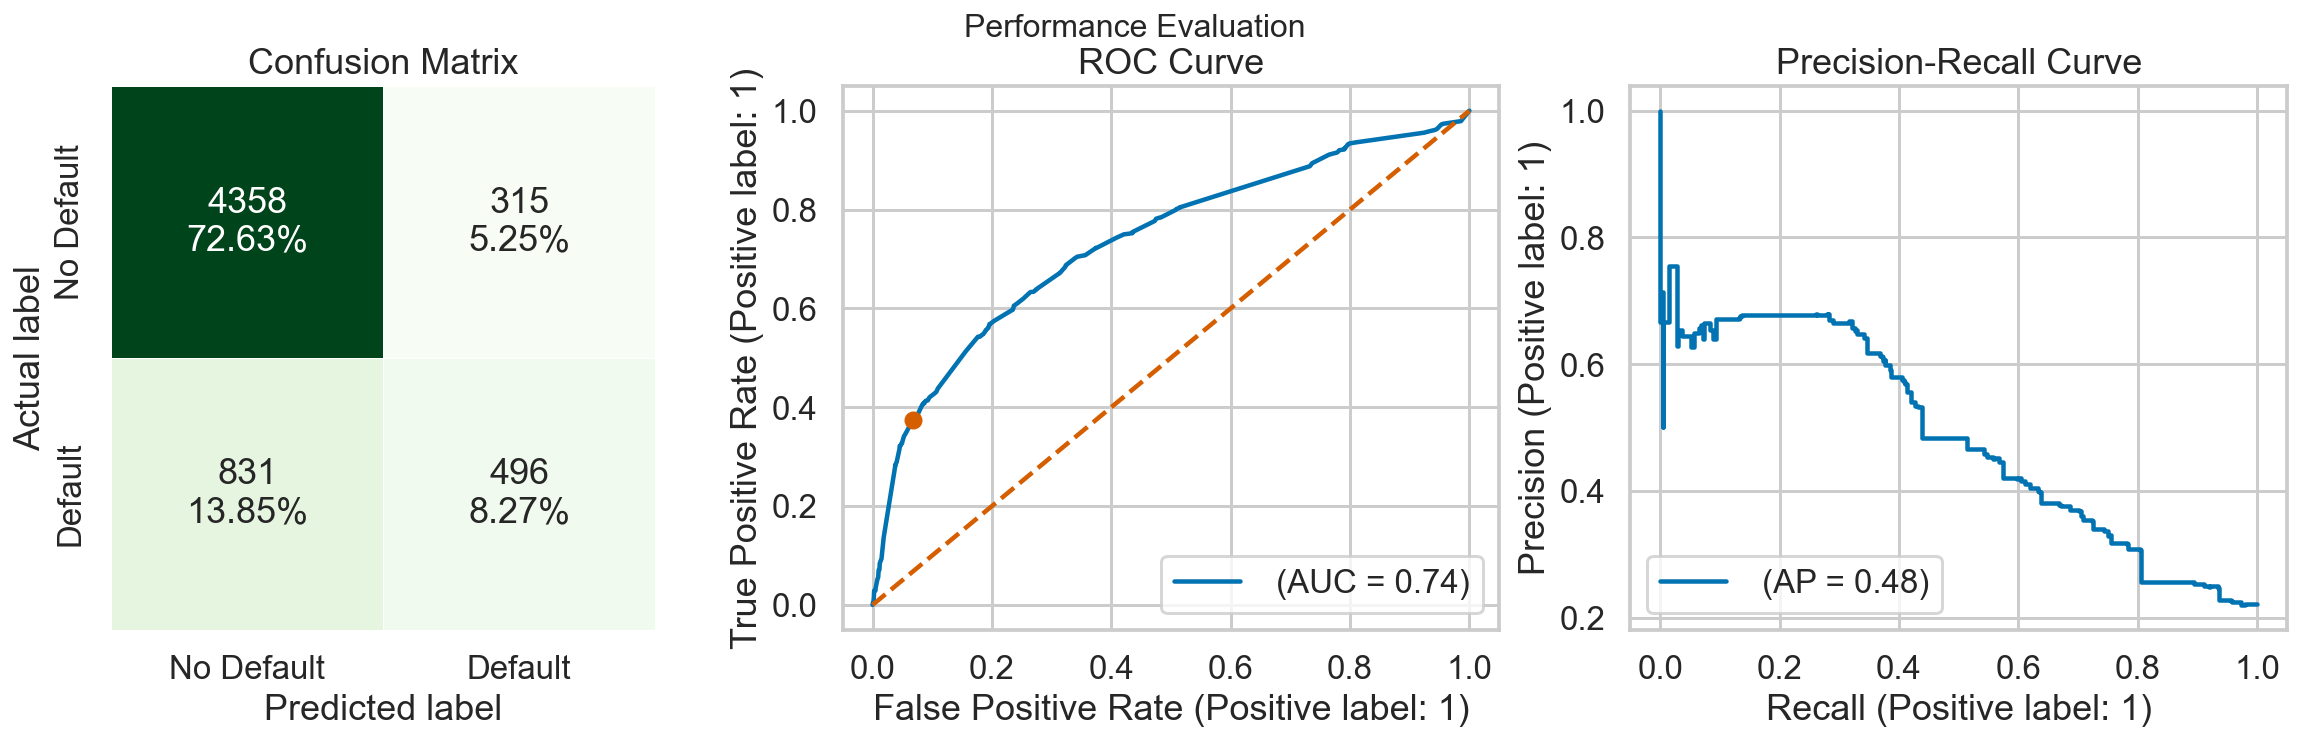

In [4]:
df = pd.read_csv("../Datasets/credit_card_default.csv", na_values="")

X = df.copy()
y = X.pop("default_payment_next_month")

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

num_features = X_train.select_dtypes(include="number").columns.to_list()
cat_features = X_train.select_dtypes(include="object").columns.to_list()

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(categories=cat_list, sparse=False, 
                             handle_unknown="error", drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", num_pipeline, num_features),
        ("categorical", cat_pipeline, cat_features)
    ], 
    remainder="drop"
)

rf_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", RandomForestClassifier(random_state=42))]
)

# optional step
# set the hyperparameters to the one obtained from tuning in Recipe 14.1
best_params = {
    "n_estimators": 300, 
    "min_samples_split": 2, 
    "min_samples_leaf": 7, 
    "max_features": None, 
    "max_depth": 8, 
    "bootstrap": False
}
rf_pipeline["classifier"].set_params(**best_params)

rf_pipeline.fit(X_train, y_train)

LABELS = ["No Default", "Default"]
rf_perf = performance_evaluation_report(rf_pipeline, X_test, 
                                        y_test, labels=LABELS, 
                                        show_plot=True, 
                                        show_pr_curve=True)

3. Sanity check for the recall score (compared to results in Recipe 14.1):

In [5]:
print(f"Recall: {rf_perf['recall']:.4f}")

Recall: 0.3738


### How to do it...

1. Import the libraries:

In [6]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score
from sklearn.base import clone

2. Extract the classifier and preprocessor from the fitted pipeline:

In [7]:
rf_classifier = rf_pipeline.named_steps["classifier"]
preprocessor = rf_pipeline.named_steps["preprocessor"]

3. Recover feature names from the preprocessing transformer and transform the training/test sets:

In [8]:
feat_names = list(preprocessor.get_feature_names_out())
feat_names = [name.replace("numerical__", "").replace("categorical__", "") for name in feat_names]

X_train_preprocessed = pd.DataFrame(
    preprocessor.transform(X_train), 
    columns=feat_names
)

X_test_preprocessed = pd.DataFrame(
    preprocessor.transform(X_test), 
    columns=feat_names
)

4. Extract the MDI feature importance and calculate the cumulative importance:

In [9]:
rf_feat_imp = pd.DataFrame(rf_classifier.feature_importances_,
                           index=feat_names,
                           columns=["mdi"])

rf_feat_imp["mdi_cumul"] = np.cumsum(
    rf_feat_imp
    .sort_values("mdi", ascending=False)
    .loc[:, "mdi"]
).loc[feat_names]

In [10]:
rf_feat_imp.head()

mdi  mdi_cumul
limit_bal           0.045303   0.752165
age                 0.018915   0.829687
bill_statement_sep  0.029459   0.781625
bill_statement_aug  0.013519   0.903986
bill_statement_jul  0.014185   0.876482

5. Define a function for plotting top X features in terms of their importance:

In [11]:
def plot_most_important_features(feat_imp, title, 
                                 n_features=10, 
                                 bottom=False):
    """
    Function for plotting the top/bottom x features in terms of their importance.
    
    Parameters
    ----------
    feat_imp : pd.Series
        A pd.Series with calculated feature importances
    title : str
        A string representing the title of calculating the importances.
    n_features : int
        Number of top/bottom features to plot
    bottom : boolean
        Indicates if the plot should contain the bottom feature importances.
    
    Returns
    -------
    ax : matplotlib.axes._subplots.AxesSubplot
        Ax cointaining the plot
    """
    
    if bottom:
        indicator = "Bottom"
        feat_imp = feat_imp.sort_values(ascending=True)
    else:
        indicator = "Top"
        feat_imp = feat_imp.sort_values(ascending=False)
        
    ax = feat_imp.head(n_features).plot.barh()
    ax.invert_yaxis()
    ax.set(title=f"{title} ({indicator} {n_features})", 
           xlabel="Importance", 
           ylabel="Feature")
    
    return ax

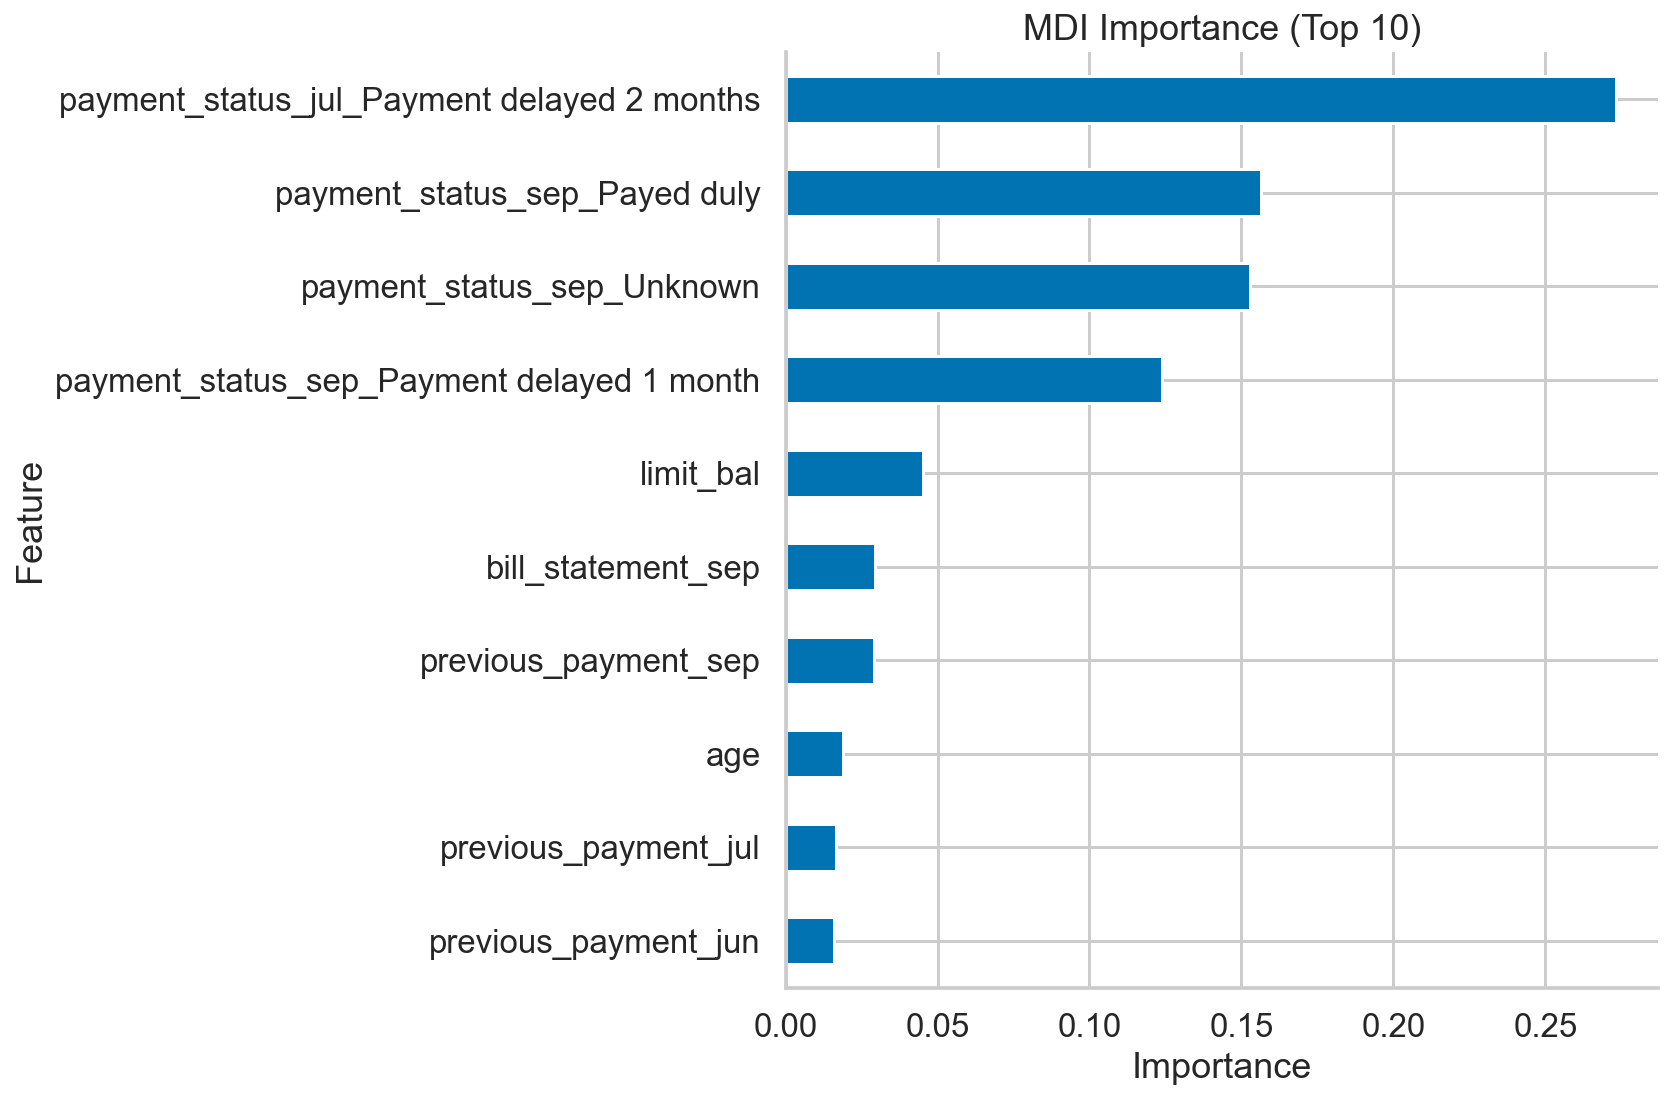

In [12]:
plot_most_important_features(rf_feat_imp["mdi"], 
                             title="MDI Importance")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_26", dpi=200)

6. Plot the cumulative importance of the features:

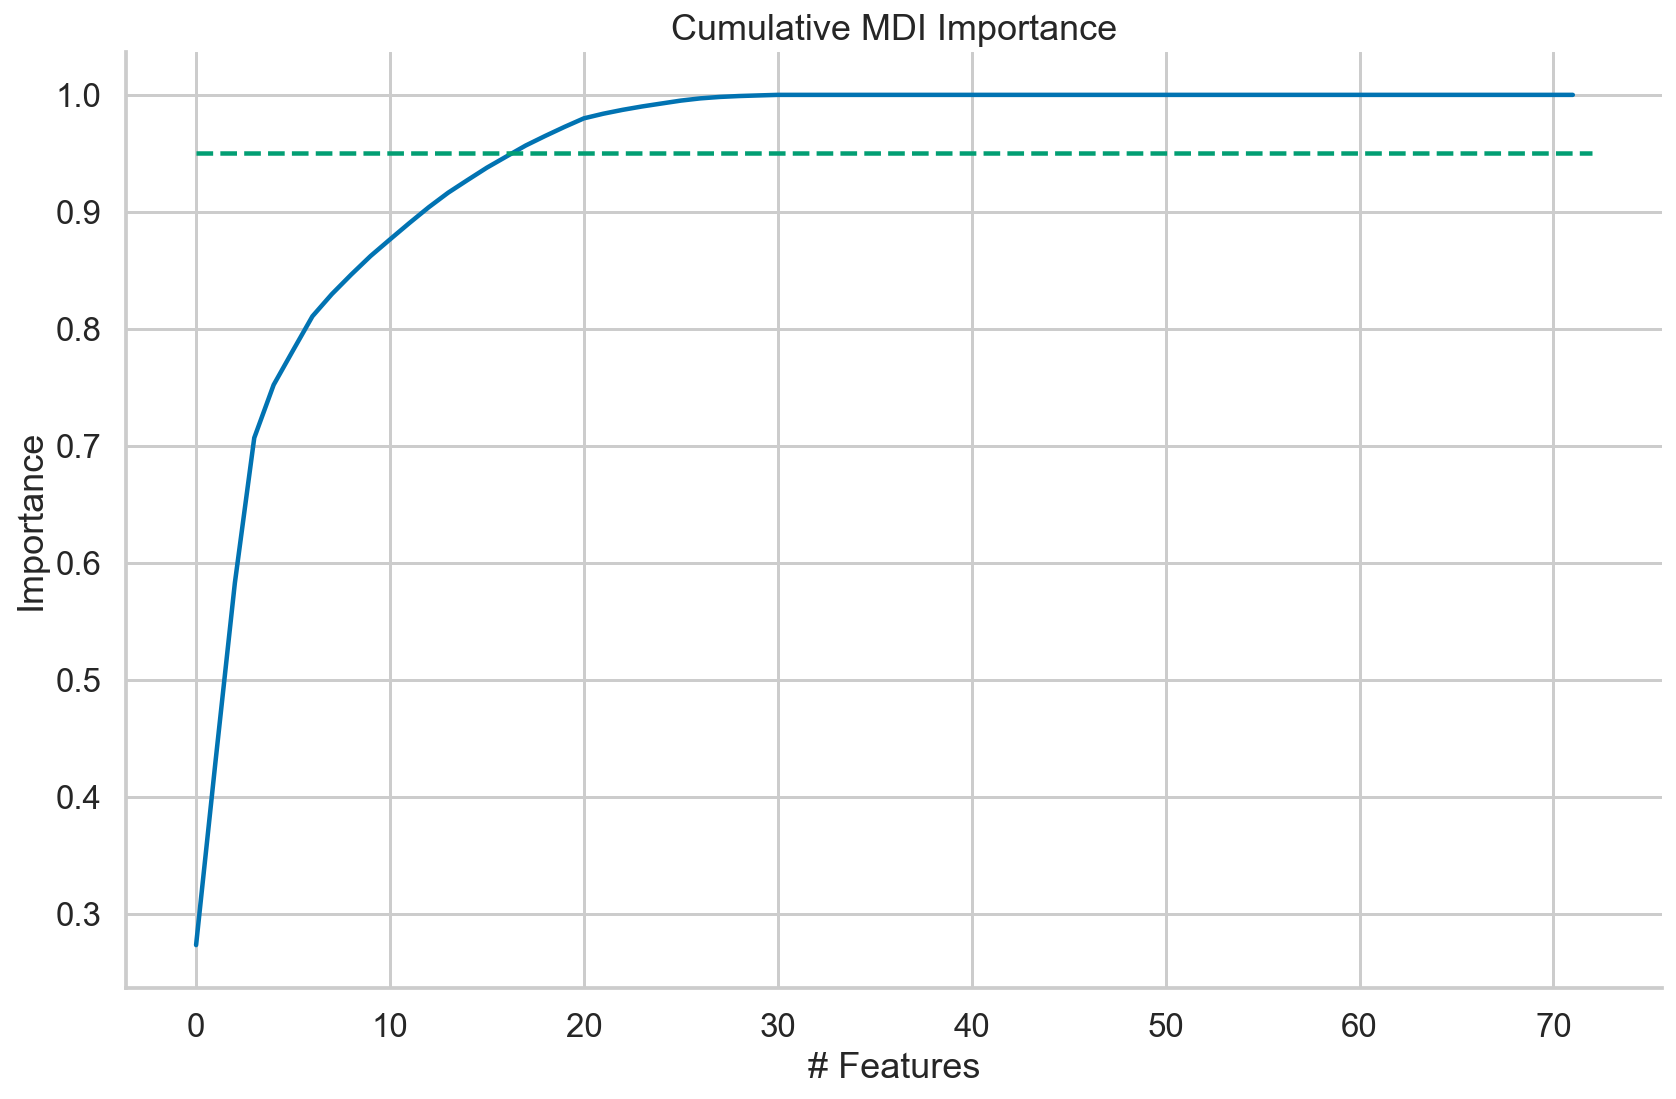

In [13]:
x_values = range(len(feat_names))

fig, ax = plt.subplots()
ax.plot(x_values, rf_feat_imp["mdi_cumul"].sort_values(), "b-")
ax.hlines(y = 0.95, xmin=0, xmax=len(x_values), 
          color = "g", linestyles = "dashed")
ax.set(title="Cumulative MDI Importance", 
       xlabel="# Features", 
       ylabel="Importance")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_27", dpi=200)

In [14]:
top_10_importance = rf_feat_imp.sort_values("mdi", ascending=False).head(10)["mdi"].sum()
importance_95_perc = rf_feat_imp[rf_feat_imp["mdi_cumul"] <= 0.95].shape[0]

print(f"Top 10 features account for {100 * top_10_importance:.2f}% of the total importance.")
print(f"Top {importance_95_perc} features account for 95% of importance.")

Top 10 features account for 86.23% of the total importance.
Top 17 features account for 95% of importance.


7. Calculate and plot permutation importance using the training set:

In [15]:
perm_result_train = permutation_importance(
    rf_classifier, X_train_preprocessed, y_train,
    n_repeats=25, scoring="recall",
    random_state=42, n_jobs=-1
)

rf_feat_imp["perm_imp_train"] = (
    perm_result_train["importances_mean"]
)

/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [16]:
perm_result_train.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

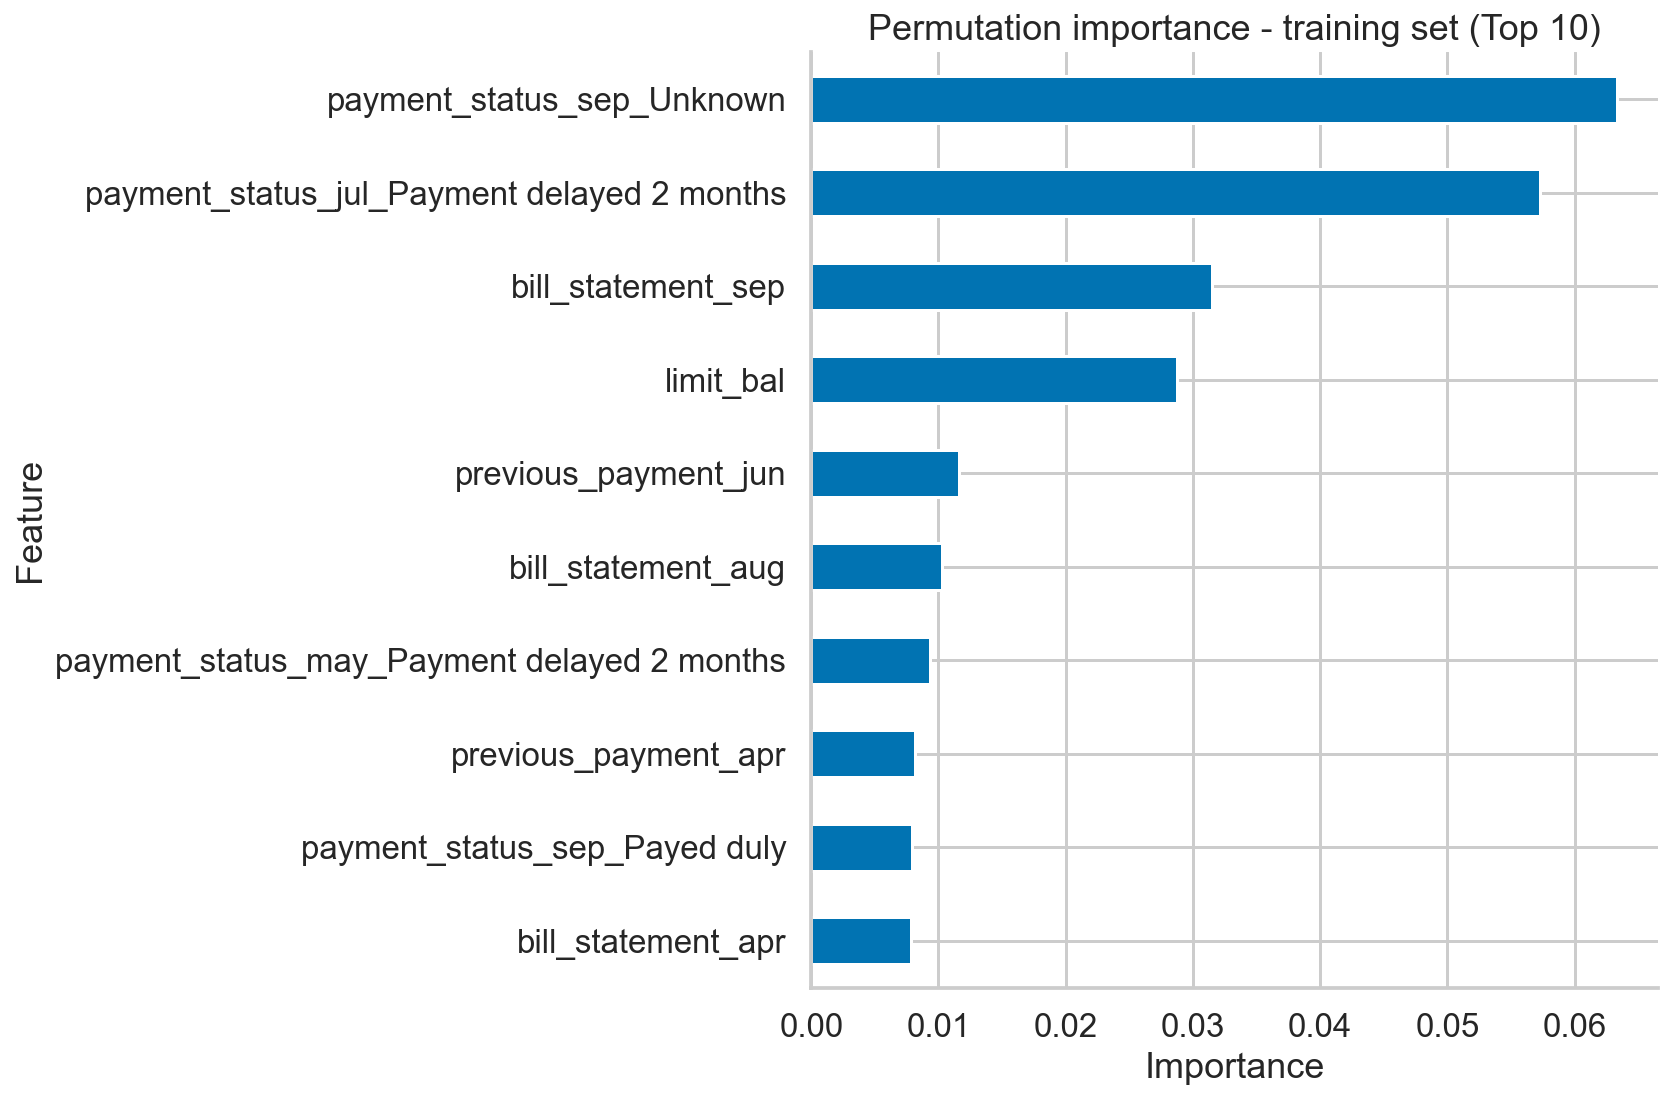

In [17]:
plot_most_important_features(
    rf_feat_imp["perm_imp_train"], 
    title="Permutation importance - training set"
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_28", dpi=200)

8. Calculate and plot permutation importance using the test set:

In [18]:
perm_result_test = permutation_importance(
    rf_classifier, X_test_preprocessed, y_test,
    n_repeats=25, scoring="recall",
    random_state=42, n_jobs=-1
)

rf_feat_imp["perm_imp_test"] = (
    perm_result_test["importances_mean"]
)

/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


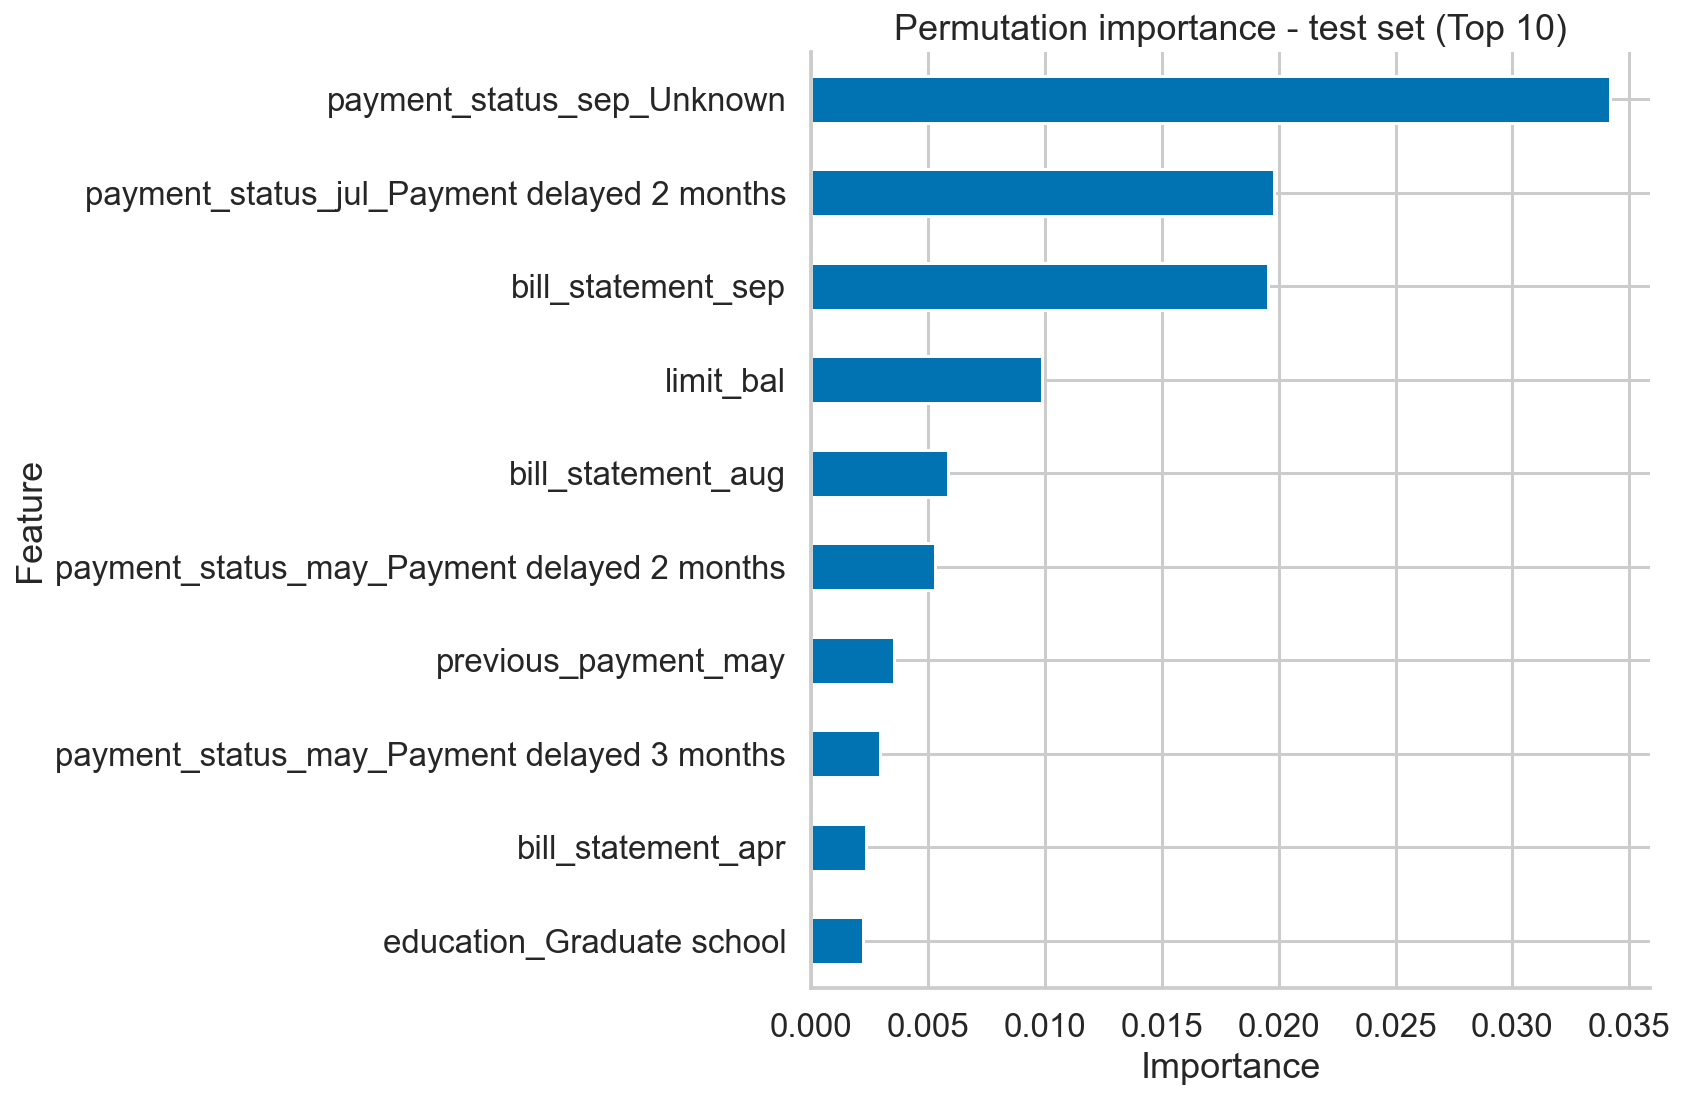

In [19]:
plot_most_important_features(
    rf_feat_imp["perm_imp_test"], 
    title="Permutation importance - test set"
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_29", dpi=200)

9. Define a function for calculating the drop-column feature importance:

In [20]:
def drop_col_feat_imp(model, X, y, metric, random_state = 42):
    '''
    Function for calculating the drop column feature importance.
    
    Parameters
    ----------
    model : scikit-learn's model
        Object representing the estimator with selected hyperparameters.
    X : pd.DataFrame
        Features for training the model
    y : pd.Series
        The target
    metric : a sklearn metric
        Metric such as accuracy_score, precision_score or recall_score
    random_state : int
        Random state for reproducibility
        
    Returns
    -------
    importances : list
        List containing the calculated feature importances in the order of appearing in X
    
    '''
    
    model_clone = clone(model)
    model_clone.random_state = random_state
    model_clone.fit(X, y)
    benchmark_score = metric(y, model_clone.predict(X))
    
    importances = []
    
    for ind, col in enumerate(X.columns):
        print(f"Dropping {col} ({ind+1}/{len(X.columns)})")
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X.drop(col, axis = 1), y)
        drop_col_score = metric(
            y, model_clone.predict(X.drop(col, axis = 1))
        )
        importances.append(benchmark_score - drop_col_score)
    
    return importances

10. Calculate and plot the drop-column feature importance:

In [21]:
rf_feat_imp["drop_column_imp"] = drop_col_feat_imp(
    rf_classifier.set_params(**{"n_jobs": -1}), 
    X_train_preprocessed, 
    y_train, 
    metric = recall_score,
    random_state = 42
)

Dropping limit_bal (1/72)
Dropping age (2/72)
Dropping bill_statement_sep (3/72)
Dropping bill_statement_aug (4/72)
Dropping bill_statement_jul (5/72)
Dropping bill_statement_jun (6/72)
Dropping bill_statement_may (7/72)
Dropping bill_statement_apr (8/72)
Dropping previous_payment_sep (9/72)
Dropping previous_payment_aug (10/72)
Dropping previous_payment_jul (11/72)
Dropping previous_payment_jun (12/72)
Dropping previous_payment_may (13/72)
Dropping previous_payment_apr (14/72)
Dropping sex_Male (15/72)
Dropping education_Graduate school (16/72)
Dropping education_High school (17/72)
Dropping education_Others (18/72)
Dropping marriage_Married (19/72)
Dropping marriage_Others (20/72)
Dropping payment_status_sep_Payment delayed 1 month (21/72)
Dropping payment_status_sep_Unknown (22/72)
Dropping payment_status_sep_Payed duly (23/72)
Dropping payment_status_sep_Payment delayed 3 months (24/72)
Dropping payment_status_sep_Payment delayed 4 months (25/72)
Dropping payment_status_sep_Payment

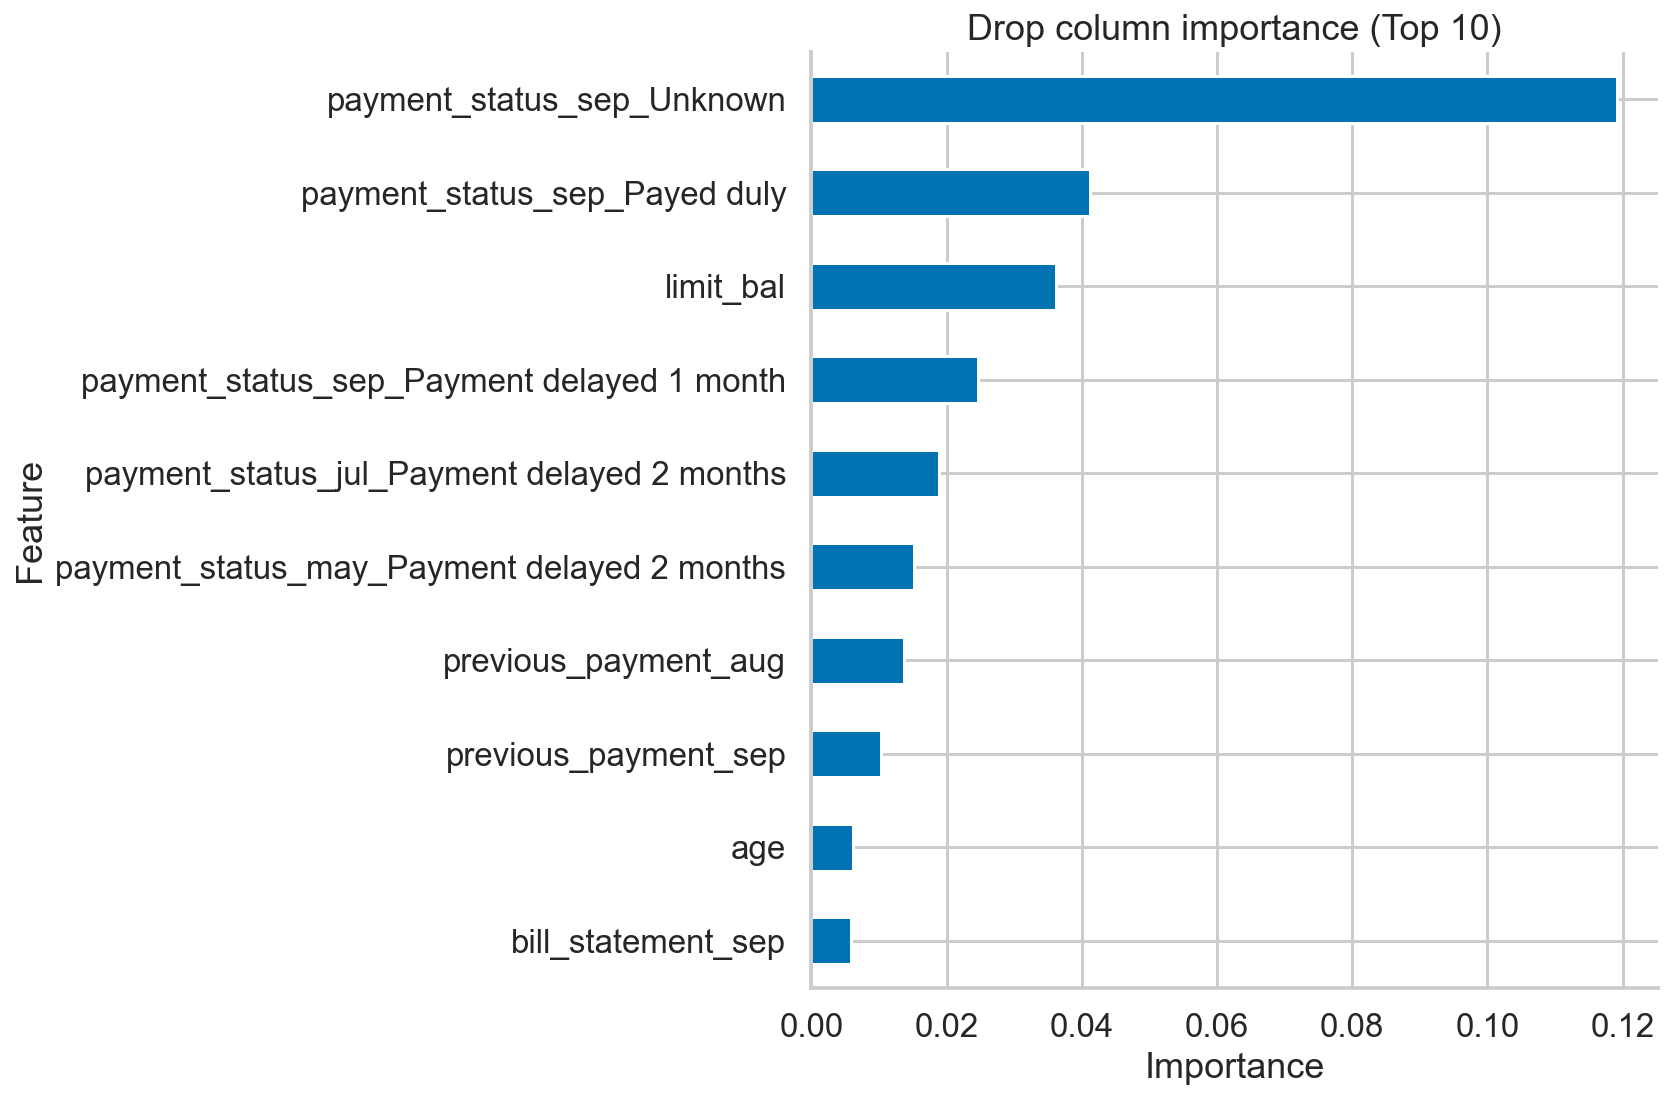

In [22]:
plot_most_important_features(
    rf_feat_imp["drop_column_imp"], 
    title="Drop column importance"
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_30", dpi=200)

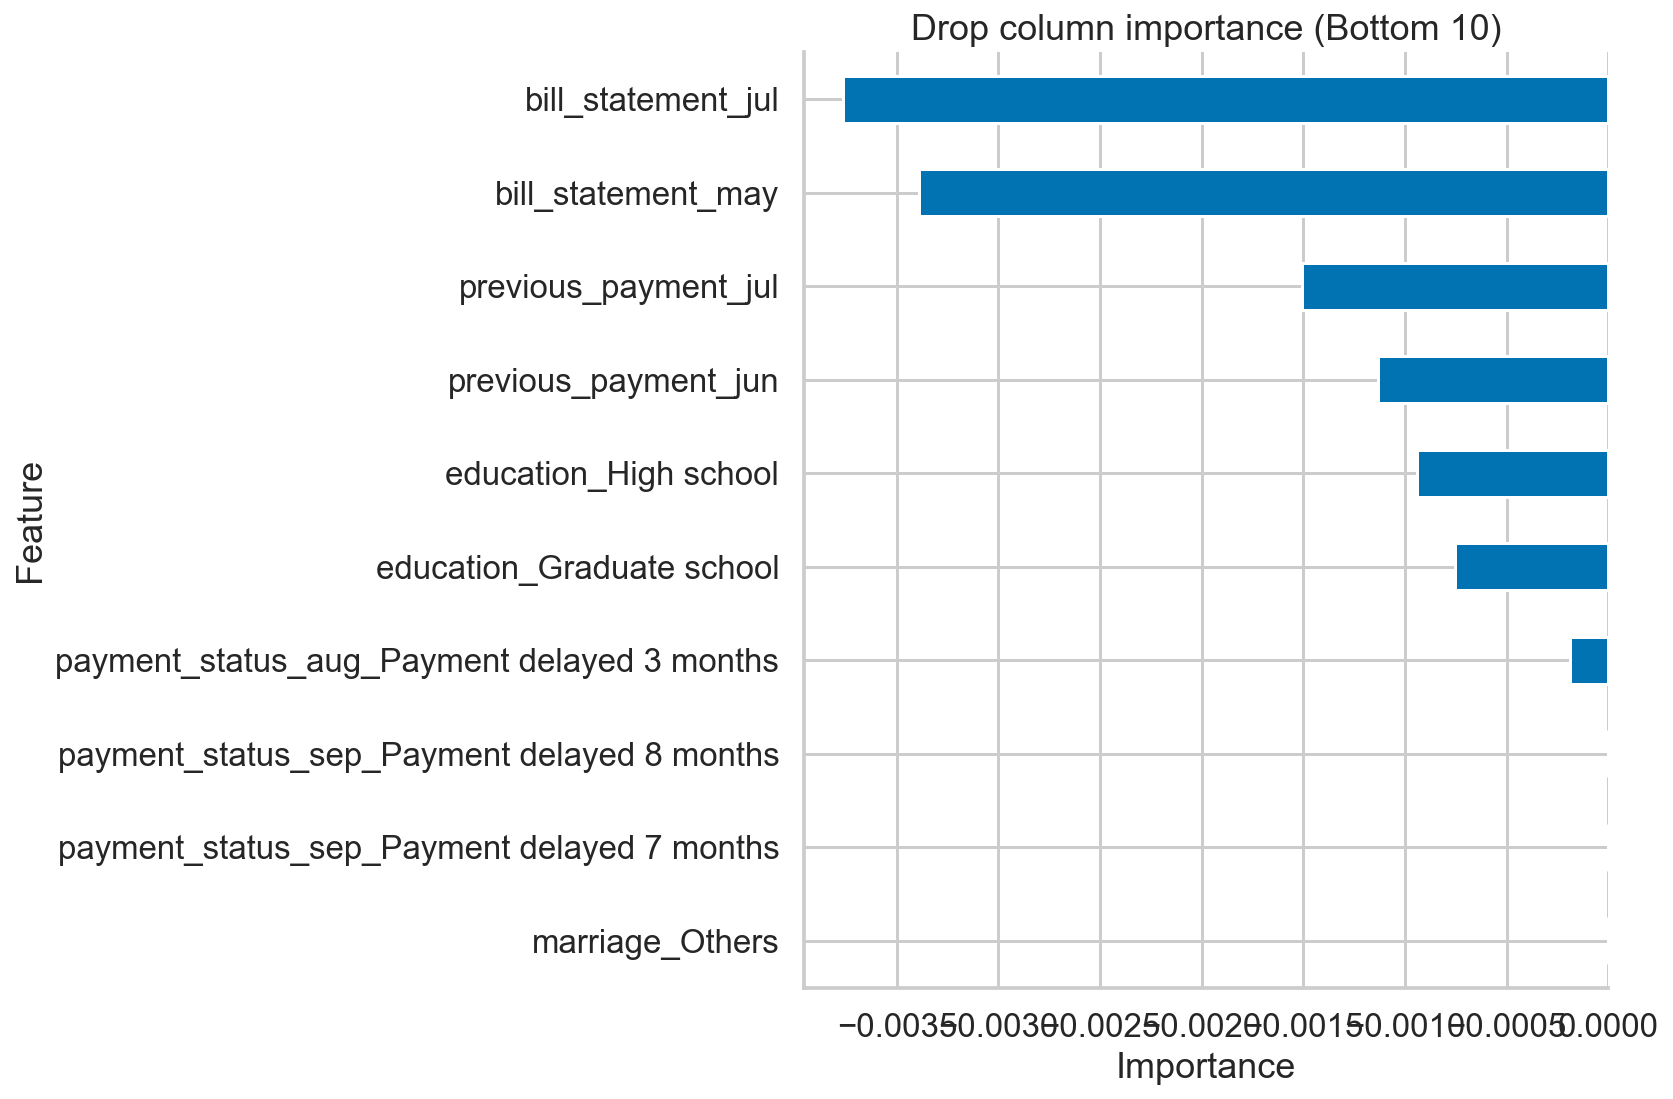

In [23]:
plot_most_important_features(
    rf_feat_imp["drop_column_imp"], 
    title="Drop column importance", 
    bottom=True
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_31", dpi=200)

### There's more

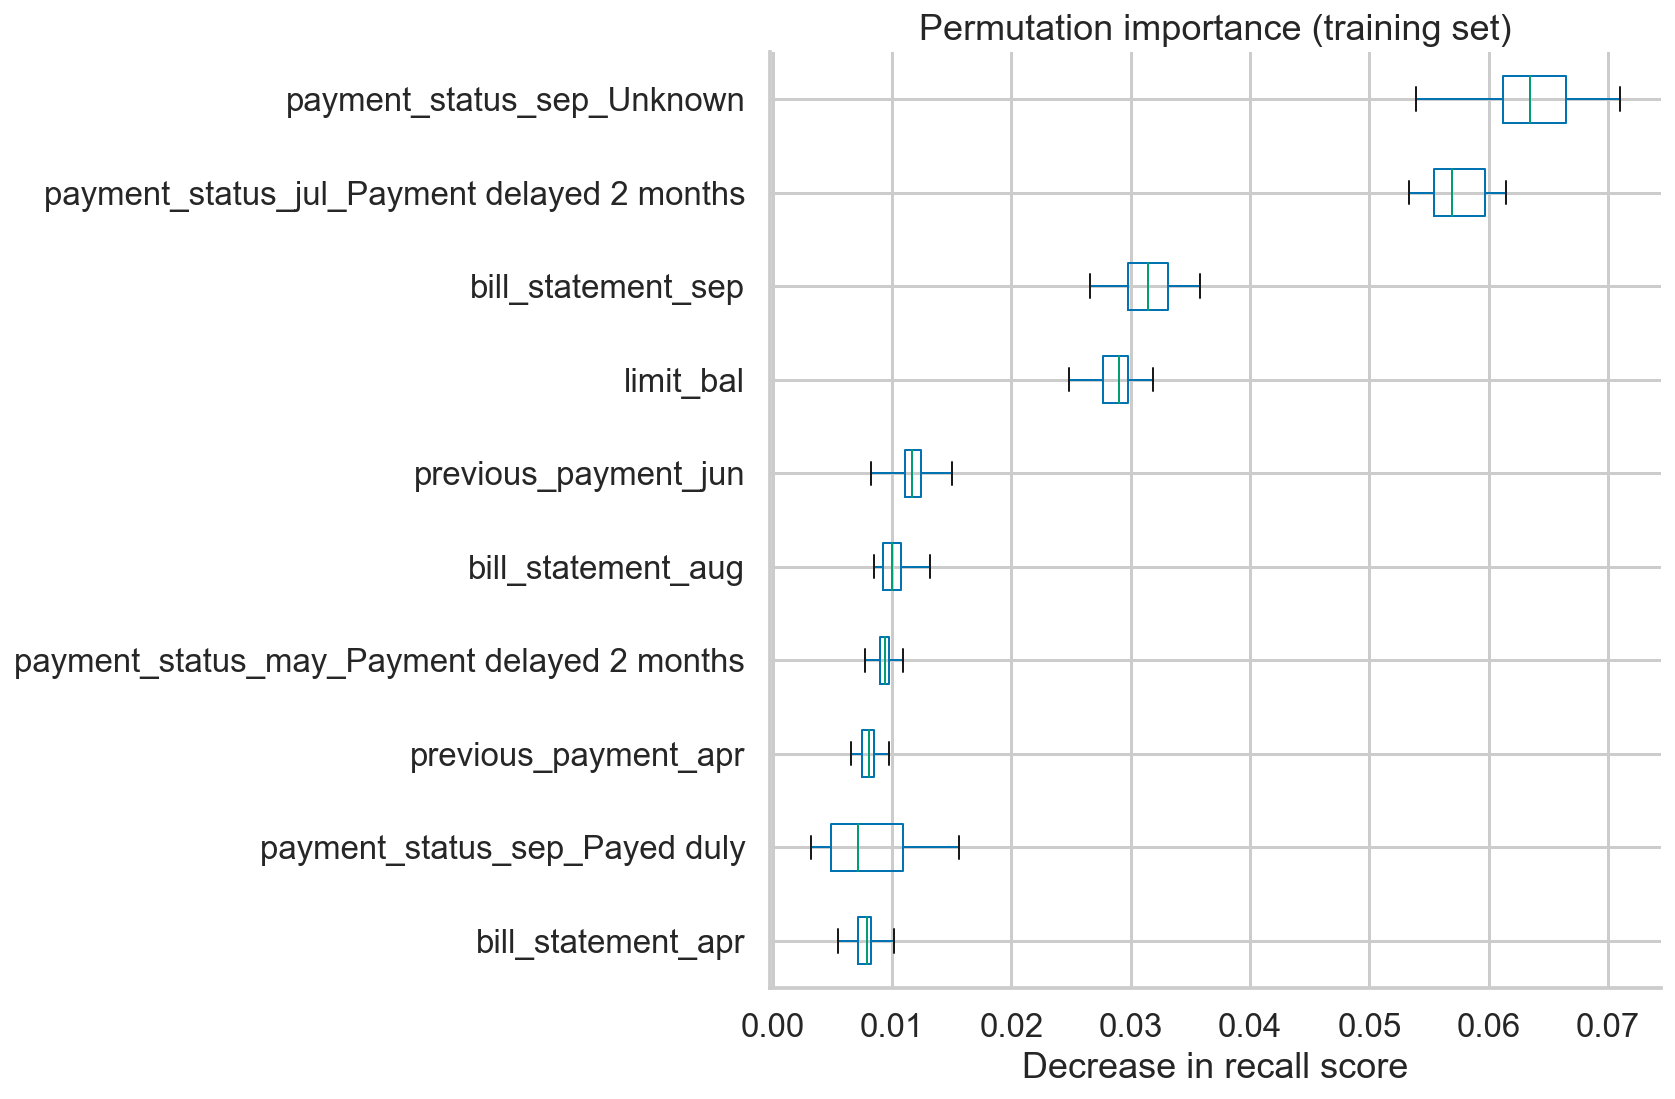

In [24]:
sorted_imp_ind = perm_result_train["importances_mean"].argsort()[-10:]

importances = pd.DataFrame(
    perm_result_train["importances"][sorted_imp_ind].T,
    columns=X_train_preprocessed.columns[sorted_imp_ind],
)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation importance (training set)")
ax.set_xlabel("Decrease in recall score")

plt.tight_layout()
sns.despine()

## 14.7 Exploring feature selection techniques

### Getting ready

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

df = pd.read_csv("../Datasets/credit_card_fraud.csv")

X = df.copy().drop(columns=["Time"])
y = X.pop("Class")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

### How to do it...

1. Import the libraries:

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.feature_selection import (RFE, RFECV, 
                                       SelectKBest, 
                                       SelectFromModel, 
                                       mutual_info_classif)
from sklearn.model_selection import StratifiedKFold

2. Train the benchmark model:

In [5]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, 
                            n_jobs=-1)
rf.fit(X_train, y_train)

recall_train = recall_score(y_train, rf.predict(X_train))
recall_test = recall_score(y_test, rf.predict(X_test))
print(f"Recall score training: {recall_train:.4f}")
print(f"Recall score test: {recall_test:.4f}")

Recall score training: 1.0000
Recall score test: 0.8265


3. Select the best features using Mutual Information:

In [6]:
scores = []
n_features_list = list(range(2, len(X_train.columns)+1))

for n_feat in n_features_list:
    print(f"Keeping {n_feat} most important features")
    mi_selector = SelectKBest(mutual_info_classif, k=n_feat)
    X_train_new = mi_selector.fit_transform(X_train, y_train)
    X_test_new = mi_selector.transform(X_test)

    rf.fit(X_train_new, y_train)
    recall_scores = [
        recall_score(y_train, rf.predict(X_train_new)),
        recall_score(y_test, rf.predict(X_test_new))
    ]
    scores.append(recall_scores)

mi_scores_df = pd.DataFrame(
    scores, 
    columns=["train_score", "test_score"],
    index=n_features_list
)

Keeping 2 most important features
Keeping 3 most important features
Keeping 4 most important features
Keeping 5 most important features
Keeping 6 most important features
Keeping 7 most important features
Keeping 8 most important features
Keeping 9 most important features
Keeping 10 most important features
Keeping 11 most important features
Keeping 12 most important features
Keeping 13 most important features
Keeping 14 most important features
Keeping 15 most important features
Keeping 16 most important features
Keeping 17 most important features
Keeping 18 most important features
Keeping 19 most important features
Keeping 20 most important features
Keeping 21 most important features
Keeping 22 most important features
Keeping 23 most important features
Keeping 24 most important features
Keeping 25 most important features
Keeping 26 most important features
Keeping 27 most important features
Keeping 28 most important features
Keeping 29 most important features


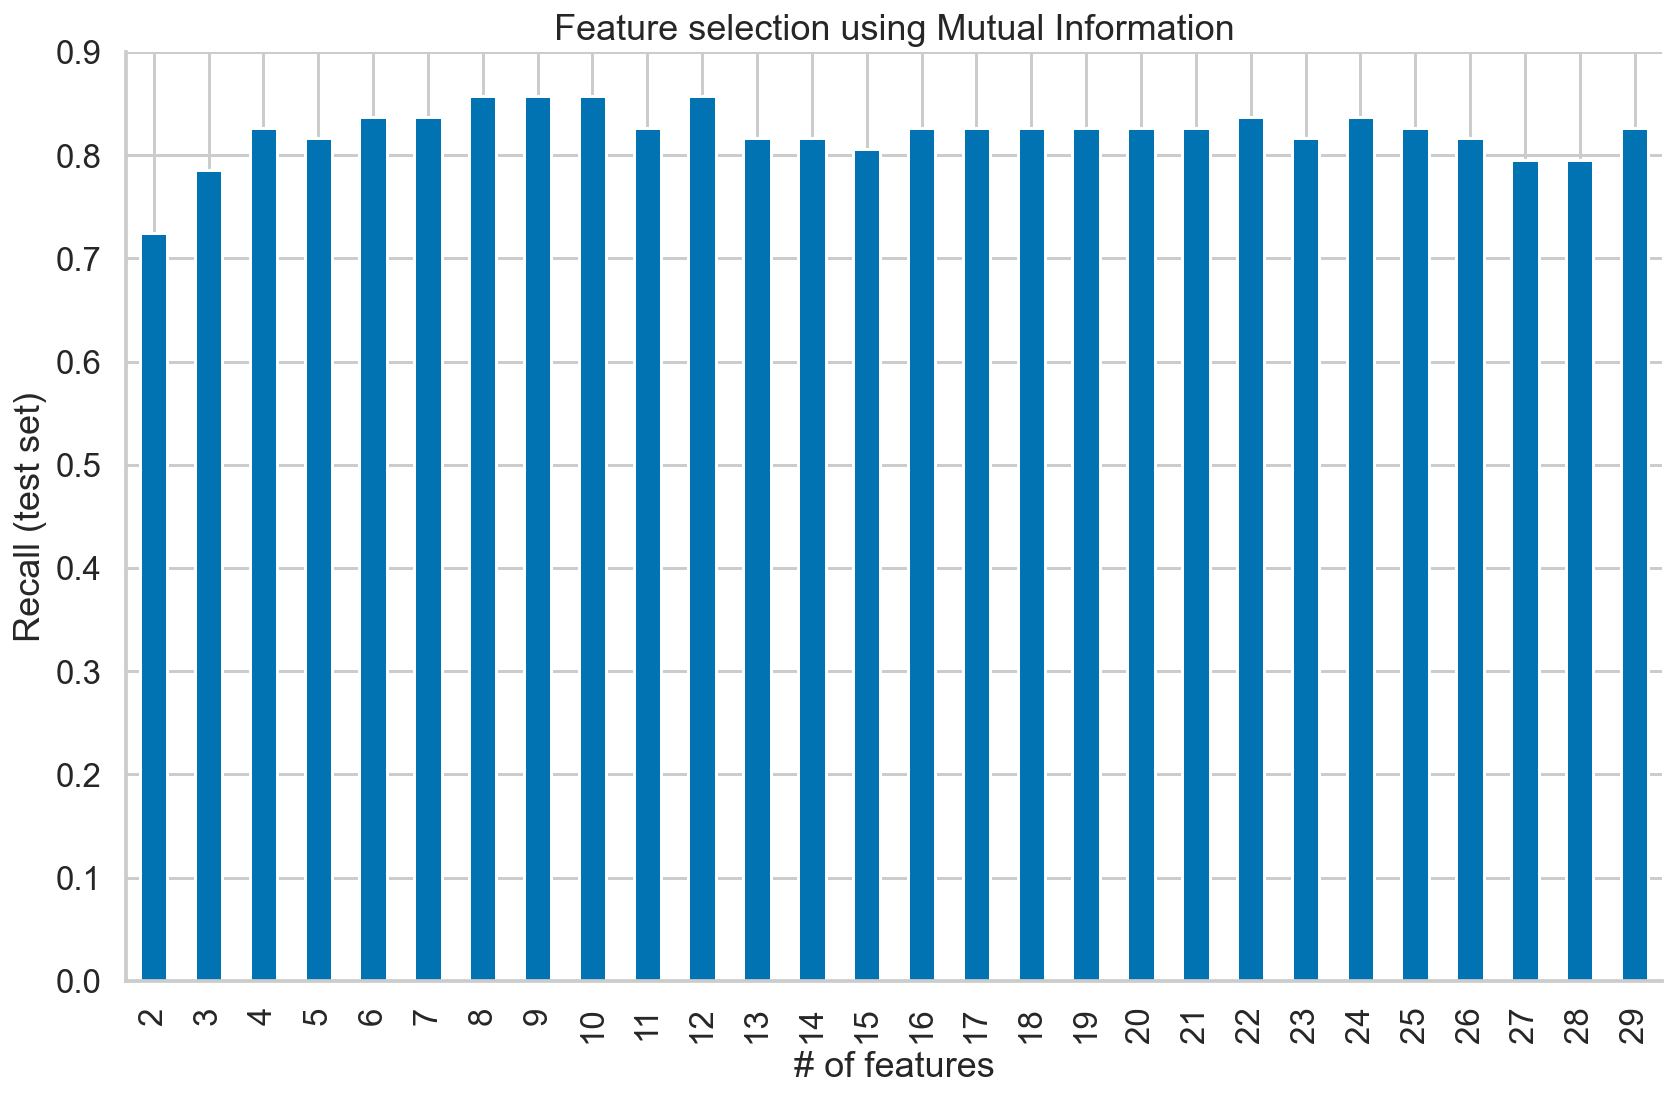

In [7]:
(
    mi_scores_df["test_score"]
    .plot(kind="bar", 
          title="Feature selection using Mutual Information",
          xlabel="# of features",
          ylabel="Recall (test set)")
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_32", dpi=200)

In [8]:
mi_scores_df["test_score"].sort_values(ascending=False).head(5)

8     0.857143
9     0.857143
10    0.857143
12    0.857143
24    0.836735
Name: test_score, dtype: float64

In [9]:
mi_selector = SelectKBest(mutual_info_classif, k=8)
mi_selector.fit(X_train, y_train)
print(f"Most importance features according to MI: {mi_selector.get_feature_names_out()}")

Most importance features according to MI: ['V3' 'V4' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17']


4. Select the best features using MDI feature importance, retrain the model and evaluate its performance:

In [10]:
# fit the selector
rf_selector = SelectFromModel(rf)
rf_selector.fit(X_train, y_train)

# evaluate the model
mdi_features = X_train.columns[rf_selector.get_support()]
rf.fit(X_train[mdi_features], y_train)
recall_train = recall_score(y_train, rf.predict(X_train[mdi_features]))
recall_test = recall_score(y_test, rf.predict(X_test[mdi_features]))
print(f"Recall score training: {recall_train:.4f}")
print(f"Recall score test: {recall_test:.4f}")

Recall score training: 1.0000
Recall score test: 0.8367


In [11]:
print(f"MDI importance threshold: {rf_selector.threshold_:.4f}")
print(f"Most importance features according to MDI: {rf_selector.get_feature_names_out()}")

MDI importance threshold: 0.0345
Most importance features according to MDI: ['V10' 'V11' 'V12' 'V14' 'V16' 'V17']


In [12]:
# train the simple RF model
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

# recover the feature importances, sort by importance descending
mdi_imp = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# define a list for storing the scores
scores = []

# iterate increasing the number of retained features by 1 with each loop
n_features_list = range(2, len(mdi_imp)+1)
for n_feat in n_features_list:
    
    print(f"Keeping {n_feat} most important features")
    selected_features = mdi_imp.iloc[:n_feat].index.to_list()
    
    rf.fit(X_train[selected_features], y_train)
    recall_scores = [
        recall_score(y_train, rf.predict(X_train[selected_features])), 
        recall_score(y_test, rf.predict(X_test[selected_features]))
    ]
    scores.append(recall_scores)

mdi_scores_df = pd.DataFrame(
    scores, 
    columns=["train_score", "test_score"],
    index=n_features_list
)

Keeping 2 most important features
Keeping 3 most important features
Keeping 4 most important features
Keeping 5 most important features
Keeping 6 most important features
Keeping 7 most important features
Keeping 8 most important features
Keeping 9 most important features
Keeping 10 most important features
Keeping 11 most important features
Keeping 12 most important features
Keeping 13 most important features
Keeping 14 most important features
Keeping 15 most important features
Keeping 16 most important features
Keeping 17 most important features
Keeping 18 most important features
Keeping 19 most important features
Keeping 20 most important features
Keeping 21 most important features
Keeping 22 most important features
Keeping 23 most important features
Keeping 24 most important features
Keeping 25 most important features
Keeping 26 most important features
Keeping 27 most important features
Keeping 28 most important features
Keeping 29 most important features


In [13]:
mdi_scores_df.sort_values("test_score", ascending=False).head()

train_score  test_score
10          1.0    0.857143
5           1.0    0.846939
11          1.0    0.836735
13          1.0    0.836735
4           1.0    0.836735

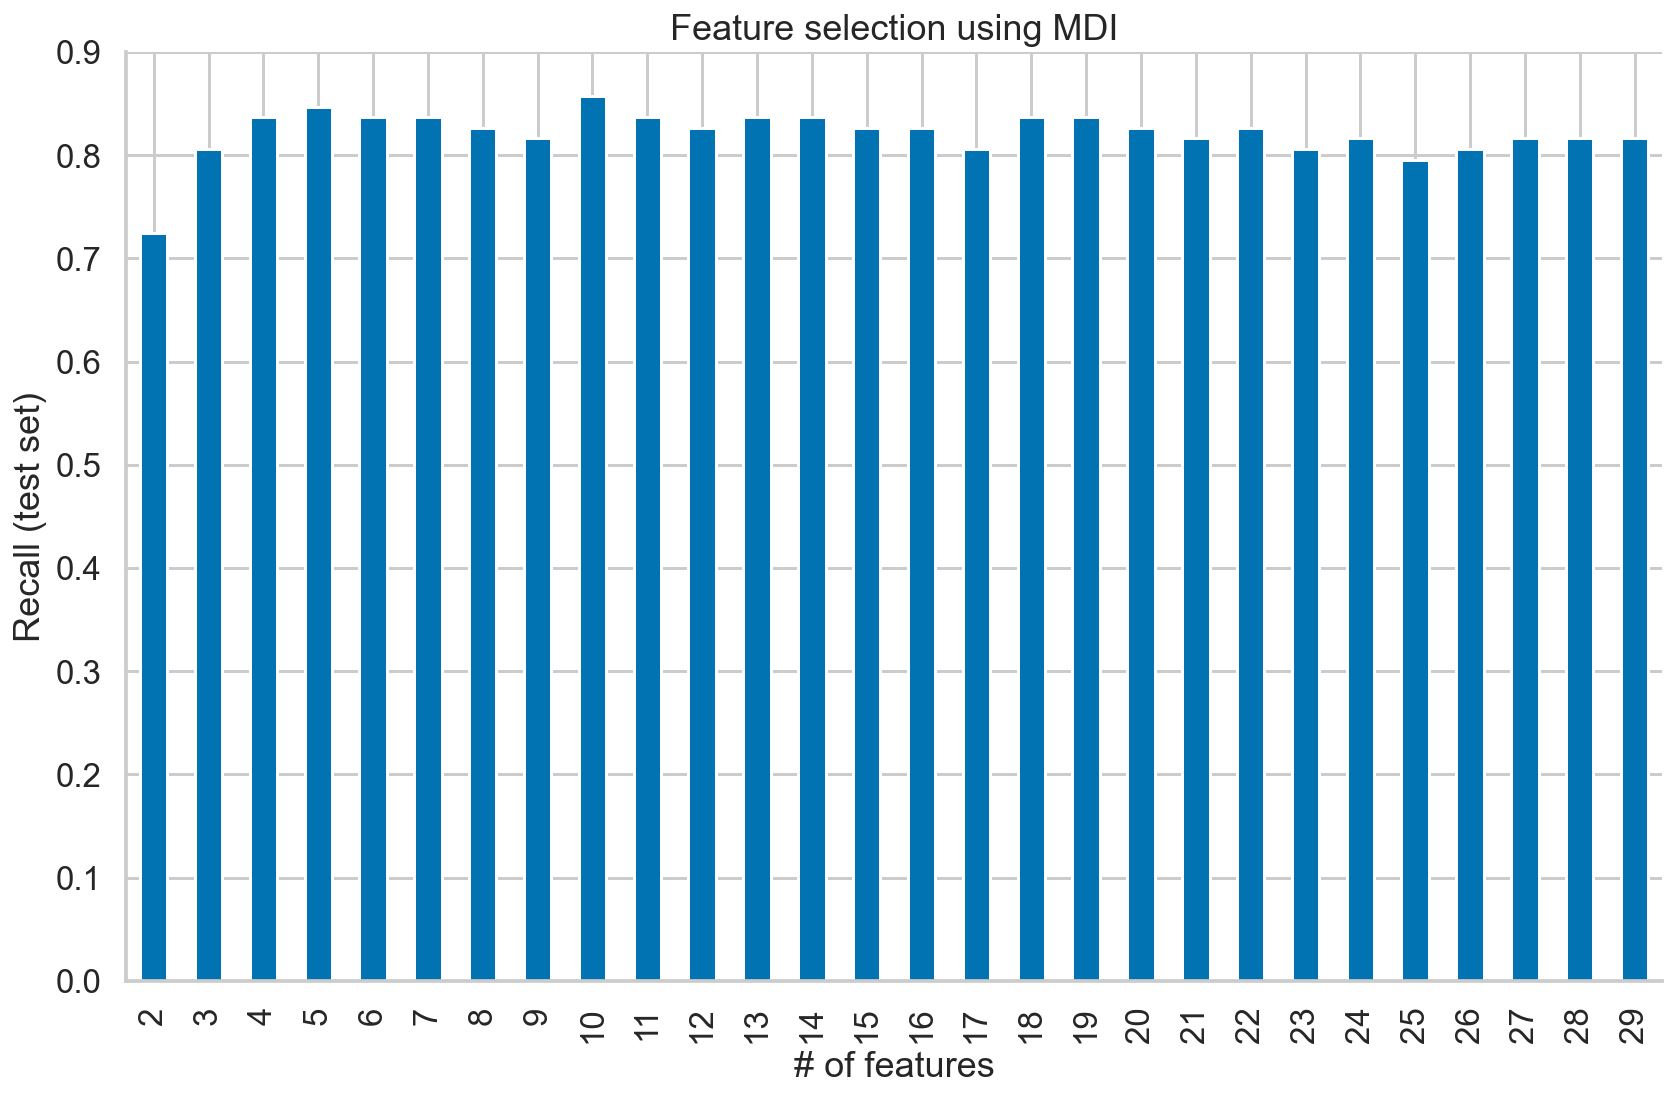

In [14]:
(
    mdi_scores_df["test_score"]
    .plot(kind="bar", 
          title="Feature selection using MDI",
          xlabel="# of features",
          ylabel="Recall (test set)")
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_33", dpi=200)

5. Select the best 10 features using Recursive Feature Elimination:

In [15]:
rfe = RFE(estimator=rf, n_features_to_select=10, verbose=1)
rfe.fit(X_train, y_train)

Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
    n_features_to_select=10, verbose=1)

In [16]:
rfe_features = rfe.get_feature_names_out()
rf.fit(X_train[rfe_features], y_train)
recall_train = recall_score(y_train, rf.predict(X_train[rfe_features]))
recall_test = recall_score(y_test, rf.predict(X_test[rfe_features]))
print(f"Most importance features according to RFE: {rfe_features}")
print(f"Recall score training: {recall_train:.4f}")
print(f"Recall score test: {recall_test:.4f}")

Most importance features according to RFE: ['V4' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V26']
Recall score training: 1.0000
Recall score test: 0.8367


6. Select the best features using Recursive Feature Elimination with cross-validation:

In [17]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

rfe_cv = RFECV(estimator=rf, step=1, 
               cv=k_fold, 
               min_features_to_select=5, 
               scoring="recall", 
               verbose=1, n_jobs=-1)
rfe_cv.fit(X_train, y_train)

Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.


RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
      min_features_to_select=5, n_jobs=-1, scoring='recall', verbose=1)

In [18]:
rfecv_features = rfe_cv.get_feature_names_out()
rf.fit(X_train[rfecv_features], y_train)
recall_train = recall_score(y_train, rf.predict(X_train[rfecv_features]))
recall_test = recall_score(y_test, rf.predict(X_test[rfecv_features]))
print(f"Most importance features according to RFECV: {rfecv_features}")
print(f"Recall score training: {recall_train:.4f}")
print(f"Recall score test: {recall_test:.4f}")

Most importance features according to RFECV: ['V1' 'V4' 'V6' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14' 'V15' 'V16' 'V17' 'V18'
 'V20' 'V21' 'V26']
Recall score training: 1.0000
Recall score test: 0.8265


In [19]:
# we added 5 as we set min_features_to_select to 5 while calling RFECV
cv_results_df = pd.DataFrame(rfe_cv.cv_results_)
cv_results_df.index += 5
cv_results_df

mean_test_score  std_test_score  split0_test_score  split1_test_score  \
5          0.771600        0.010744           0.782051           0.759494   
6          0.774099        0.028268           0.769231           0.734177   
7          0.779195        0.036276           0.782051           0.721519   
8          0.776631        0.028545           0.769231           0.734177   
9          0.766472        0.037353           0.756410           0.708861   
10         0.779163        0.023695           0.769231           0.759494   
11         0.776631        0.030709           0.769231           0.746835   
12         0.774067        0.027403           0.756410           0.746835   
13         0.781727        0.023169           0.782051           0.759494   
14         0.776631        0.026204           0.769231           0.746835   
15         0.774034        0.022630           0.743590           0.772152   
16         0.784226        0.026855           0.769231           0.772152   
17         0.774034        0.027722           0.743590           0.759494   
18         0.776599        0.025272           0.756410           0.759494   
19         0.776599        0.031988           0.756410           0.746835   
20         0.776566        0.032264           0.743590           0.759494   
21         0.776599        0.025272           0.756410           0.759494   
22         0.779130        0.029969           0.756410           0.759494   
23         0.776631        0.019136           0.769231           0.759494   
24         0.769004        0.026088           0.756410           0.734177   
25         0.774067        0.020747           0.756410           0.759494   
26         0.776599        0.025272           0.756410           0.759494   
27         0.776631        0.019136           0.769231           0.759494   
28         0.776599        0.031988           0.756410           0.746835   
29         0.774034        0.027722           0.743590           0.759494   

    split2_test_score  split3_test_score  split4_test_score  
5            0.759494           0.784810           0.772152  
6            0.772152           0.822785           0.772152  
7            0.772152           0.835443           0.784810  
8            0.772152           0.822785           0.784810  
9            0.759494           0.822785           0.784810  
10           0.759494           0.822785           0.784810  
11           0.759494           0.835443           0.772152  
12           0.759494           0.822785           0.784810  
13           0.759494           0.822785           0.784810  
14           0.759494           0.822785           0.784810  
15           0.759494           0.810127           0.784810  
16           0.759494           0.835443           0.784810  
17           0.759494           0.822785           0.784810  
18           0.759494           0.822785           0.784810  
19           0.759494           0.835443           0.784810  
20           0.759494           0.835443           0.784810  
21           0.759494           0.822785           0.784810  
22           0.759494           0.835443           0.784810  
23           0.759494           0.810127           0.784810  
24           0.759494           0.810127           0.784810  
25           0.759494           0.810127           0.784810  
26           0.759494           0.822785           0.784810  
27           0.759494           0.810127           0.784810  
28           0.759494           0.835443           0.784810  
29           0.759494           0.822785           0.784810

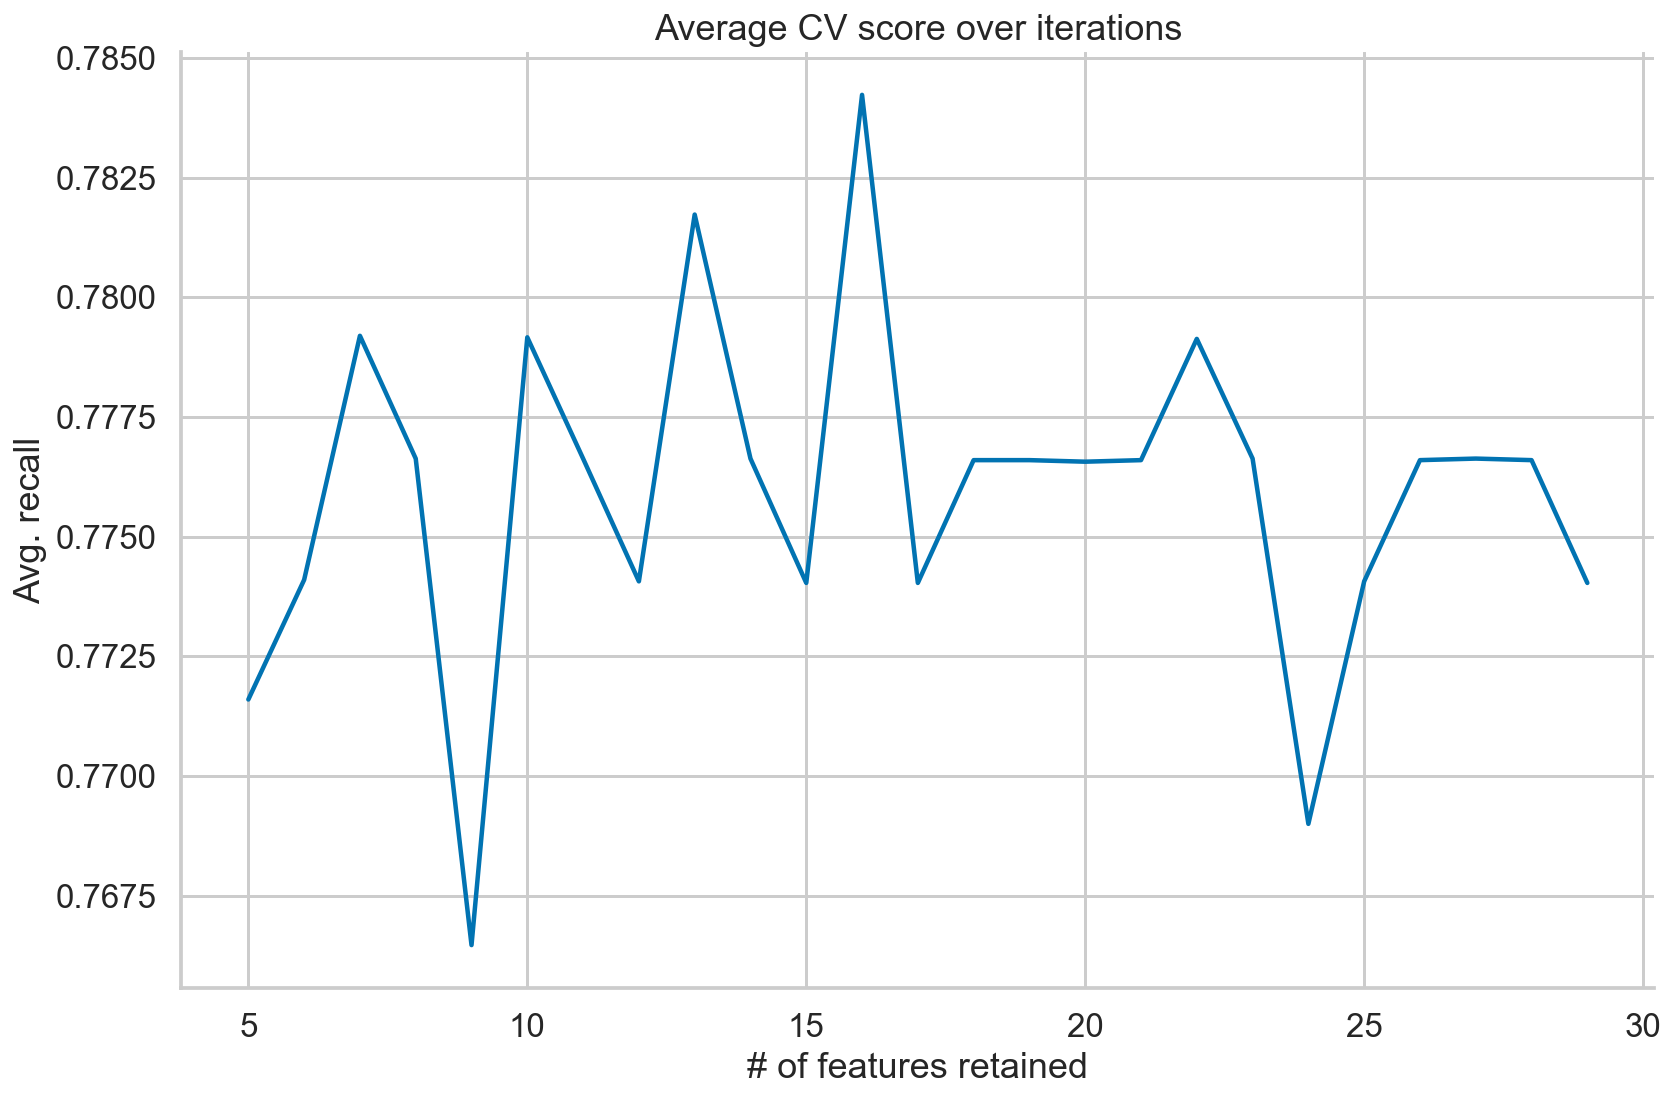

In [20]:
(
    cv_results_df["mean_test_score"]
    .plot(title="Average CV score over iterations",
          xlabel="# of features retained",
          ylabel="Avg. recall")
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_34", dpi=200)

In [21]:
import numpy as np
np.ceil((29 - 5) / 1) + 1

25.0

In [22]:
# feature importances derived from the last fitted model
rfe_cv.estimator_.feature_importances_

array([0.02196562, 0.03372461, 0.02203109, 0.03806824, 0.02769604,
       0.08288049, 0.06599013, 0.19487935, 0.13542467, 0.01912116,
       0.06538599, 0.18863255, 0.02406916, 0.02156627, 0.02517988,
       0.03338473])

### There's more

#### Combining feature selection and hyperparameter tuning

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(
   [
    ("selector", SelectKBest(mutual_info_classif)),
    ("model", rf)
   ]
)

param_grid = {
   "selector__k": [5, 10, 20, 29],
   "model__n_estimators": [10, 50, 100, 200]  
}

gs = GridSearchCV(
   estimator=pipeline,
   param_grid=param_grid,
   n_jobs=-1,
   scoring="recall",
   cv=k_fold,
   verbose=1
)

gs.fit(X_train, y_train)
print(f"Best hyperparameters: {gs.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'model__n_estimators': 50, 'selector__k': 20}


## 14.8 Exploring the Explainable AI (XAI) techniques

### Getting ready

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

df = pd.read_csv("../Datasets/credit_card_fraud.csv")

X = df.copy().drop(columns=["Time"])
y = X.pop("Class")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

### How to do it...

1. Import the libraries:

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from sklearn.inspection import (partial_dependence, 
                                PartialDependenceDisplay)
import shap

2. Train the ML model:

In [5]:
xgb = XGBClassifier(random_state=RANDOM_STATE, 
                    n_jobs=-1)
xgb.fit(X_train, y_train)

recall_train = recall_score(y_train, xgb.predict(X_train))
recall_test = recall_score(y_test, xgb.predict(X_test))
print(f"Recall score training: {recall_train:.4f}")
print(f"Recall score test: {recall_test:.4f}")

Recall score training: 1.0000
Recall score test: 0.8163


3. Plot the ICE curves:

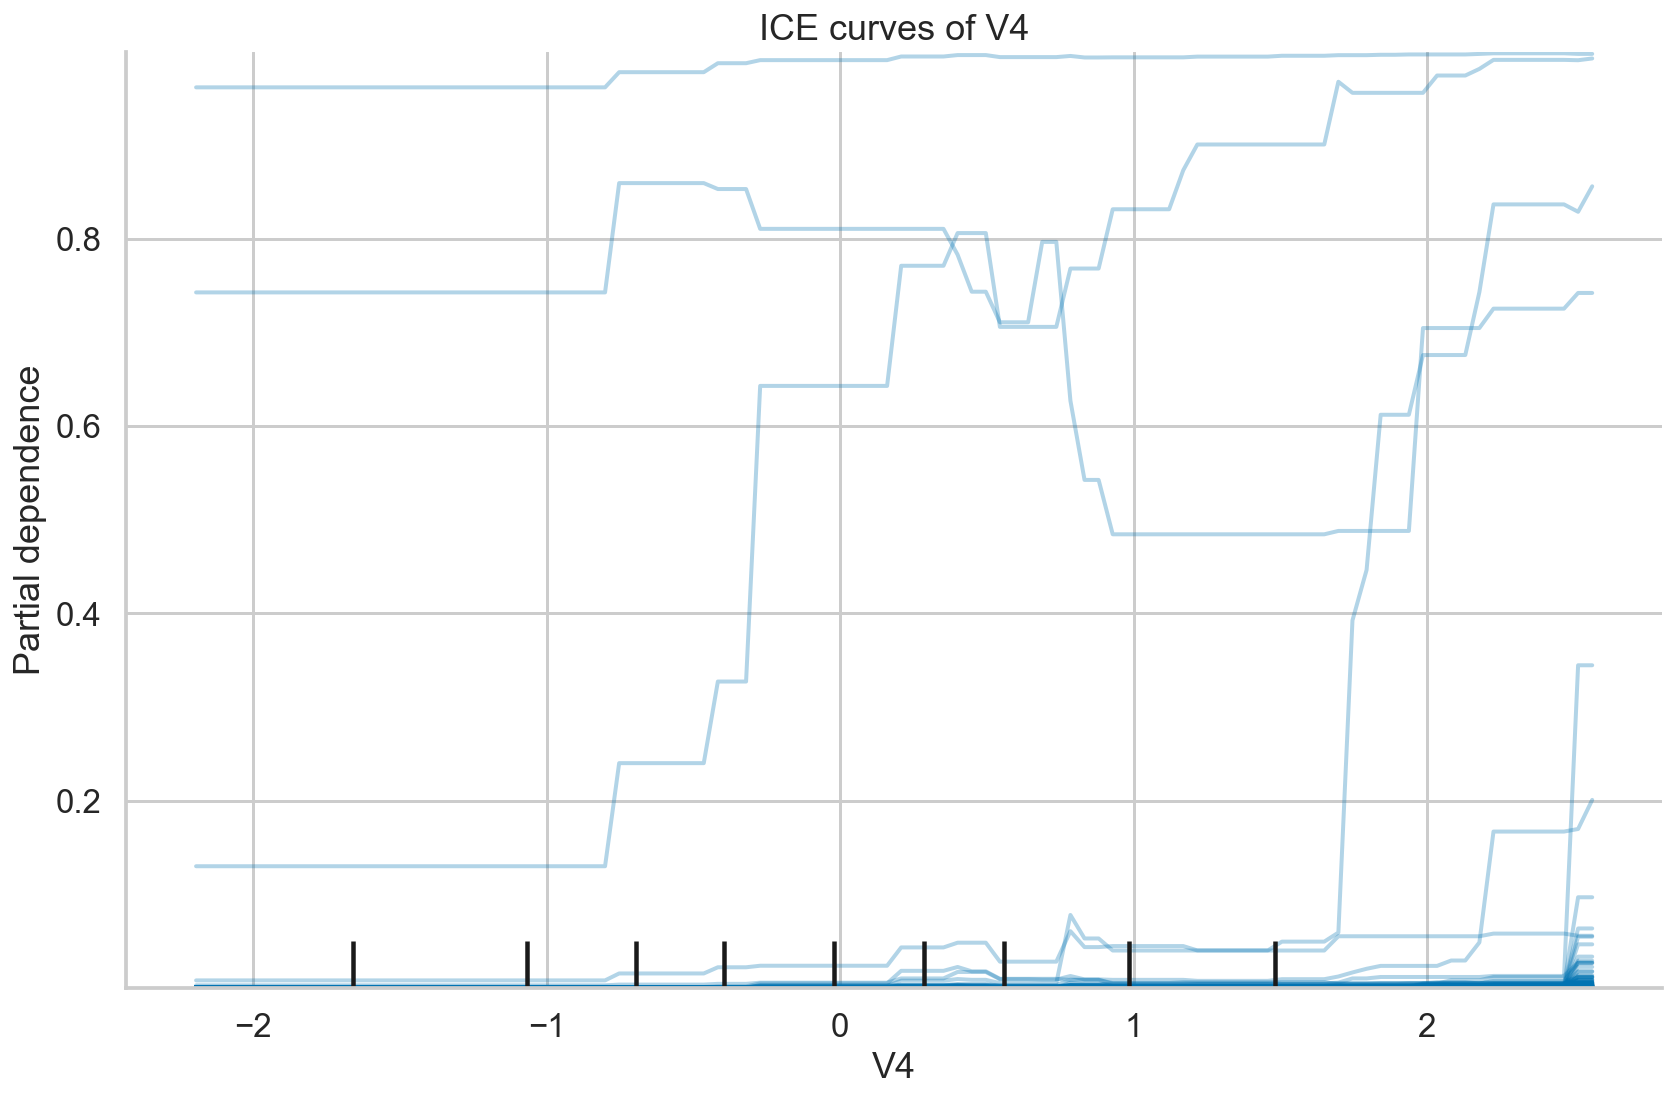

In [21]:
PartialDependenceDisplay.from_estimator(
    xgb, X_train, features=["V4"], 
    kind="individual", 
    subsample=5000, 
    line_kw={"linewidth": 2},
    random_state=RANDOM_STATE
)
plt.title("ICE curves of V4")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_35", dpi=200)

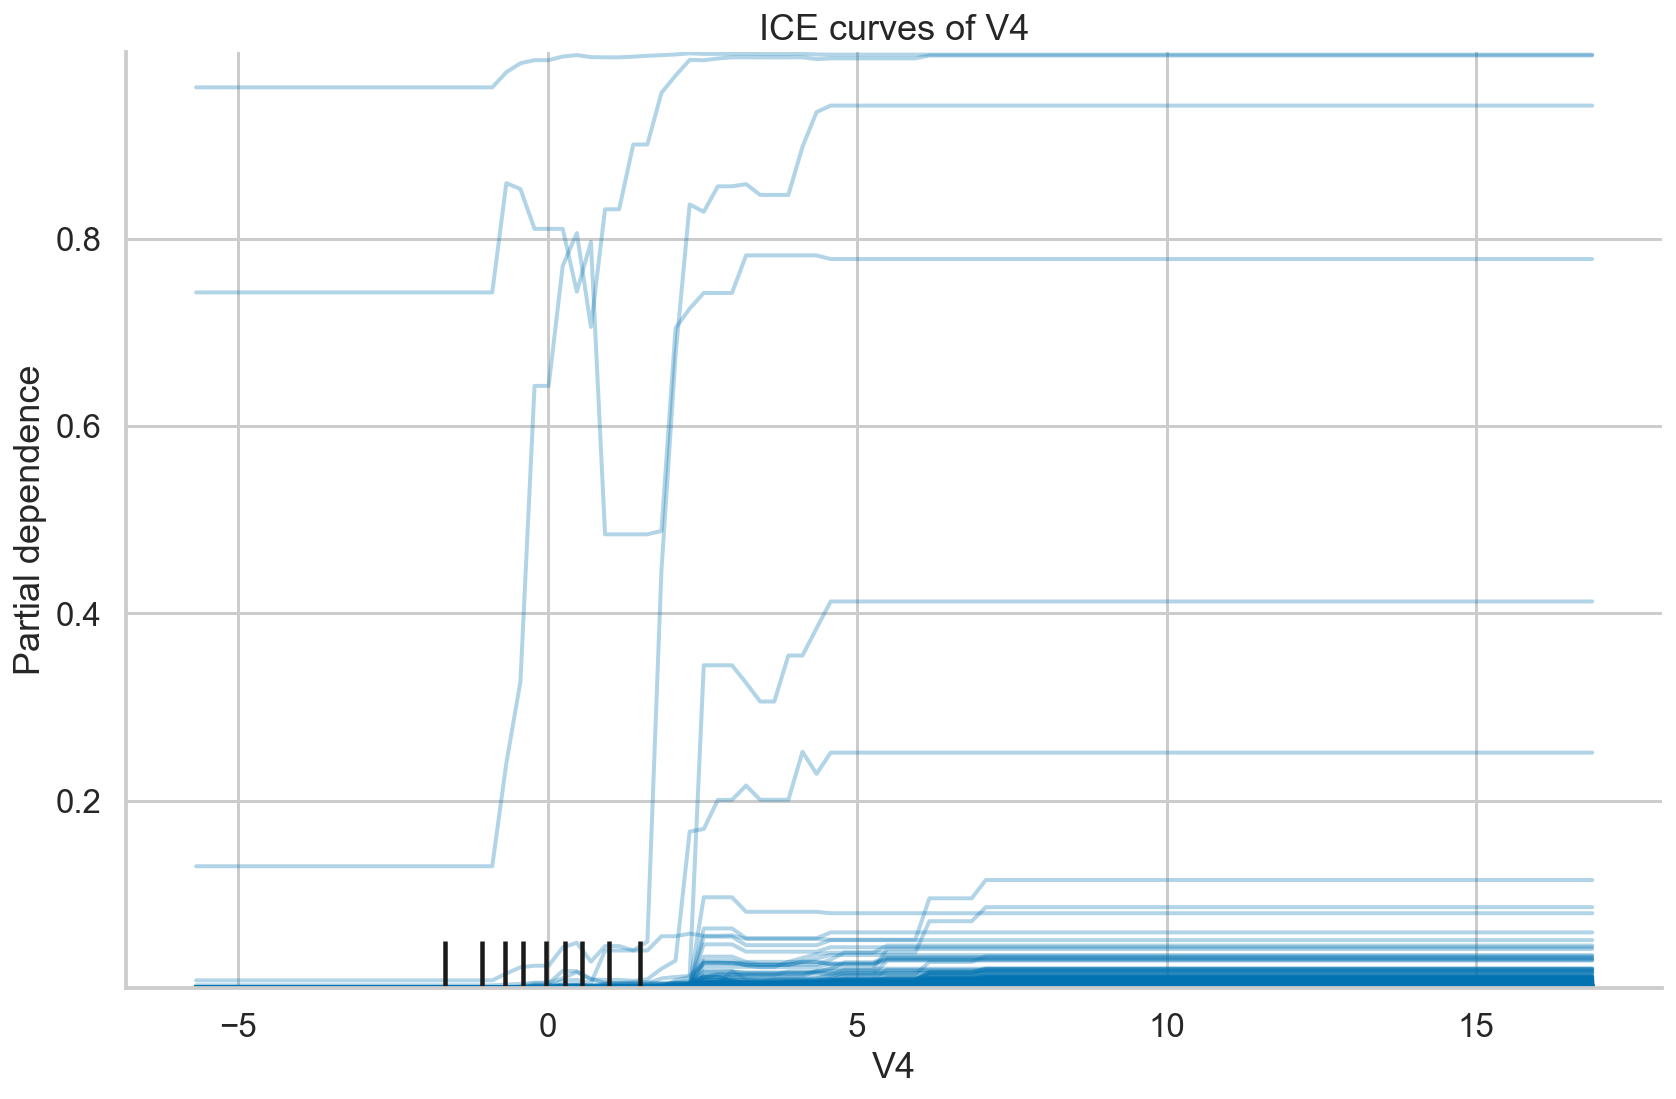

In [ ]:
PartialDependenceDisplay.from_estimator(
    xgb, X_train, features=["V4"], 
    kind="individual", 
    subsample=5000, 
    line_kw={"linewidth": 2},
    percentiles = (0,1),
    random_state=RANDOM_STATE
)
# plt.title("ICE curves of V4 - full range of the feature")

4. Plot the centered ICE curves:

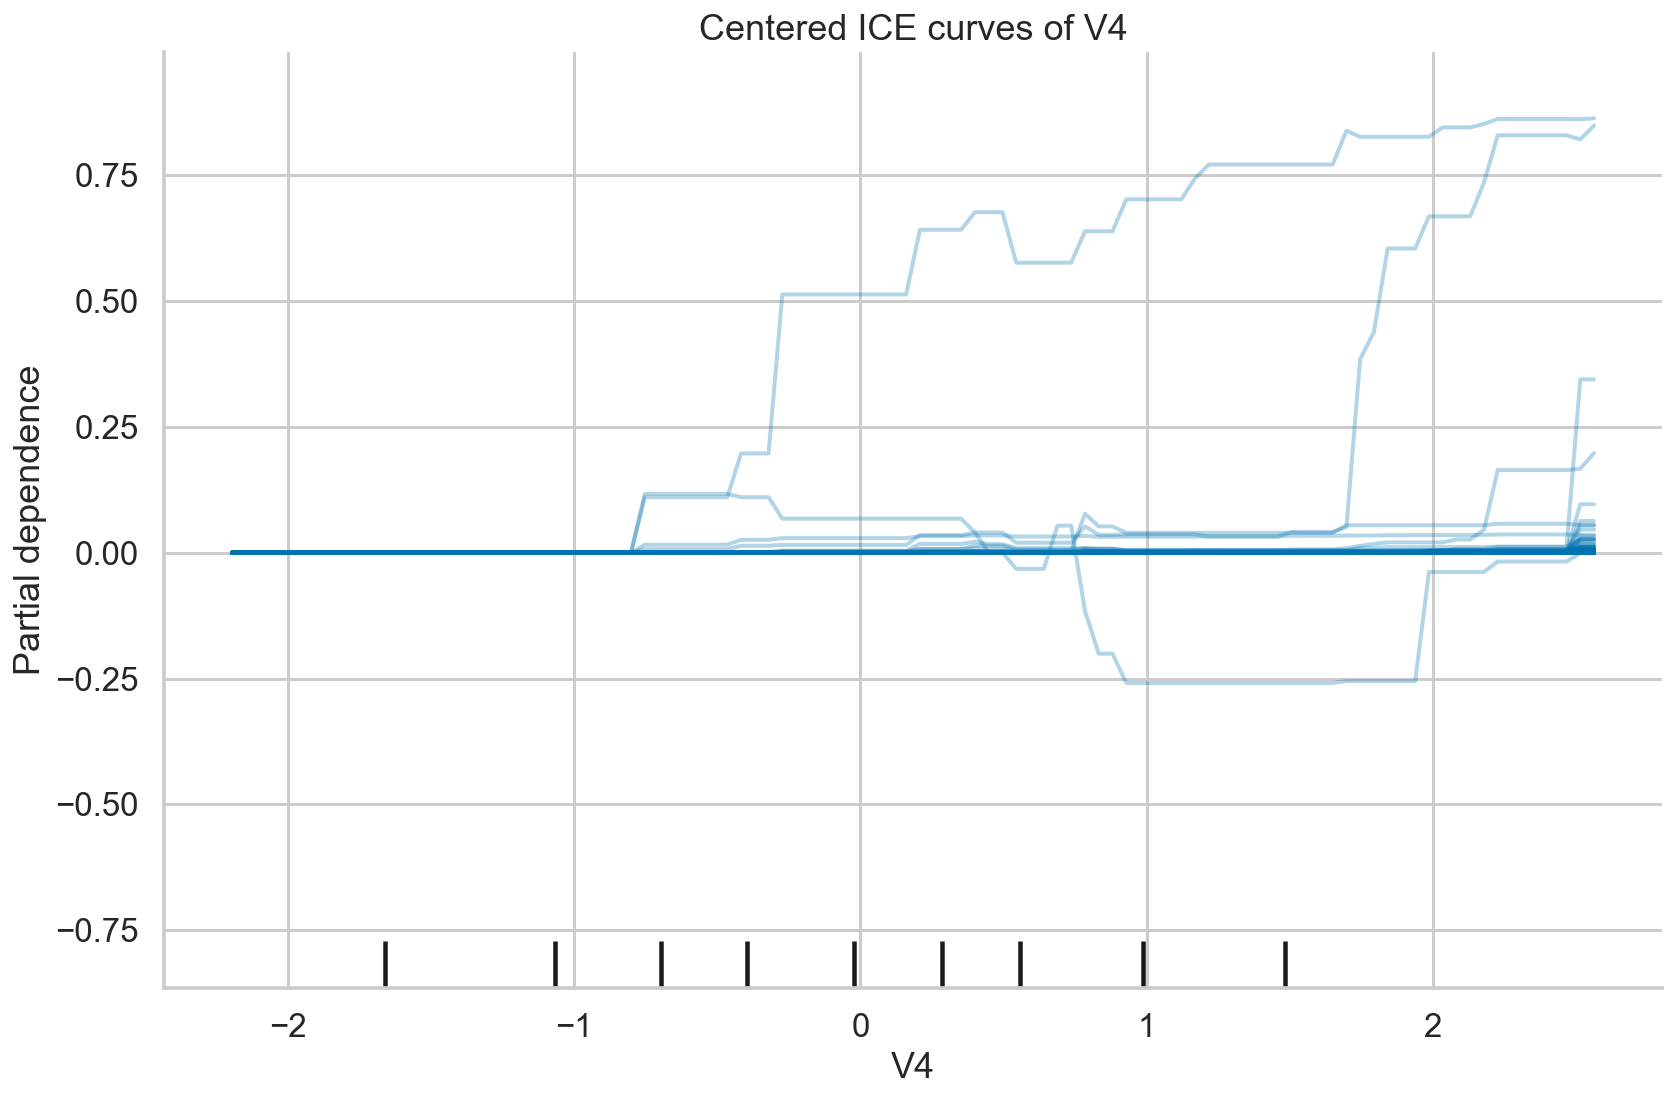

In [7]:
PartialDependenceDisplay.from_estimator(
    xgb, X_train, features=["V4"], 
    kind="individual", 
    subsample=5000,
    centered=True,
    line_kw={"linewidth": 2},
    random_state=RANDOM_STATE
)
plt.title("Centered ICE curves of V4")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_36", dpi=200)

5. Generate the Partial Dependence Plot:

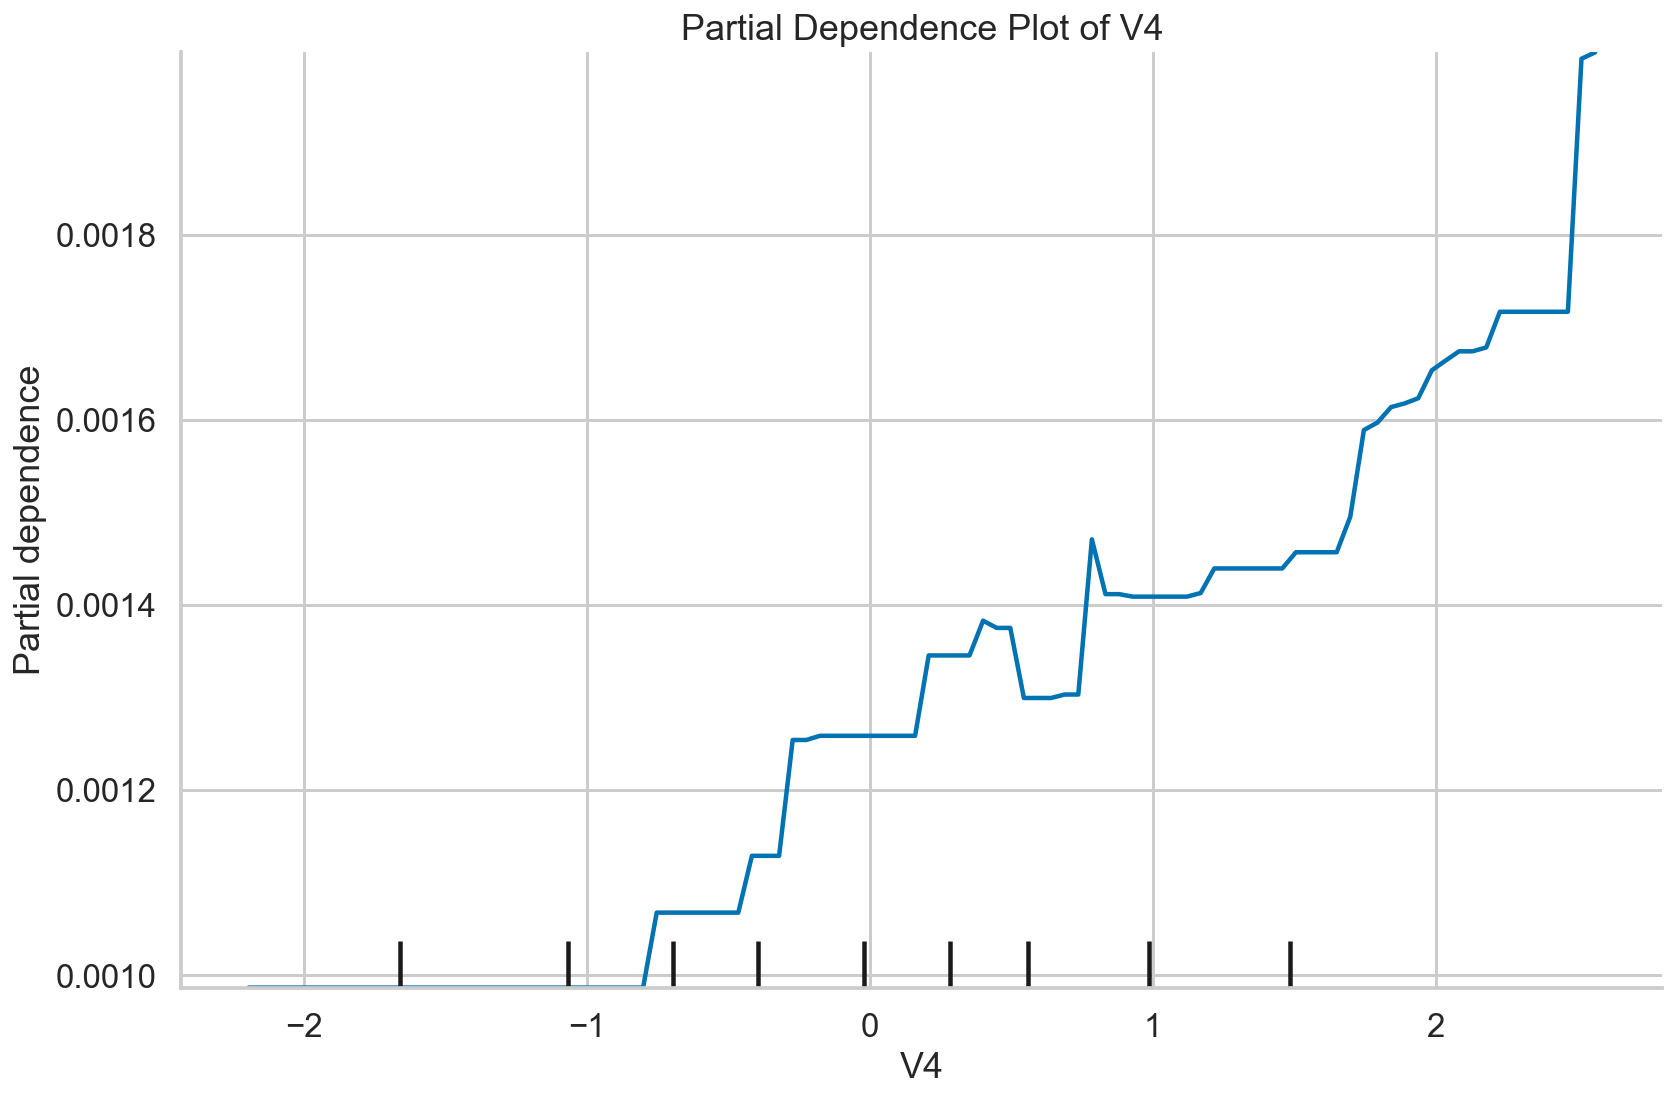

In [8]:
PartialDependenceDisplay.from_estimator(
    xgb, X_train, 
    features=["V4"], 
    random_state=RANDOM_STATE
)
plt.title("Partial Dependence Plot of V4")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_37", dpi=200)

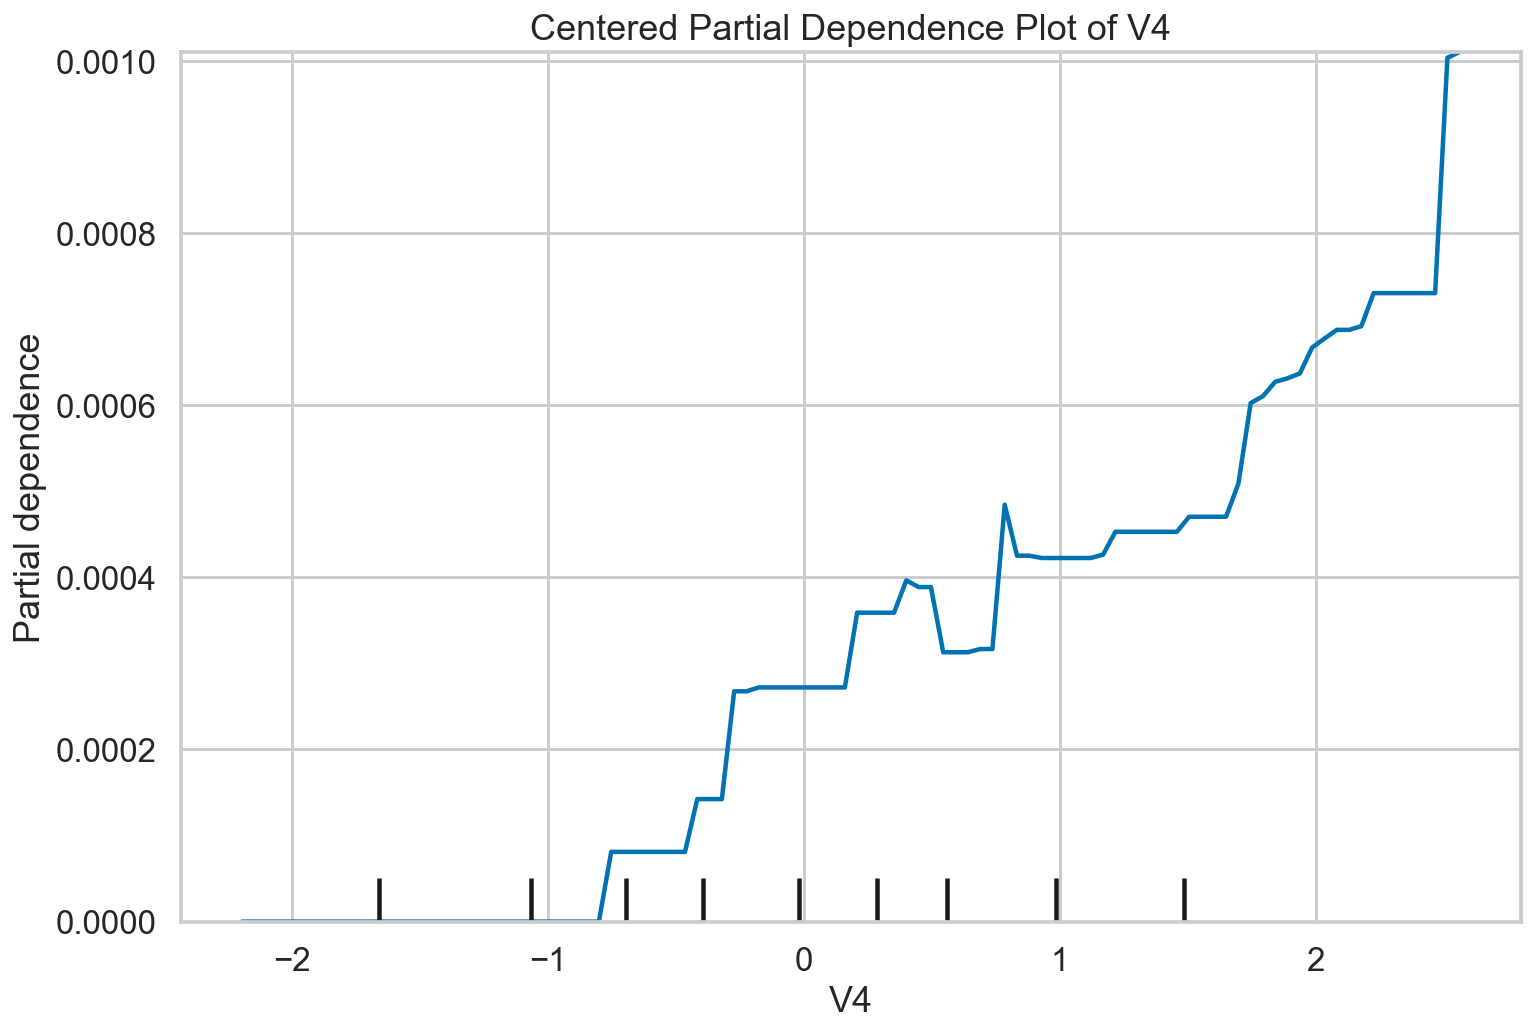

In [9]:
PartialDependenceDisplay.from_estimator(xgb, X_train, features=["V4"], 
                                        random_state=RANDOM_STATE, centered=True)
plt.title("Centered Partial Dependence Plot of V4");

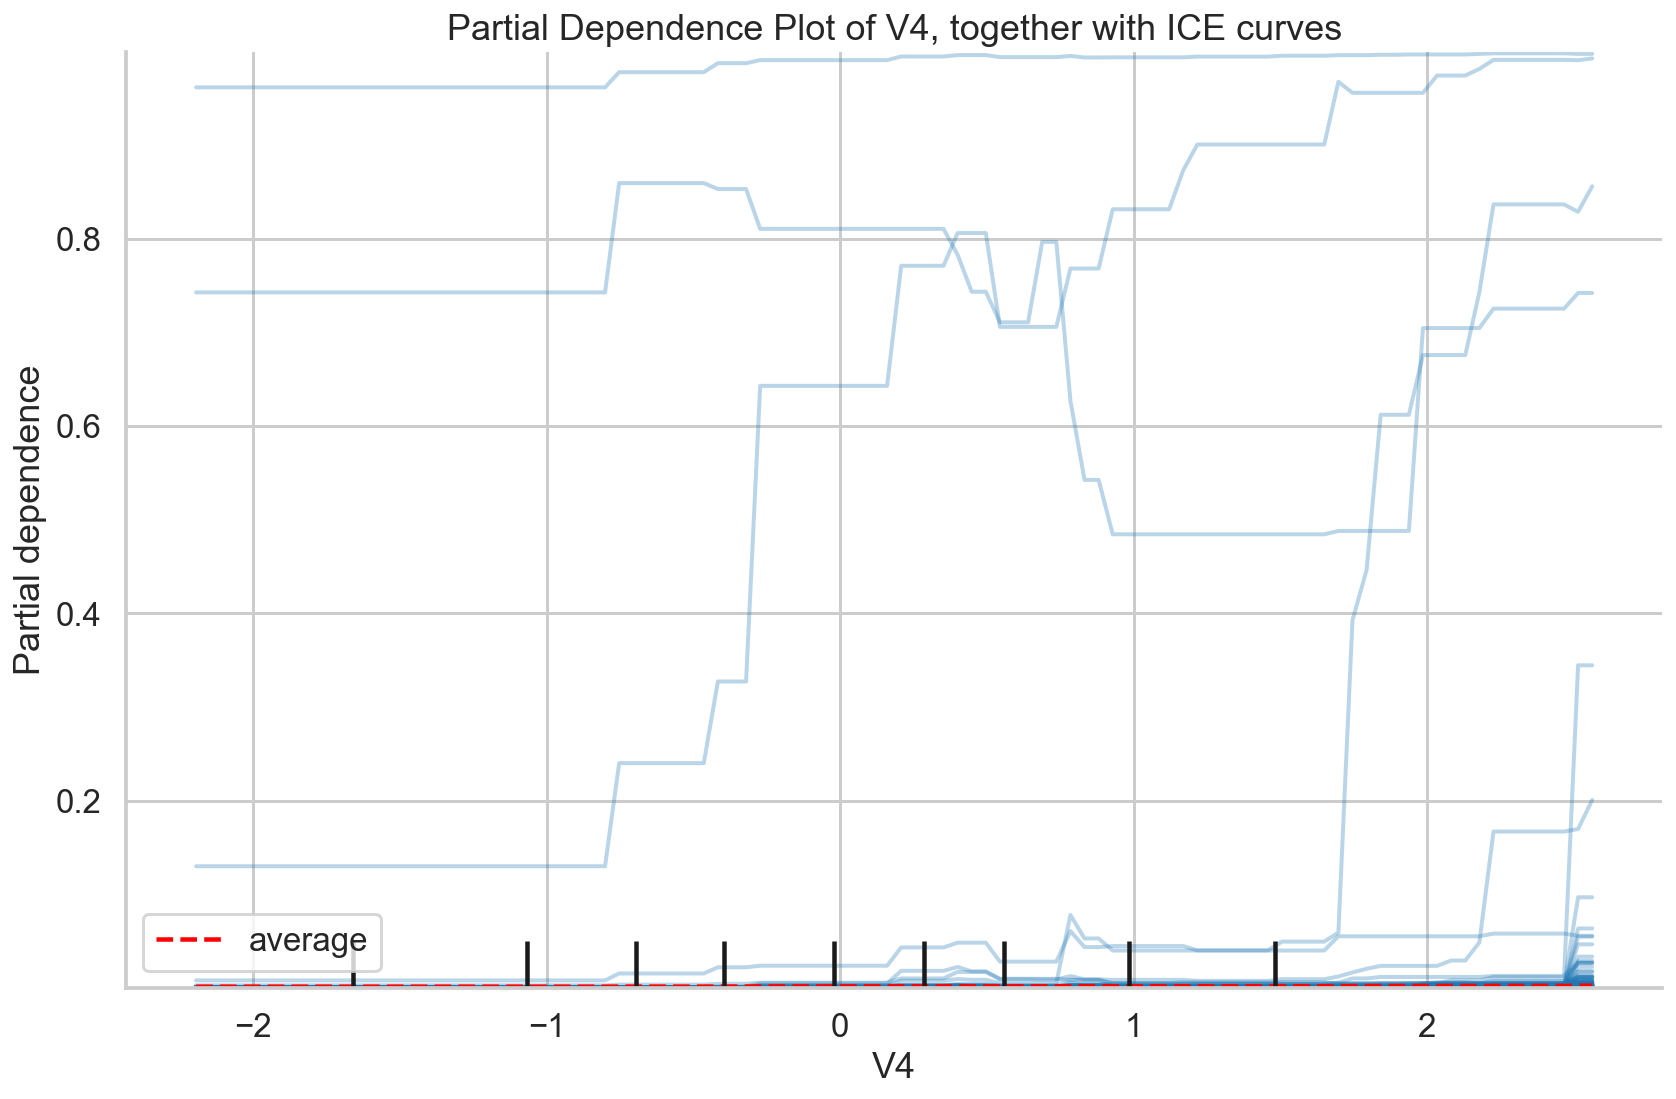

In [19]:
PartialDependenceDisplay.from_estimator(
    xgb, X_train, features=["V4"], 
    kind="both", 
    subsample=5000, 
    ice_lines_kw={"linewidth": 2},
    pd_line_kw={"color": "red"},
    random_state=RANDOM_STATE
)
# plt.ylim(0, 0.05)
plt.title("Partial Dependence Plot of V4, together with ICE curves")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_38", dpi=200)

6. Generate the individual PDPs of two features and a joint one:

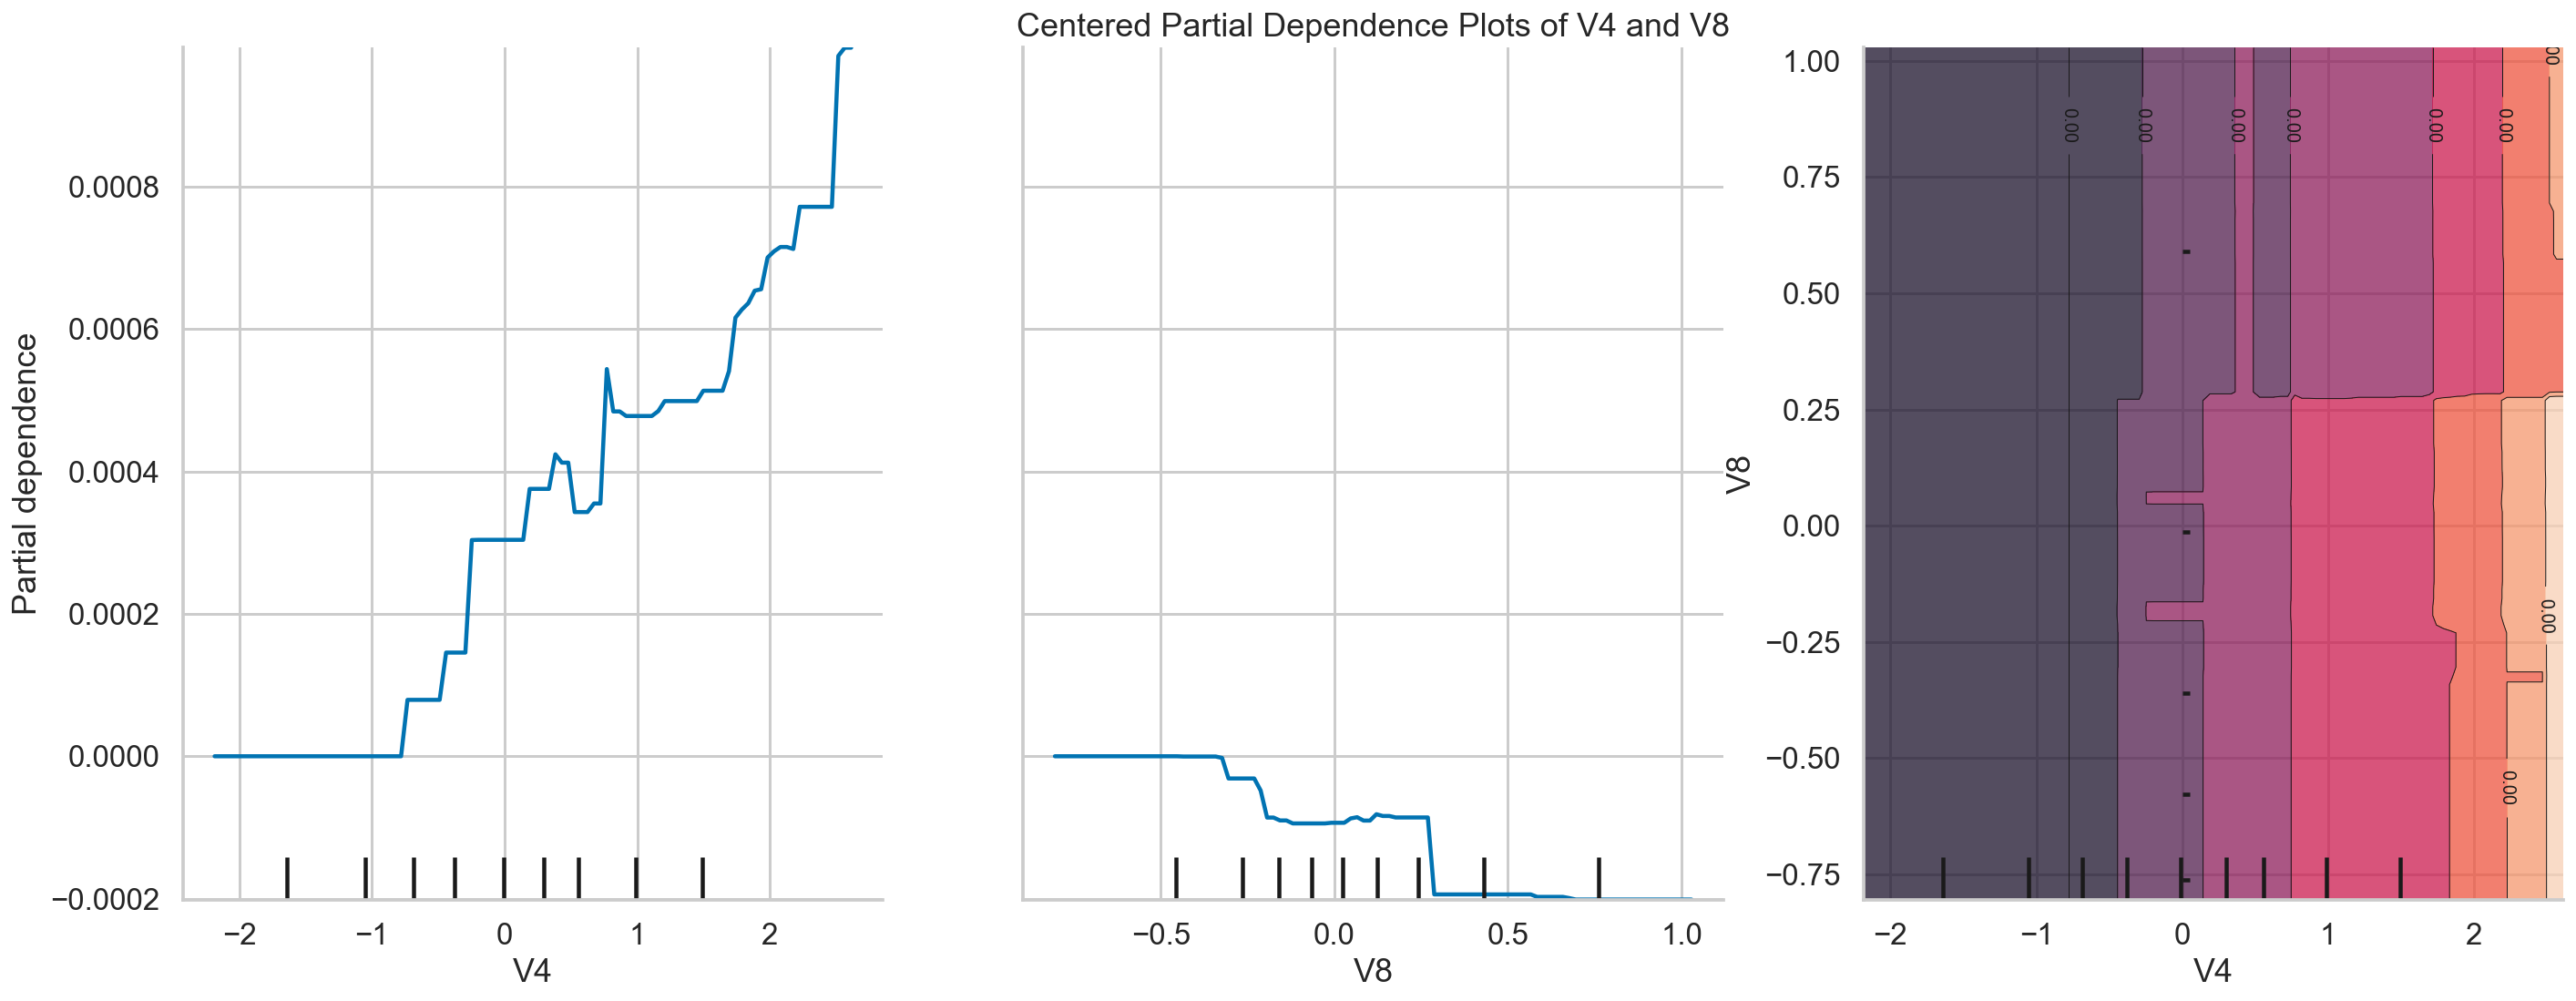

In [8]:
fig, ax = plt.subplots(figsize=(20, 8))

PartialDependenceDisplay.from_estimator(
    xgb,
    X_train.sample(20000, random_state=RANDOM_STATE),
    features=["V4", "V8", ("V4", "V8")],
    centered=True,
    ax=ax
)
ax.set_title("Centered Partial Dependence Plots of V4 and V8")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_14_39", dpi=200)

7. Instantiate an explainer and calculate the SHAP values:

In [6]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)
explainer_x = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [7]:
shap_values.shape

(284807, 29)

In [18]:
# it might be required to run this command before creating the plots
shap.initjs()

8. Generate the SHAP summary plot:

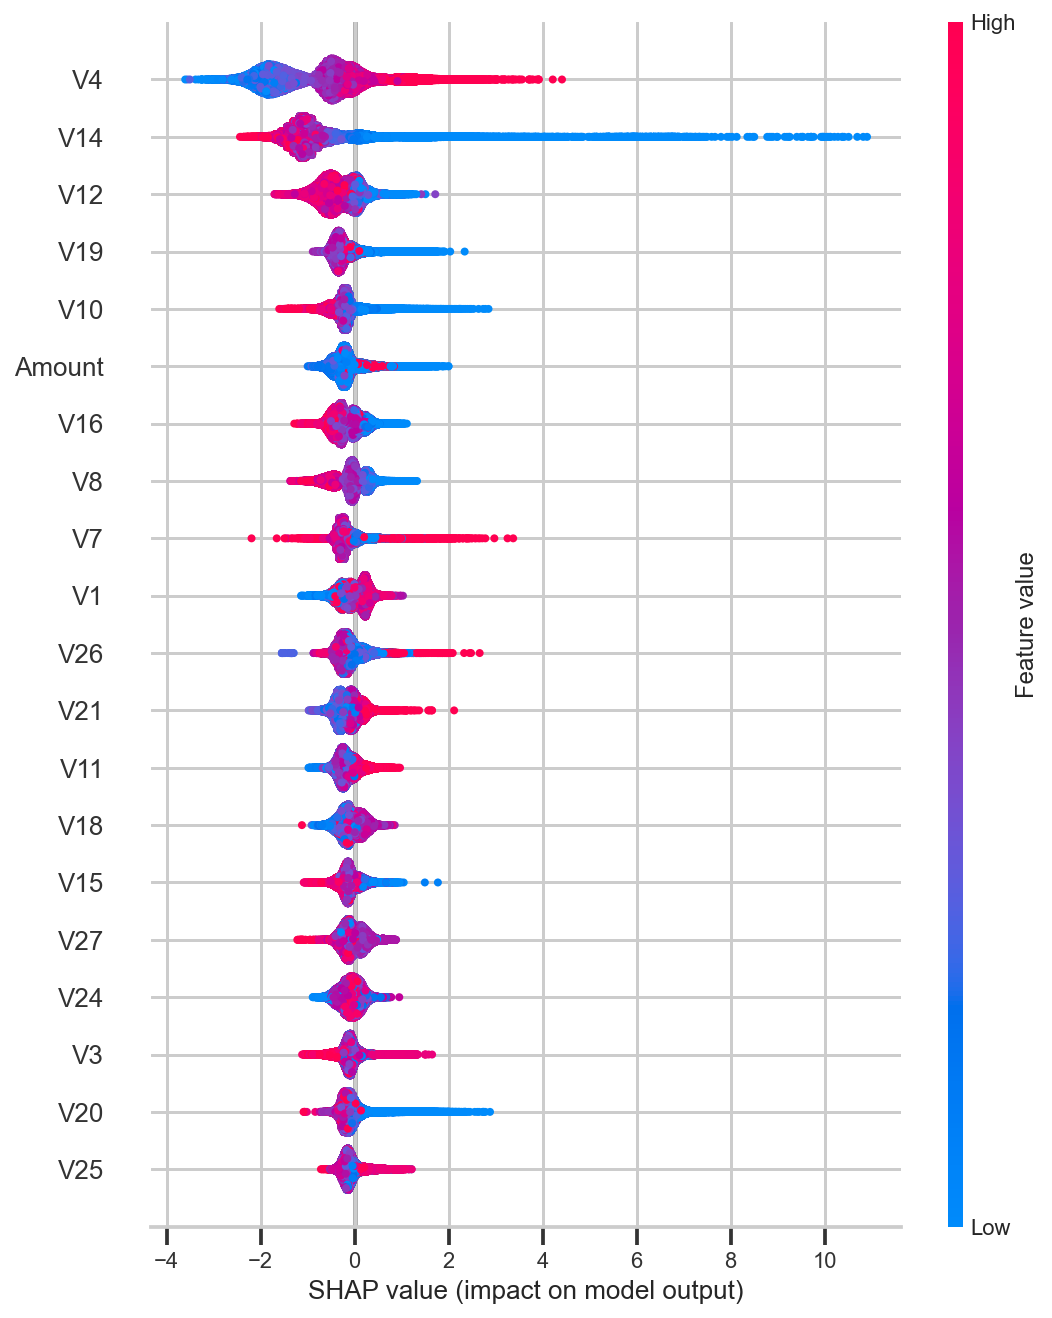

In [9]:
shap.summary_plot(shap_values, X);

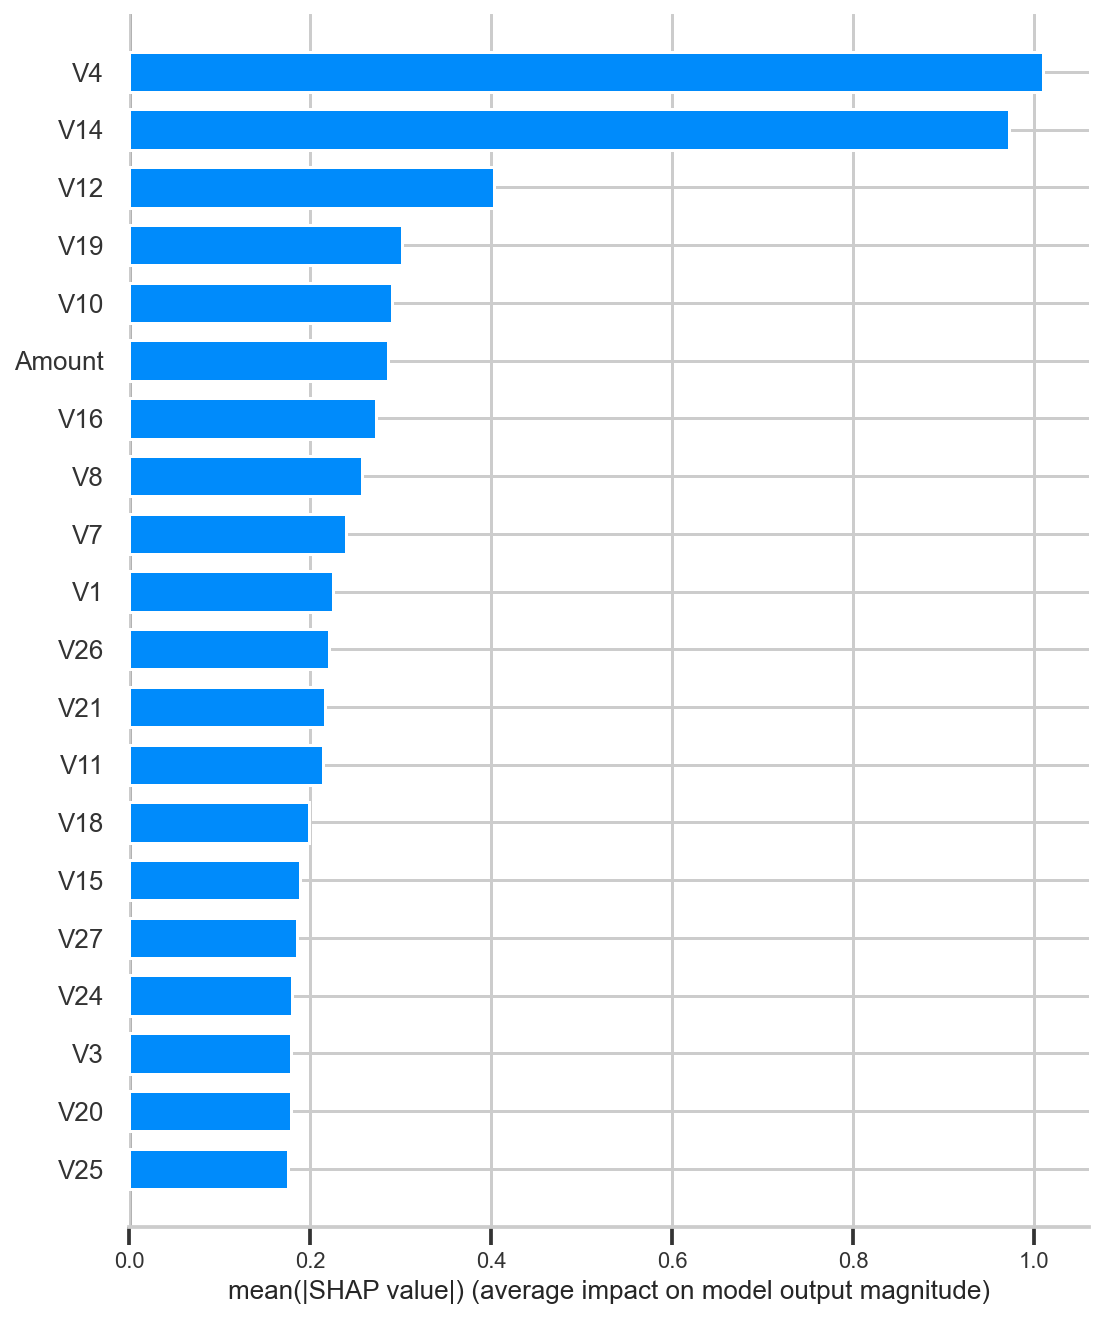

In [10]:
shap.summary_plot(shap_values, X, plot_type="bar");

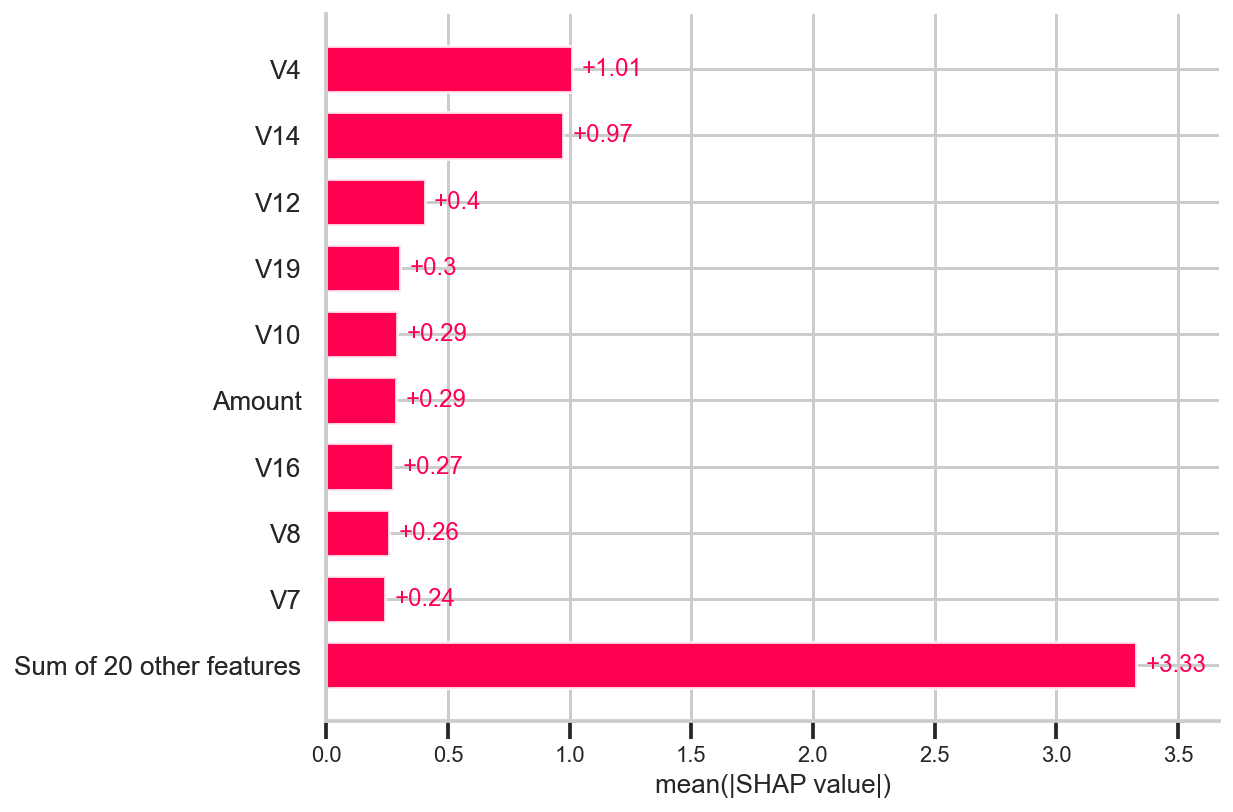

In [11]:
shap.plots.bar(explainer_x)

9. Locate an observation belonging to the positive and negative class:

Explaining single prediction

Let’s start small and simple. With SHAP, we can generate explanations for a single prediction. The SHAP plot shows features that contribute to pushing the output from the base value (average model output) to the actual predicted value.

Red color indicates features that are pushing the prediction higher, and blue color indicates just the opposite.

In [12]:
negative_ind = y[y == 0].index[0]
positive_ind = y[y == 1].index[0]

10. Explain those observations:

In [19]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[negative_ind, :], 
    X.iloc[negative_ind, :]
)

In [20]:
explainer.expected_value

-8.589061

In [21]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[positive_ind, :], 
    X.iloc[positive_ind, :]
)

11. Create a waterfall plot for the positive observation:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


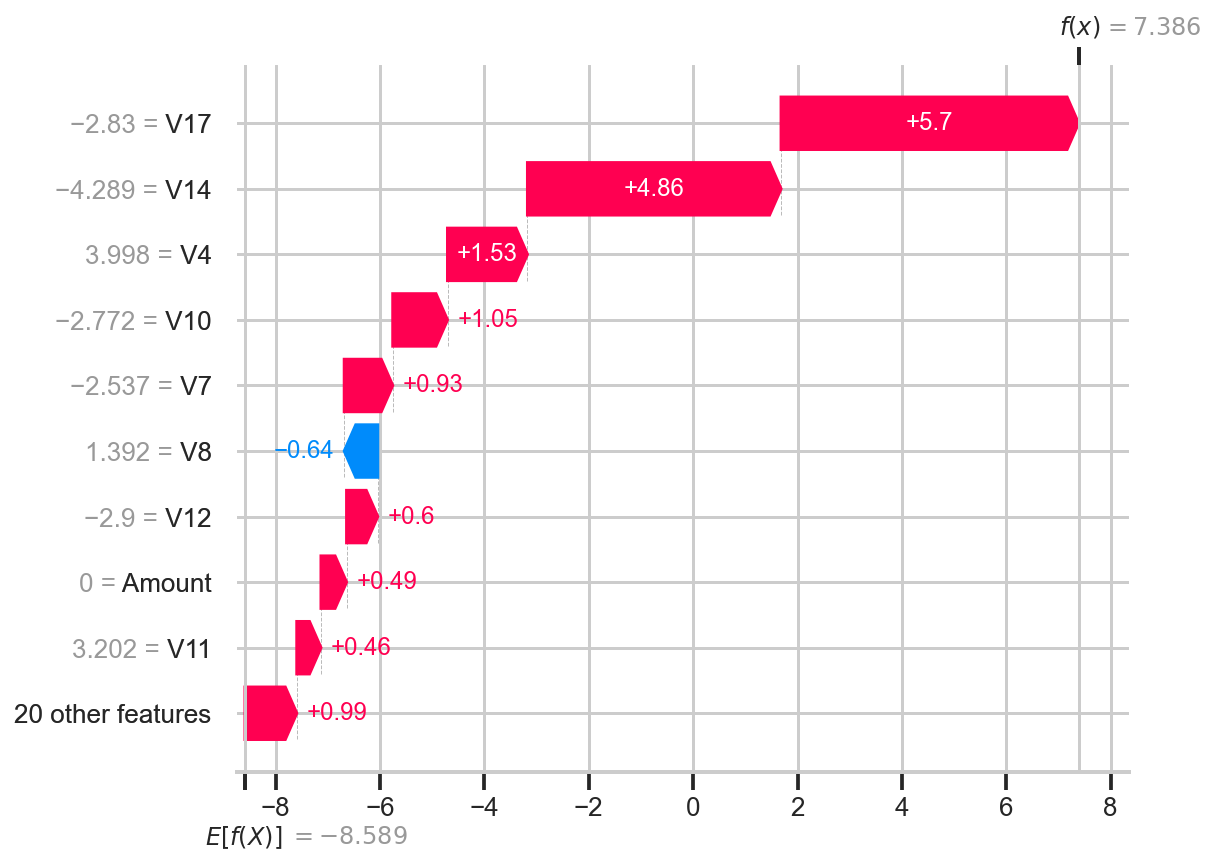

In [16]:
shap.plots.waterfall(explainer(X)[positive_ind])
# shap.plots.waterfall(explainer(X)[positive_ind], max_display=30)

12. Create a dependence plot of the `V4` feature:

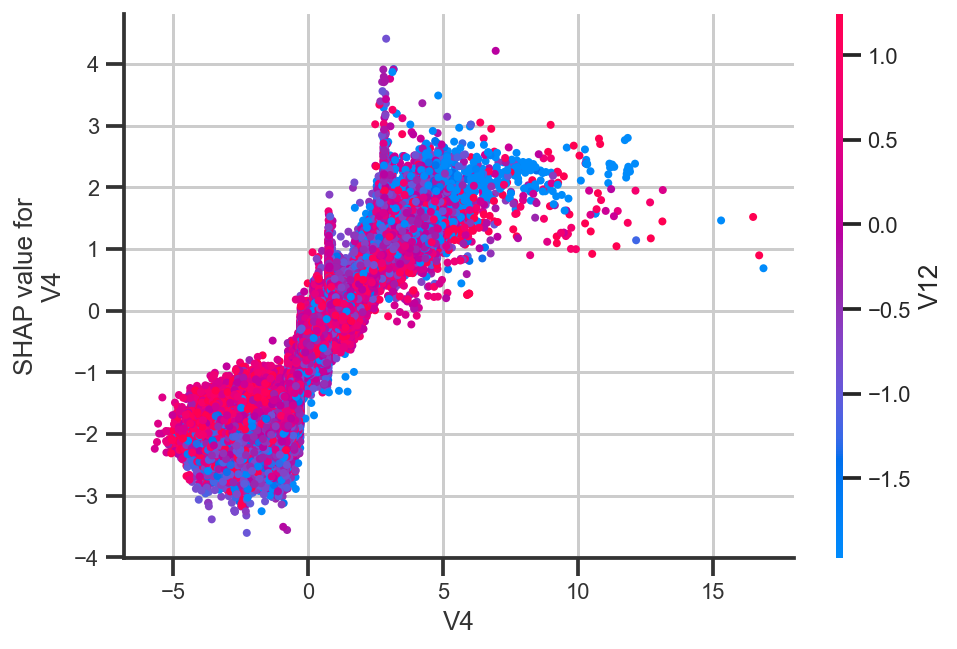

In [17]:
shap.dependence_plot("V4", shap_values, X)

### There's more

In [ ]:
dependence_dict = partial_dependence(rf, X_train, "V17", kind="both")
dependence_dict.keys()

dict_keys(['average', 'individual', 'values'])

In [ ]:
dependence_dict["average"]

array([[0.00188321, 0.00188321, 0.00188321, 0.00188321, 0.00188229,
        0.0022492 , 0.00165529, 0.00164213, 0.00164037, 0.00163787,
        0.00163629, 0.00163629, 0.00163537, 0.00163537, 0.00163497,
        0.00163497, 0.00163453, 0.00163409, 0.00163335, 0.00162966,
        0.00162909, 0.00162909, 0.00162909, 0.00162909, 0.00162909,
        0.00162909, 0.00161224, 0.00160311, 0.00160311, 0.00160311,
        0.00160311, 0.00160311, 0.00160311, 0.00160311, 0.00160258,
        0.00160258, 0.00160258, 0.00160258, 0.00160197, 0.00160197,
        0.00160258, 0.00160333, 0.00160205, 0.00160144, 0.00160113,
        0.00160113, 0.00160131, 0.00160135, 0.00160205, 0.00160333,
        0.00160302, 0.00160236, 0.00160249, 0.00160618, 0.00161017,
        0.00160715, 0.0016132 , 0.00161325, 0.00161373, 0.00161136,
        0.00161171, 0.00161171, 0.00161171, 0.00161184, 0.00161926,
        0.00161987, 0.00162198, 0.0016333 , 0.00171656, 0.00164682,
        0.00165288, 0.00165161, 0.00166354, 0.00

In [ ]:
dependence_dict["individual"].shape

(1, 227845, 100)

In [ ]:
dependence_dict["values"]

[array([-0.98213146, -0.95935212, -0.93657278, -0.91379343, -0.89101409,
        -0.86823475, -0.84545541, -0.82267607, -0.79989672, -0.77711738,
        -0.75433804, -0.7315587 , -0.70877936, -0.68600002, -0.66322067,
        -0.64044133, -0.61766199, -0.59488265, -0.57210331, -0.54932397,
        -0.52654462, -0.50376528, -0.48098594, -0.4582066 , -0.43542726,
        -0.41264791, -0.38986857, -0.36708923, -0.34430989, -0.32153055,
        -0.29875121, -0.27597186, -0.25319252, -0.23041318, -0.20763384,
        -0.1848545 , -0.16207515, -0.13929581, -0.11651647, -0.09373713,
        -0.07095779, -0.04817845, -0.0253991 , -0.00261976,  0.02015958,
         0.04293892,  0.06571826,  0.0884976 ,  0.11127695,  0.13405629,
         0.15683563,  0.17961497,  0.20239431,  0.22517366,  0.247953  ,
         0.27073234,  0.29351168,  0.31629102,  0.33907036,  0.36184971,
         0.38462905,  0.40740839,  0.43018773,  0.45296707,  0.47574641,
         0.49852576,  0.5213051 ,  0.54408444,  0.5